In [1]:
import os
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np
# from cv2 import dnn_superres
import re
import joblib
import re
import pandas as pd
from utils import download_image

In [2]:
# df = pd.read_csv('../dataset/test.csv')
# image_folder = '../images/test'

In [3]:
df = pd.read_csv('../dataset1/test.csv')
image_folder = '../images/test'

In [4]:
AREA_THRESHOLD = 500000
reader = easyocr.Reader(['en'])

In [5]:
loaded_model = joblib.load('../best_model.pkl')
label_encoder_group = joblib.load('../label_encoder_group.pkl')
label_encoder_entity = joblib.load('../label_encoder_entity.pkl')

d:\Softwares\Anaconda\envs\GG_2526\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'maximum_weight_recommendation': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart'}
}

In [7]:
abbreviation_map = {
    'cm': 'centimetre', 'CM': 'centimetre',
    'ft': 'foot', 'FT': 'foot',
    'in': 'inch', 'IN': 'inch', 'inch.': 'inch',
    'm': 'metre', 'M': 'metre',
    'mm': 'millimetre',
    'yd': 'yard',
    'g': 'gram', 'G': 'gram',
    'KG': 'kilogram', 'kg': 'kilogram', 'Kg': 'kilogram',
    'mcg': 'microgram', 'MCG': 'microgram',
    'mg': 'milligram', 'MG': 'milligram',
    'oz': 'ounce', 'OZ': 'ounce',
    'lbs': 'pound', 'LBS': 'pound',
    'ton': 'ton', 'TON': 'ton',
    'kV': 'kilovolt', 'kv': 'kilovolt', 'KV': 'kilovolt',
    'mV': 'millivolt', 'mv': 'millivolt', 'MV': 'millivolt',
    'v': 'volt', 'V': 'volt',
    'kw': 'kilowatt', 'kW': 'kilowatt', 'Kw': 'kilowatt',
    'w': 'watt', 'W': 'watt',
    'cl': 'centilitre', 'Cl': 'centilitre',
    'cu ft': 'cubic foot',
    'cups': 'cup', 'CUPS': 'cup',
    'dl': 'decilitre', 'dL': 'decilitre', 'Dl': 'decilitre',
    'fl oz': 'fluid ounce',
    'gal': 'gallon',
    'imp gal': 'imperial gallon',
    'l': 'litre', 'L': 'litre',
    'ul': 'microlitre', 'uL': 'microlitre',
    'ml': 'millilitre', 'mL': 'millilitre', 'Ml': 'millilitre',
    'pt': 'pint',
    'qt': 'quart'
}

In [8]:
def calArea(img, area):
    if area < AREA_THRESHOLD:
        scale_percent = 300  # percent of original size
        new_width = int(img.shape[1] * scale_percent / 100)
        new_height = int(img.shape[0] * scale_percent / 100)
        dim = (new_width, new_height)
        img = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
        print(f"Scaled Image Dimensions: Width={new_width}, Height={new_height}")
    return img

In [9]:
def process_inference_output(texts, valid_units):
    processed_texts = []

    for text in texts:
        # Ensure space after each number
        text_with_spaces = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', text)
        
        # Split words separated by slashes, commas, or periods
        words = re.split(r'[\/,]', text_with_spaces)
        
        # Add processed words to the list
        for word in words:
            cleaned_word = word.strip()
            if cleaned_word:  # Ensure the word is not empty
                processed_texts.append(cleaned_word)

    final_texts = []
    for text in processed_texts:
        # Check if the text contains a valid unit
        for unit in valid_units:
            if unit in text:
                # Find the position of the last character of the valid unit
                unit_pos = text.find(unit) + len(unit)
                # Slice the text to keep only the valid unit and the preceding number
                cleaned_text = text[:unit_pos].strip()
                final_texts.append(cleaned_text)
                break
        else:
            # If no valid unit is found, keep the original text
            final_texts.append(text)
    
    return final_texts

In [10]:
def filter_invalid_elements(texts, valid_units):
    filtered_texts = []

    for text in texts:
        words = text.split()
        is_valid = True
        for word in words:
            if word not in valid_units and not re.match(r'\d+(\.\d+)?', word):
                is_valid = False
                break
        if is_valid:
            filtered_texts.append(text)
    
    return filtered_texts

In [11]:
def inference(image_path, entity_name):
    img = cv2.imread(image_path)
    height, width, _ = img.shape
    area = height * width
    print(f"Original Image Dimensions: Width={width}, Height={height}, Area={area}")
    img = calArea(img, area)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    inverted = cv2.bitwise_not(gray)

    result = reader.readtext(inverted)

    plt.imshow(cv2.cvtColor(inverted, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    unique_values = set()
    valid_units = entity_unit_map[entity_name]
    print(result)
    cleaned_texts = []
    for detection in result:
        text = detection[1]
        # Replace any occurrence of a number followed by a point, followed by 'S', and then followed by another number with '5' instead of 'S'
        text = re.sub(r'(\d+\.\d*)S(\d+)', r'\1 5 \2', text)
        text_no_spaces = re.sub(r'(\d)\s+', r'\1', text)
        text_replaced = re.sub(r'I(?=\d)', '/', text_no_spaces)
        processed_words = []
        words = text_replaced.split()
        for word in words:
        # If the word contains a digit, keep it; otherwise, discard it
            if re.search(r'\d', word):
                processed_words.append(word)

        final_text = ' '.join(processed_words)
    
        final_text = final_text.replace('\"', ' in')
        
        # Remove specific unwanted characters
        final_text = final_text.replace('*', '').replace(':', '').replace('+', '')
        
        # Remove sequences of 6 or more digits
        final_text = re.sub(r'\b\d{6,}\b', '', final_text)
        
        # Remove sequences of 6 or more digits followed by alphabetic characters
        final_text = re.sub(r'\b\d{6,}[a-zA-Z]*\b', '', final_text)
        
        # Remove sequences of digits separated by spaces
        final_text = re.sub(r'\b\d+\s+\d+\b', '', final_text)
        
        # Remove sequences of digits followed by an asterisk
        final_text = re.sub(r'\b\d+\*\b', '', final_text)
        
        # Remove text within square or round brackets
        final_text = re.sub(r'\[.?\]|\(.?\)', '', final_text)
        
        # Remove sequences of digits separated by two dots
        final_text = re.sub(r'\b\d+\.\.\d+\b', '', final_text)
        
        # Remove sequences of digits preceded by whitespace
        final_text = re.sub(r'\s+\d+', '', final_text)

        # Remove trailing special characters
        final_text = re.sub(r'[^a-zA-Z0-9\s]+$', '', final_text)
        
        cleaned_texts.append(final_text)
    print(f"first: {cleaned_texts}")
    
    cleaned_texts = process_inference_output(cleaned_texts,valid_units)
    print(f"before {cleaned_texts}")
    for i in range(len(cleaned_texts)):
        contains_valid_unit = any(unit in cleaned_texts[i] for unit in valid_units)
        if not contains_valid_unit:
            words = cleaned_texts[i].split()
            new_words = []
            for word in words:
                matched = False
                for abbr, full_form in abbreviation_map.items():
                    if word == abbr and full_form in valid_units:
                        new_words.append(full_form)
                        matched = True
                        break
                if not matched:
                    new_words.append(word)
            cleaned_texts[i] = ' '.join(new_words)
    
    print(f"before {cleaned_texts}")
    # Filter out unique valid texts
    final_unique_texts = []
    unique_values = set()

    for text in cleaned_texts:
        normalized_text = text.strip().lower()  # Normalize the text by stripping whitespace and converting to lowercase
        if normalized_text not in unique_values:
            for unit in valid_units:
                if unit in normalized_text:
                    unique_values.add(normalized_text)
                    final_unique_texts.append(text)  # Append the original text
                    break
    final_unique_texts = filter_invalid_elements(final_unique_texts, valid_units)
    return final_unique_texts

In [12]:
def convert_to_common_unit(value, entity_name):
    # match = re.match(r"([0-9.]+)\s*(\w+)", value)
    # if not match:
    #     return None
    num, unit = value.split()
    num = float(num)
    unit = unit.lower()
    print(num)
    print(unit)
    
    if entity_name in ['width', 'depth', 'height']:
        if unit in ['mm', 'millimeter', 'millimeters', 'millimetre', 'millimetres']:
            return num / 1000
        elif unit in ['cm', 'centimeter', 'centimeters', 'centimetre']:
            return num / 100
        elif unit in ['m', 'meter', 'meters', 'metre', 'metres']:
            return num
        elif unit in ['km', 'kilometer', 'kilometers', 'kilometre', 'kilometres']:
            return num * 1000
        elif unit in ['ft', 'foot', 'feet']:
            return num * 0.3048
        elif unit in ['in', 'inch', 'inches']:
            return num * 0.0254
        elif unit in ['yd', 'yard', 'yards']:
            return num * 0.9144
    elif entity_name in ['item_weight', 'maximum_weight_recommendation']:
        if unit in ['mg', 'milligram', 'milligrams']:
            return num / 1000
        elif unit in ['g', 'gram', 'grams']:
            return num
        elif unit in ['kg', 'kilogram', 'kilograms']:
            return num * 1000
        elif unit in ['t', 'ton', 'tons']:
            return num * 1e6
        elif unit in ['oz', 'ounce', 'ounces']:
            return num * 28.3495
        elif unit in ['lb', 'pound', 'pounds']:
            return num * 453.592
    elif entity_name == 'voltage':
        if unit in ['mv', 'millivolt', 'millivolts']:
            return num / 1000
        elif unit in ['kv', 'kilovolt', 'kilovolts']:
            return num * 1000
        elif unit in ['v', 'volt', 'volts']:
            return num
    elif entity_name == 'wattage':
        if unit in ['kw', 'kilowatt', 'kilowatts']:
            return num * 1000
        elif unit in ['w', 'watt', 'watts']:
            return num
    elif entity_name == 'item_volume':
        if unit in ['ml', 'millilitre', 'millilitres', 'milliliter', 'milliliters']:
            return num
        elif unit in ['l', 'litre', 'litres', 'liter', 'liters']:
            return num * 1000
        elif unit in ['cl', 'centilitre', 'centilitres', 'centiliter', 'centiliters']:
            return num * 10
        elif unit in ['dl', 'decilitre', 'decilitres', 'deciliter', 'deciliters']:
            return num * 100
        elif unit in ['fl oz', 'fluid ounce', 'fluid ounces']:
            return num * 29.5735
        elif unit in ['cup', 'cups']:
            return num * 240
        elif unit in ['pt', 'pint', 'pints']:
            return num * 473.176
        elif unit in ['qt', 'quart', 'quarts']:
            return num * 946.353
        elif unit in ['gal', 'gallon', 'gallons']:
            return num * 3785.41
        elif unit in ['imp gal', 'imperial gallon', 'imperial gallons']:
            return num * 4546.09
        elif unit in ['cu ft', 'cubic foot', 'cubic feet']:
            return num * 28316.8
        elif unit in ['cu in', 'cubic inch', 'cubic inches']:
            return num * 16.3871
    return None

In [13]:
def get_dimension(model, group_id, entity_name, entity_values):
    group_id_encoded = label_encoder_group.transform([group_id])[0]
    entity_name_encoded = label_encoder_entity.transform([entity_name])[0]
    
    best_entity_value = None
    highest_score = -1
    
    for entity_value in entity_values:
        entity_value_meters = convert_to_common_unit(entity_value, entity_name)
        if entity_value_meters is None:
            continue
        input_data = np.array([[group_id_encoded, entity_value_meters]])
        
        # Get confidence scores for all classes
        confidence_scores = model.predict_proba(input_data)[0]
        
        # Get the score for the specific entity_name
        score = confidence_scores[entity_name_encoded]
        
        if score > highest_score:
            highest_score = score
            best_entity_value = entity_value
    
    if best_entity_value is None:
        raise ValueError("No valid entity_value found")
    
    return best_entity_value

Entity :  height
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


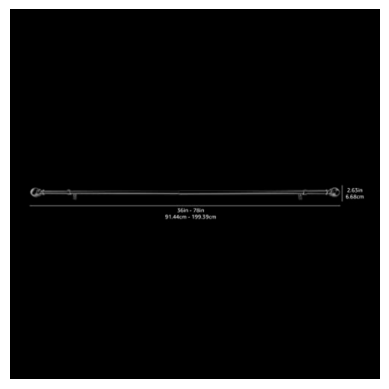

[([[1362, 720], [1432, 720], [1432, 748], [1362, 748]], '164', 0.09780878361207718), ([[1356, 748], [1438, 748], [1438, 774], [1356, 774]], '6e3cn', 0.06078914804110575), ([[674, 802], [728, 802], [728, 828], [674, 828]], 'Sbln', 0.12032317370176315), ([[624, 828], [720, 828], [720, 856], [624, 856]], 'S1an', 0.02692616917192936), ([[734, 828], [840, 828], [840, 856], [734, 856]], 'TSJon', 0.009310959487746684)]
first: ['164', '6e3cn', '', 'S1an', '']
before ['164', '6 e3 cn', 'S1 an']
before ['164', '6 e3 cn', 'S1 an']
No valid entity values found for height in image 110EibNyclL.jpg

Entity :  width
Original Image Dimensions: Width=1000, Height=65, Area=65000
Scaled Image Dimensions: Width=3000, Height=195


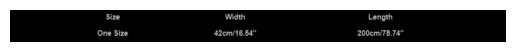

[([[575, 25], [670, 25], [670, 68], [575, 68]], 'Size', 0.9997336268424988), ([[1296, 21], [1429, 21], [1429, 69], [1296, 69]], 'Width', 0.9998868711488437), ([[2163, 24], [2321, 24], [2321, 79], [2163, 79]], 'Length', 0.9997485305630163), ([[522, 119], [721, 119], [721, 168], [522, 168]], 'One Size', 0.9060324344215943), ([[1228, 117], [1499, 117], [1499, 168], [1228, 168]], '42cm/16.54"', 0.9872334677435767), ([[2096, 117], [2391, 117], [2391, 167], [2096, 167]], '200cm/78.74"', 0.715572734861174)]
first: ['', '', '', '', '42cm/16.54 in', '200cm/78.74 in']
before ['42 cm', '16.54 in', '200 cm', '78.74 in']
before ['42 centimetre', '16.54 inch', '200 centimetre', '78.74 inch']
42.0
centimetre
16.54
inch
200.0
centimetre
78.74
inch
Best Entity Value for width: 42 centimetre

Entity :  height
Original Image Dimensions: Width=1000, Height=65, Area=65000
Scaled Image Dimensions: Width=3000, Height=195


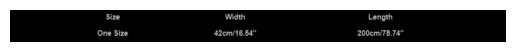

[([[575, 25], [670, 25], [670, 68], [575, 68]], 'Size', 0.9997336268424988), ([[1296, 21], [1429, 21], [1429, 69], [1296, 69]], 'Width', 0.9998868711488437), ([[2163, 24], [2321, 24], [2321, 79], [2163, 79]], 'Length', 0.9997485305630163), ([[522, 119], [721, 119], [721, 168], [522, 168]], 'One Size', 0.9060324344215943), ([[1228, 117], [1499, 117], [1499, 168], [1228, 168]], '42cm/16.54"', 0.9872334677435767), ([[2096, 117], [2391, 117], [2391, 167], [2096, 167]], '200cm/78.74"', 0.715572734861174)]
first: ['', '', '', '', '42cm/16.54 in', '200cm/78.74 in']
before ['42 cm', '16.54 in', '200 cm', '78.74 in']
before ['42 centimetre', '16.54 inch', '200 centimetre', '78.74 inch']
42.0
centimetre
16.54
inch
200.0
centimetre
78.74
inch
Best Entity Value for height: 200 centimetre

Entity :  depth
Original Image Dimensions: Width=1000, Height=65, Area=65000
Scaled Image Dimensions: Width=3000, Height=195


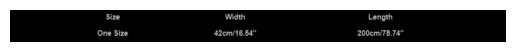

[([[575, 25], [670, 25], [670, 68], [575, 68]], 'Size', 0.9997336268424988), ([[1296, 21], [1429, 21], [1429, 69], [1296, 69]], 'Width', 0.9998868711488437), ([[2163, 24], [2321, 24], [2321, 79], [2163, 79]], 'Length', 0.9997485305630163), ([[522, 119], [721, 119], [721, 168], [522, 168]], 'One Size', 0.9060324344215943), ([[1228, 117], [1499, 117], [1499, 168], [1228, 168]], '42cm/16.54"', 0.9872334677435767), ([[2096, 117], [2391, 117], [2391, 167], [2096, 167]], '200cm/78.74"', 0.715572734861174)]
first: ['', '', '', '', '42cm/16.54 in', '200cm/78.74 in']
before ['42 cm', '16.54 in', '200 cm', '78.74 in']
before ['42 centimetre', '16.54 inch', '200 centimetre', '78.74 inch']
42.0
centimetre
16.54
inch
200.0
centimetre
78.74
inch
Best Entity Value for depth: 78.74 inch

Entity :  depth
Original Image Dimensions: Width=1000, Height=65, Area=65000
Scaled Image Dimensions: Width=3000, Height=195


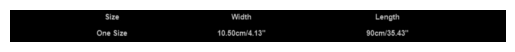

[([[571, 25], [668, 25], [668, 68], [571, 68]], 'Size', 0.9776234023667023), ([[1334, 19], [1466, 19], [1466, 69], [1334, 69]], 'Width', 0.9975938857788689), ([[2204, 20], [2365, 20], [2365, 81], [2204, 81]], 'Length', 0.9996993251841599), ([[521, 117], [716, 117], [716, 165], [521, 165]], 'One Size', 0.9998220915969882), ([[1249, 117], [1555, 117], [1555, 168], [1249, 168]], '10.50cm/4.13"', 0.6209247582581977), ([[2149, 117], [2418, 117], [2418, 165], [2149, 165]], '90cm/35 43"', 0.5797090914752894)]
first: ['', '', '', '', '10.50cm/4.13 in', '90cm/3543 in']
before ['10.50 cm', '4.13 in', '90 cm', '3543 in']
before ['10.50 centimetre', '4.13 inch', '90 centimetre', '3543 inch']
10.5
centimetre
4.13
inch
90.0
centimetre
3543.0
inch
Best Entity Value for depth: 90 centimetre

Entity :  height
Original Image Dimensions: Width=1000, Height=65, Area=65000
Scaled Image Dimensions: Width=3000, Height=195


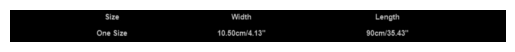

[([[571, 25], [668, 25], [668, 68], [571, 68]], 'Size', 0.9776234023667023), ([[1334, 19], [1466, 19], [1466, 69], [1334, 69]], 'Width', 0.9975938857788689), ([[2204, 20], [2365, 20], [2365, 81], [2204, 81]], 'Length', 0.9996993251841599), ([[521, 117], [716, 117], [716, 165], [521, 165]], 'One Size', 0.9998220915969882), ([[1249, 117], [1555, 117], [1555, 168], [1249, 168]], '10.50cm/4.13"', 0.6209247582581977), ([[2149, 117], [2418, 117], [2418, 165], [2149, 165]], '90cm/35 43"', 0.5797090914752894)]
first: ['', '', '', '', '10.50cm/4.13 in', '90cm/3543 in']
before ['10.50 cm', '4.13 in', '90 cm', '3543 in']
before ['10.50 centimetre', '4.13 inch', '90 centimetre', '3543 inch']
10.5
centimetre
4.13
inch
90.0
centimetre
3543.0
inch
Best Entity Value for height: 10.50 centimetre

Entity :  width
Original Image Dimensions: Width=1000, Height=65, Area=65000
Scaled Image Dimensions: Width=3000, Height=195


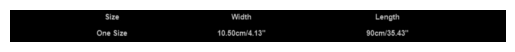

[([[571, 25], [668, 25], [668, 68], [571, 68]], 'Size', 0.9776234023667023), ([[1334, 19], [1466, 19], [1466, 69], [1334, 69]], 'Width', 0.9975938857788689), ([[2204, 20], [2365, 20], [2365, 81], [2204, 81]], 'Length', 0.9996993251841599), ([[521, 117], [716, 117], [716, 165], [521, 165]], 'One Size', 0.9998220915969882), ([[1249, 117], [1555, 117], [1555, 168], [1249, 168]], '10.50cm/4.13"', 0.6209247582581977), ([[2149, 117], [2418, 117], [2418, 165], [2149, 165]], '90cm/35 43"', 0.5797090914752894)]
first: ['', '', '', '', '10.50cm/4.13 in', '90cm/3543 in']
before ['10.50 cm', '4.13 in', '90 cm', '3543 in']
before ['10.50 centimetre', '4.13 inch', '90 centimetre', '3543 inch']
10.5
centimetre
4.13
inch
90.0
centimetre
3543.0
inch
Best Entity Value for width: 4.13 inch

Entity :  height
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


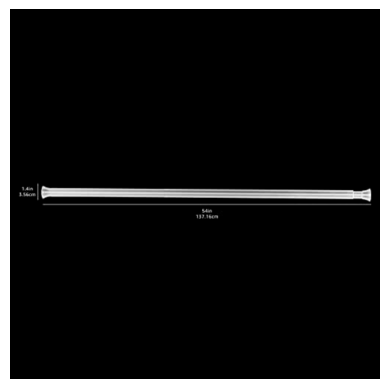

[([[61, 719], [97, 719], [97, 739], [61, 739]], 'm', 0.046932861857218455), ([[30, 740], [108, 740], [108, 764], [30, 764]], 'Jsbcin', 0.12138696642920174), ([[777, 807], [823, 807], [823, 827], [777, 827]], 'S9t', 0.008492913501709375), ([[748, 828], [848, 828], [848, 854], [748, 854]], '47 I6cm', 0.014655608600231792)]
first: ['', '', 'S9t', '47/6cm']
before ['S9 t', '47', '6 cm']
before ['S9 t', '47', '6 centimetre']
6.0
centimetre
Best Entity Value for height: 6 centimetre

Entity :  width
Original Image Dimensions: Width=1024, Height=1024, Area=1048576


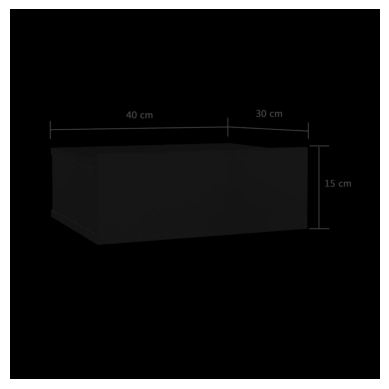

[([[318, 278], [398, 278], [398, 308], [318, 308]], '40 cm', 0.7147576665463414), ([[676, 276], [758, 276], [758, 304], [676, 304]], '30 cm', 0.6944086577872356), ([[868, 468], [948, 468], [948, 498], [868, 498]], '15 cm', 0.9310769711847038)]
first: ['40cm', '30cm', '15cm']
before ['40 cm', '30 cm', '15 cm']
before ['40 centimetre', '30 centimetre', '15 centimetre']
40.0
centimetre
30.0
centimetre
15.0
centimetre
Best Entity Value for width: 40 centimetre

Entity :  height
Original Image Dimensions: Width=1024, Height=1024, Area=1048576


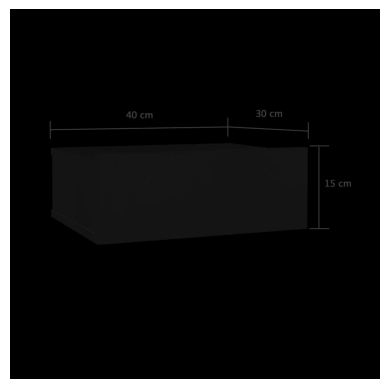

[([[318, 278], [398, 278], [398, 308], [318, 308]], '40 cm', 0.8192285908293347), ([[676, 276], [758, 276], [758, 304], [676, 304]], '30 cm', 0.6919035460161711), ([[868, 468], [948, 468], [948, 498], [868, 498]], '15 cm', 0.9617552782749854)]
first: ['40cm', '30cm', '15cm']
before ['40 cm', '30 cm', '15 cm']
before ['40 centimetre', '30 centimetre', '15 centimetre']
40.0
centimetre
30.0
centimetre
15.0
centimetre
Best Entity Value for height: 30 centimetre

Entity :  item_weight
Original Image Dimensions: Width=200, Height=200, Area=40000
Scaled Image Dimensions: Width=600, Height=600


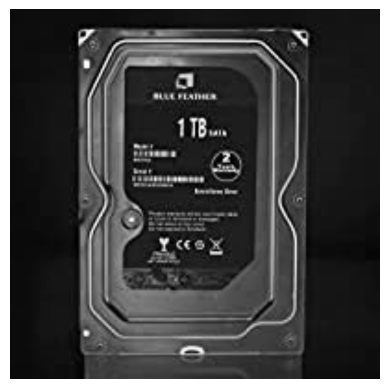

[([[263, 169], [327, 169], [327, 213], [263, 213]], '1TB', 0.8120269129381635), ([[261, 365], [351, 365], [351, 403], [261, 403]], '30 _', 0.16574807465076447)]
first: ['1TB', '30']
before ['1 TB', '30']
before ['1 TB', '30']
No valid entity values found for item_weight in image 213oP6n7jtL.jpg

Entity :  width
Original Image Dimensions: Width=500, Height=171, Area=85500
Scaled Image Dimensions: Width=1500, Height=513


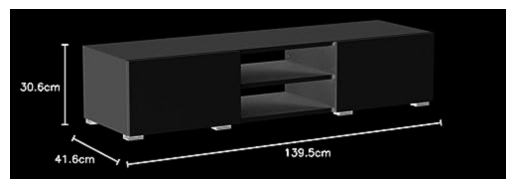

[([[25, 217], [157, 217], [157, 255], [25, 255]], 'J0 6cm', 0.6636211689340458), ([[825, 413], [977, 413], [977, 453], [825, 453]], '139,Scm', 0.953468232214615), ([[131, 435], [261, 435], [261, 473], [131, 473]], '41,6cm', 0.45485855592119284)]
first: ['J06cm', '139,Scm', '41,6cm']
before ['J06 cm', '139', 'Scm', '41', '6 cm']
before ['J06 centimetre', '139', 'Scm', '41', '6 centimetre']
6.0
centimetre
Best Entity Value for width: 6 centimetre

Entity :  depth
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


[([[980, 898], [1094, 898], [1094, 953], [980, 953]], '4.3in', 0.42652171871033634), ([[983, 953], [1097, 953], [1097, 997], [983, 997]], 'T0 cm', 0.20999555716463542)]
first: ['4.3in', 'T0cm']
before ['4.3 in', 'T0 cm']
before ['4.3 inch', 'T0 centimetre']
4.3
inch
Best Entity Value for depth: 4.3 inch

Entity :  height
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


[([[980, 898], [1094, 898], [1094, 953], [980, 953]], '4.3in', 0.42652171871033634), ([[983, 953], [1097, 953], [1097, 997], [983, 997]], 'T0 cm', 0.20999555716463542)]
first: ['4.3in', 'T0cm']
before ['4.3 in', 'T0 cm']
before ['4.3 inch', 'T0 centimetre']
4.3
inch
Best Entity Value for height: 4.3 inch

Entity :  width
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


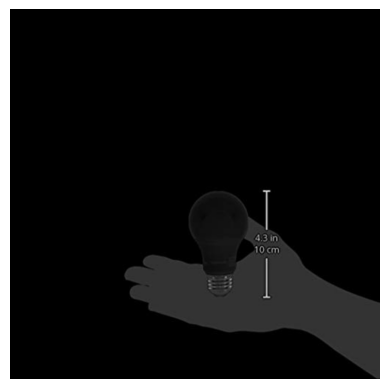

[([[980, 898], [1094, 898], [1094, 953], [980, 953]], '4.3in', 0.42652171871033634), ([[983, 953], [1097, 953], [1097, 997], [983, 997]], 'T0 cm', 0.20999555716463542)]
first: ['4.3in', 'T0cm']
before ['4.3 in', 'T0 cm']
before ['4.3 inch', 'T0 centimetre']
4.3
inch
Best Entity Value for width: 4.3 inch

Entity :  item_weight
Original Image Dimensions: Width=175, Height=175, Area=30625
Scaled Image Dimensions: Width=525, Height=525


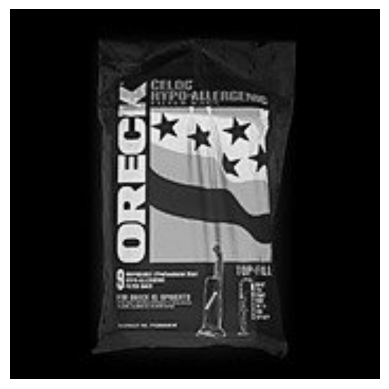

[([[143, 97], [205, 97], [205, 367], [143, 367]], '0', 0.06598821491934359)]
first: ['0']
before ['0']
before ['0']
No valid entity values found for item_weight in image 216rjgJHAeL.jpg

Entity :  maximum_weight_recommendation
Original Image Dimensions: Width=89, Height=500, Area=44500
Scaled Image Dimensions: Width=267, Height=1500


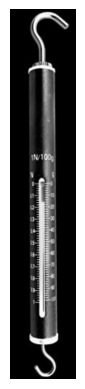

[([[79, 583], [141, 583], [141, 619], [79, 619]], 'JN I0', 0.09645309912839585), ([[74, 1280], [202, 1280], [202, 1490], [74, 1490]], '5', 0.9424469354328266), ([[134.02985749985467, 577.1194299994187], [187.6040066790364, 586.2647375249084], [179.97014250014533, 624.8805700005813], [126.3959933209636, 615.7352624750916]], 'I0o', 0.057316019427863074)]
first: ['/0', '5', '/0o']
before ['0', '5', '0 o']
before ['0', '5', '0 o']
No valid entity values found for maximum_weight_recommendation in image 2174yonQBtL.jpg

Entity :  item_weight
Original Image Dimensions: Width=500, Height=151, Area=75500
Scaled Image Dimensions: Width=1500, Height=453


[([[450, 96], [574, 96], [574, 144], [450, 144]], 'Black', 0.9886143478352325), ([[770, 96], [864, 96], [864, 146], [770, 146]], 'Red', 0.9599296450614929), ([[1065, 95], [1202, 95], [1202, 147], [1065, 147]], 'Green', 0.9999943489245257), ([[42, 130], [250, 130], [250, 178], [42, 178]], '208-240v', 0.3825308328241994), ([[96, 204], [190, 204], [190, 252], [96, 252]], '164', 0.6973614912113553), ([[1091, 163], [1177, 163], [1177, 279], [1091, 279]], '3', 0.19506367571777705), ([[86, 278], [206, 278], [206, 326], [86, 326]], '60Hz', 0.8986123204231262), ([[484, 286], [544, 286], [544, 334], [484, 334]], 'L1', 0.926614522496637), ([[788, 286], [852, 286], [852, 334], [788, 334]], 'L2', 0.9884807340260893), ([[1083, 291], [1187, 291], [1187, 335], [1083, 335]], 'GND', 0.9998111451750586), ([[450, 348], [574, 348], [574, 396], [450, 396]], 'Black', 0.864866623668415), ([[757, 347], [878, 347], [878, 398], [757, 398]], 'White', 0.9999819805197679), ([[1066, 346], [1202, 346], [1202, 394], [

[([[450, 96], [574, 96], [574, 144], [450, 144]], 'Black', 0.9886143478352325), ([[770, 96], [864, 96], [864, 146], [770, 146]], 'Red', 0.9599296450614929), ([[1065, 95], [1202, 95], [1202, 147], [1065, 147]], 'Green', 0.9999943489245257), ([[42, 130], [250, 130], [250, 178], [42, 178]], '208-240v', 0.3825308328241994), ([[96, 204], [190, 204], [190, 252], [96, 252]], '164', 0.6973614912113553), ([[1091, 163], [1177, 163], [1177, 279], [1091, 279]], '3', 0.19506367571777705), ([[86, 278], [206, 278], [206, 326], [86, 326]], '60Hz', 0.8986123204231262), ([[484, 286], [544, 286], [544, 334], [484, 334]], 'L1', 0.926614522496637), ([[788, 286], [852, 286], [852, 334], [788, 334]], 'L2', 0.9884807340260893), ([[1083, 291], [1187, 291], [1187, 335], [1083, 335]], 'GND', 0.9998111451750586), ([[450, 348], [574, 348], [574, 396], [450, 396]], 'Black', 0.864866623668415), ([[757, 347], [878, 347], [878, 398], [757, 398]], 'White', 0.9999819805197679), ([[1066, 346], [1202, 346], [1202, 394], [

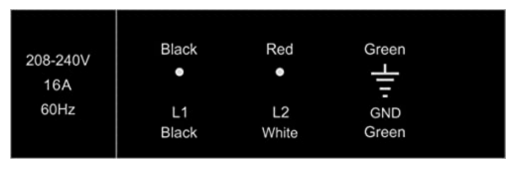

[([[450, 96], [574, 96], [574, 144], [450, 144]], 'Black', 0.9886143478352325), ([[770, 96], [864, 96], [864, 146], [770, 146]], 'Red', 0.9599296450614929), ([[1065, 95], [1202, 95], [1202, 147], [1065, 147]], 'Green', 0.9999943489245257), ([[42, 130], [250, 130], [250, 178], [42, 178]], '208-240v', 0.3825308328241994), ([[96, 204], [190, 204], [190, 252], [96, 252]], '164', 0.6973614912113553), ([[1091, 163], [1177, 163], [1177, 279], [1091, 279]], '3', 0.19506367571777705), ([[86, 278], [206, 278], [206, 326], [86, 326]], '60Hz', 0.8986123204231262), ([[484, 286], [544, 286], [544, 334], [484, 334]], 'L1', 0.926614522496637), ([[788, 286], [852, 286], [852, 334], [788, 334]], 'L2', 0.9884807340260893), ([[1083, 291], [1187, 291], [1187, 335], [1083, 335]], 'GND', 0.9998111451750586), ([[450, 348], [574, 348], [574, 396], [450, 396]], 'Black', 0.864866623668415), ([[757, 347], [878, 347], [878, 398], [757, 398]], 'White', 0.9999819805197679), ([[1066, 346], [1202, 346], [1202, 394], [

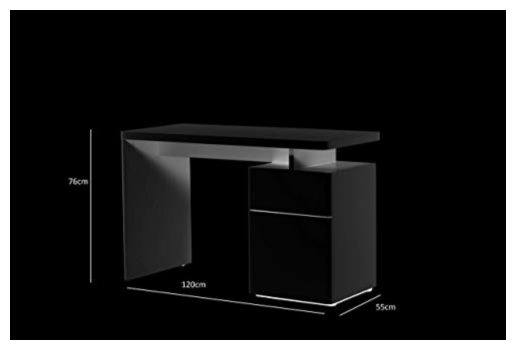

[([[172, 506], [240, 506], [240, 534], [172, 534]], 'Jim', 0.05428909957090117), ([[512, 816], [596, 816], [596, 844], [512, 844]], 'Tzucin', 0.08202240030347009), ([[1102, 886], [1170, 886], [1170, 912], [1102, 912]], 'S5cm', 0.6169125437736511)]
first: ['', '', 'S5cm']
before ['S5 cm']
before ['S5 centimetre']
No valid entity values found for width in image 21BMc5GC4iL.jpg

Entity :  width
Original Image Dimensions: Width=500, Height=280, Area=140000
Scaled Image Dimensions: Width=1500, Height=840


[([[349, 667], [397, 667], [397, 707], [349, 707]], '38', 0.996718171437027), ([[448.0, 235.0], [508.19210502924346, 202.654155481681], [526.0, 235.0], [465.80789497075654, 267.34584451831904]], '74"', 0.983350180452741)]
first: ['38', '74 in']
before ['38', '74 in']
before ['38', '74 inch']
74.0
inch
Best Entity Value for width: 74 inch

Entity :  item_volume
Original Image Dimensions: Width=190, Height=246, Area=46740
Scaled Image Dimensions: Width=570, Height=738


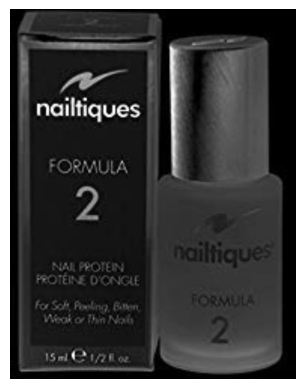

[([[38, 157], [273, 157], [273, 241], [38, 241]], 'nailtiques', 0.9921675069524802), ([[67, 287], [242, 287], [242, 337], [67, 337]], 'FORMULA', 0.9025266322770905), ([[125, 349], [187, 349], [187, 427], [125, 427]], '2', 1.0), ([[77, 496], [235, 496], [235, 533], [77, 533]], 'ANFPO EN', 0.0015041687160547356), ([[315, 457], [533, 457], [533, 521], [315, 521]], 'ellicpes', 0.23307906474702353), ([[44, 521], [267, 521], [267, 559], [44, 559]], 'Koiel ! DCNCIE', 0.0469883724932903), ([[43, 573], [259, 573], [259, 612], [43, 612]], 'foso" Rlng Fn', 0.051989686229466), ([[352, 558], [495, 558], [495, 602], [352, 602]], 'Toom |0', 0.0481113666101247), ([[62, 604], [250, 604], [250, 632], [62, 632]], 'Kcdro Mnu', 0.0016851722605546468), ([[397, 607], [441, 607], [441, 669], [397, 669]], '2', 1.0), ([[64, 680], [120, 680], [120, 708], [64, 708]], 'Snl', 0.12383670862286332), ([[114, 673], [248, 673], [248, 716], [114, 716]], 'einie', 0.2279422698711481)]
first: ['', '', '2', '', '', '', '', '

[([[993, 631], [1031, 631], [1031, 757], [993, 757]], '1', 0.5238880844992764), ([[665, 1427], [799, 1427], [799, 1469], [665, 1469]], '032 cm', 0.8406687756175142)]
first: ['1', '032cm']
before ['1', '032 cm']
before ['1', '032 centimetre']
32.0
centimetre
Best Entity Value for width: 032 centimetre

Entity :  depth
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


[([[993, 631], [1031, 631], [1031, 757], [993, 757]], '1', 0.5238880844992764), ([[665, 1427], [799, 1427], [799, 1469], [665, 1469]], '032 cm', 0.8406687756175142)]
first: ['1', '032cm']
before ['1', '032 cm']
before ['1', '032 centimetre']
32.0
centimetre
Best Entity Value for depth: 032 centimetre

Entity :  width
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


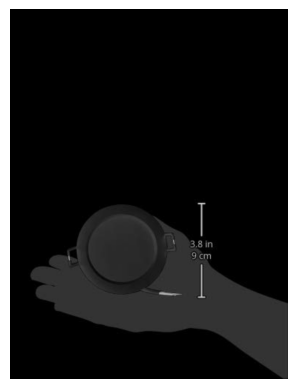

[([[725, 933], [827, 933], [827, 973], [725, 973]], '3.8in', 0.9299326264697082), ([[729, 981], [821, 981], [821, 1021], [729, 1021]], '9 cm', 0.6836675405502319)]
first: ['3.8in', '9cm']
before ['3.8 in', '9 cm']
before ['3.8 inch', '9 centimetre']
3.8
inch
9.0
centimetre
Best Entity Value for width: 3.8 inch

Entity :  depth
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


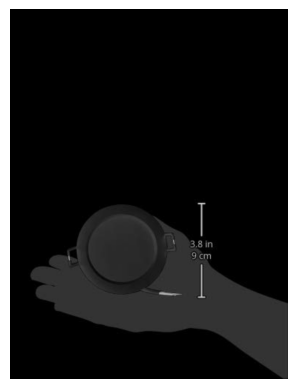

[([[725, 933], [827, 933], [827, 973], [725, 973]], '3.8in', 0.9299326264697082), ([[729, 981], [821, 981], [821, 1021], [729, 1021]], '9 cm', 0.6836675405502319)]
first: ['3.8in', '9cm']
before ['3.8 in', '9 cm']
before ['3.8 inch', '9 centimetre']
3.8
inch
9.0
centimetre
Best Entity Value for depth: 9 centimetre

Entity :  item_weight
Original Image Dimensions: Width=113, Height=150, Area=16950
Scaled Image Dimensions: Width=339, Height=450


[([[108, 96], [180, 96], [180, 126], [108, 126]], '33050', 0.4022572371341014)]
first: ['33050']
before ['33050']
before ['33050']
No valid entity values found for item_weight in image 21IGmiJi-PL.jpg

Entity :  item_weight
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


[([[1200, 798], [1376, 798], [1376, 830], [1200, 830]], 'Im-I3b0rn', 0.016410439558539398), ([[1198, 834], [1288, 834], [1288, 866], [1198, 866]], '9.56', 0.3051198124885559), ([[1198, 868], [1314, 868], [1314, 900], [1198, 900]], '0 G3pa', 0.33256080831812196)]
first: ['Im-/3b0rn', '9.56', '0G3pa']
before ['Im-', '3 b0 rn', '9.56', '0 G3 pa']
before ['Im-', '3 b0 rn', '9.56', '0 G3 pa']
No valid entity values found for item_weight in image 21Is45vdL0L.jpg

Entity :  item_weight
Original Image Dimensions: Width=500, Height=224, Area=112000
Scaled Image Dimensions: Width=1500, Height=672


[([[537, 41], [617, 41], [617, 85], [537, 85]], '16"', 0.9999975911073493), ([[844, 40], [1020, 40], [1020, 88], [844, 88]], '2.62 Ibs', 0.9257660074060184), ([[568, 106], [640, 106], [640, 130], [568, 130]], 'Sat', 0.022778606204050526), ([[814, 104], [1043, 104], [1043, 135], [814, 135]], 'Ulta Uancit Pody', 0.043558271733701644), ([[512.9909908090056, 103.17477426521549], [573.8954209833099, 111.21480108927189], [570.0090091909944, 136.8252257347845], [509.1045790166901, 128.78519891072813]], 'J9', 0.027390655935259436)]
first: ['16 in', '2.62Ibs', '', '', 'J9']
before ['16 in', '2.62 Ibs', 'J9']
before ['16 in', '2.62 Ibs', 'J9']
No valid entity values found for item_weight in image 21Raw7jSIML.jpg

Entity :  item_weight
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


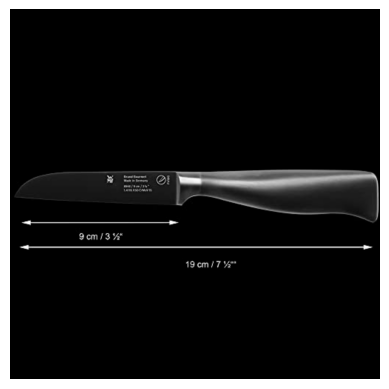

[([[589, 669], [653, 669], [653, 713], [589, 713]], '0', 0.8556363797566178), ([[303, 901], [463, 901], [463, 943], [303, 943]], 'cm /3 %"', 0.43597251014211136), ([[705, 1013], [921, 1013], [921, 1055], [705, 1055]], '19 cm/7%7""', 0.2778680051291584)]
first: ['0', '/3% in', '19cm/7%7 in in']
before ['0', '3% in', '19 cm', '7%7 in in']
before ['0', '3% in', '19 cm', '7%7 in in']
No valid entity values found for item_weight in image 21Vc5ixqKpS.jpg

Entity :  item_weight
Original Image Dimensions: Width=500, Height=434, Area=217000
Scaled Image Dimensions: Width=1500, Height=1302


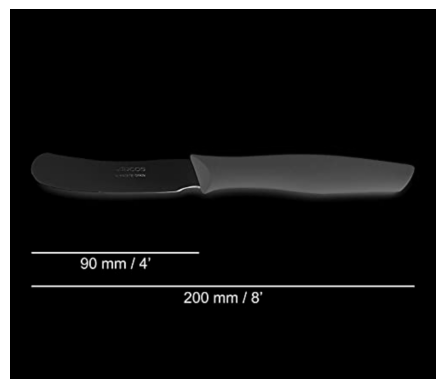

[([[381, 553], [471, 553], [471, 573], [381, 573]], 'Jo~', 0.007504817593608436), ([[240, 866], [502, 866], [502, 922], [240, 922]], "90 mm /4'", 0.753723636439781), ([[605, 985], [897, 985], [897, 1045], [605, 1045]], "200 mm / 8'", 0.9804346322722686)]
first: ['', '90mm /4', '200mm']
before ['90 mm', '4', '200 mm']
before ['90 mm', '4', '200 mm']
No valid entity values found for item_weight in image 21W7FvftSCL.jpg

Entity :  width
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


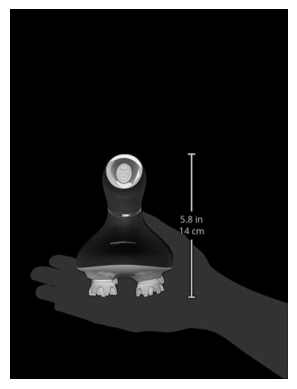

[([[685, 833], [787, 833], [787, 873], [685, 873]], '5.8 in', 0.8648462853353494), ([[681, 881], [789, 881], [789, 921], [681, 921]], '14cm', 0.20194536447525024)]
first: ['5.8in', '14cm']
before ['5.8 in', '14 cm']
before ['5.8 inch', '14 centimetre']
5.8
inch
14.0
centimetre
Best Entity Value for width: 14 centimetre

Entity :  depth
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


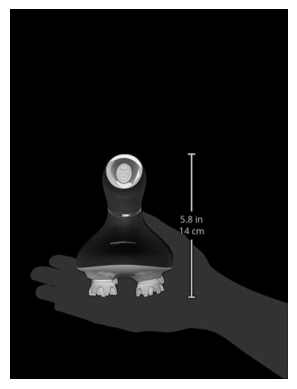

[([[685, 833], [787, 833], [787, 873], [685, 873]], '5.8 in', 0.8648462853353494), ([[681, 881], [789, 881], [789, 921], [681, 921]], '14cm', 0.20194536447525024)]
first: ['5.8in', '14cm']
before ['5.8 in', '14 cm']
before ['5.8 inch', '14 centimetre']
5.8
inch
14.0
centimetre
Best Entity Value for depth: 5.8 inch

Entity :  height
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


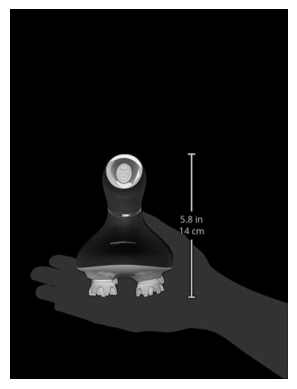

[([[685, 833], [787, 833], [787, 873], [685, 873]], '5.8 in', 0.8648462853353494), ([[681, 881], [789, 881], [789, 921], [681, 921]], '14cm', 0.20194536447525024)]
first: ['5.8in', '14cm']
before ['5.8 in', '14 cm']
before ['5.8 inch', '14 centimetre']
5.8
inch
14.0
centimetre
Best Entity Value for height: 14 centimetre

Entity :  item_weight
Original Image Dimensions: Width=160, Height=160, Area=25600
Scaled Image Dimensions: Width=480, Height=480


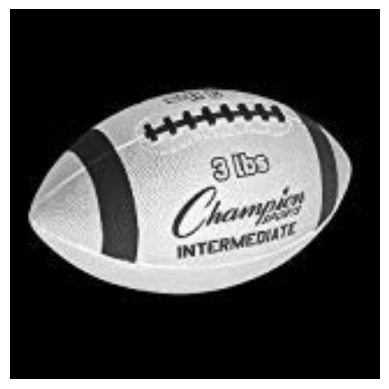

[([[206, 224], [390, 224], [390, 300], [206, 300]], 'Chancii', 0.1810745937586094), ([[247.4203985176459, 184.58283688705643], [340.73280174107106, 167.31210253942513], [347.57960148235406, 216.41716311294357], [254.26719825892891, 234.68789746057487]], '31', 0.4873546111057301), ([[205.54230423844288, 303.27961296691], [376.7995884125512, 268.9218976299492], [382.45769576155715, 299.72038703309], [210.2004115874488, 333.0781023700508]], 'INTERHEDATI', 0.30715723727427435)]
first: ['', '31', '']
before ['31']
before ['31']
No valid entity values found for item_weight in image 21bfrFeArAL.jpg

Entity :  height
Original Image Dimensions: Width=500, Height=129, Area=64500
Scaled Image Dimensions: Width=1500, Height=387


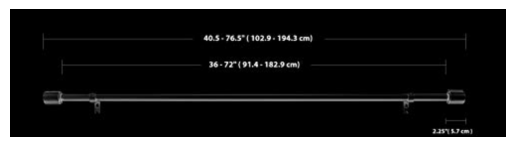

[([[582, 74], [920, 74], [920, 102], [582, 102]], '405.705 [102.9. 194 3 cm', 0.14627428343643725), ([[596, 154], [882, 154], [882, 182], [596, 182]], '367ri -18l ,Emn}', 0.0036379480284156568), ([[1272, 358], [1402, 358], [1402, 382], [1272, 382]], 'Jasiem]', 0.015655470123305953)]
first: ['405.705[102.9.cm', '367ri -18l', '']
before ['405.705[102.9.cm', '367 ri -18 l']
before ['405.705[102.9.cm', '367 ri -18 l']
No valid entity values found for height in image 21bwWoCpGJL.jpg

Entity :  voltage
Original Image Dimensions: Width=500, Height=26, Area=13000
Scaled Image Dimensions: Width=1500, Height=78


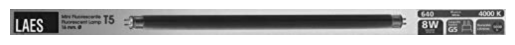

[([[1249, 7], [1285, 7], [1285, 25], [1249, 25]], 'AQ', 0.024131178178787276), ([[1412, 0], [1490, 0], [1490, 26], [1412, 26]], '4LL', 0.07539960286511069), ([[9, 18], [110, 18], [110, 78], [9, 78]], 'LAES', 0.9996180534362793), ([[237, 33], [277, 33], [277, 49], [237, 49]], '[7o', 0.2026622069170003), ([[275, 13], [323, 13], [323, 51], [275, 51]], 'T5', 0.8752833951933727), ([[1240, 32], [1302, 32], [1302, 62], [1240, 62]], 'BWV', 0.403942651217181), ([[1323, 51], [1357, 51], [1357, 71], [1323, 71]], '05', 0.5765152510468586)]
first: ['', '4LL', '', '[7o', 'T5', '', '05']
before ['4 LL', '[7 o', 'T5', '05']
before ['4 LL', '[7 o', 'T5', '05']
No valid entity values found for voltage in image 21cLufe8Y5L.jpg

Entity :  wattage
Original Image Dimensions: Width=500, Height=26, Area=13000
Scaled Image Dimensions: Width=1500, Height=78


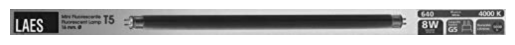

[([[1249, 7], [1285, 7], [1285, 25], [1249, 25]], 'AQ', 0.024131178178787276), ([[1412, 0], [1490, 0], [1490, 26], [1412, 26]], '4LL', 0.07539960286511069), ([[9, 18], [110, 18], [110, 78], [9, 78]], 'LAES', 0.9996180534362793), ([[237, 33], [277, 33], [277, 49], [237, 49]], '[7o', 0.2026622069170003), ([[275, 13], [323, 13], [323, 51], [275, 51]], 'T5', 0.8752833951933727), ([[1240, 32], [1302, 32], [1302, 62], [1240, 62]], 'BWV', 0.403942651217181), ([[1323, 51], [1357, 51], [1357, 71], [1323, 71]], '05', 0.5765152510468586)]
first: ['', '4LL', '', '[7o', 'T5', '', '05']
before ['4 LL', '[7 o', 'T5', '05']
before ['4 LL', '[7 o', 'T5', '05']
No valid entity values found for wattage in image 21cLufe8Y5L.jpg

Entity :  depth
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


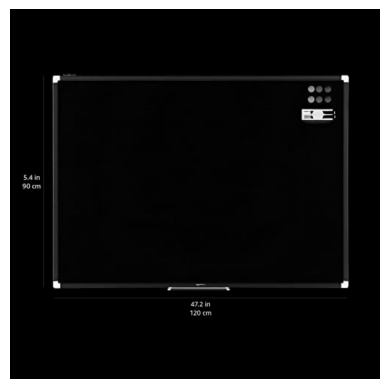

[([[50, 668], [128, 668], [128, 700], [50, 700]], '54in', 0.8370844990687593), ([[46, 702], [128, 702], [128, 734], [46, 734]], '90cmn', 0.056825414620830246), ([[730, 1182], [818, 1182], [818, 1212], [730, 1212]], '4zIn', 0.28197115659713745), ([[726, 1218], [820, 1218], [820, 1248], [726, 1248]], 'IZ0 cM', 0.5299504670364333)]
first: ['54in', '90cmn', '4zIn', 'IZ0cM']
before ['54 in', '90 cmn', '4 zIn', 'IZ0 cM']
before ['54 inch', '90 cmn', '4 zIn', 'IZ0 cM']
54.0
inch
Best Entity Value for depth: 54 inch

Entity :  width
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


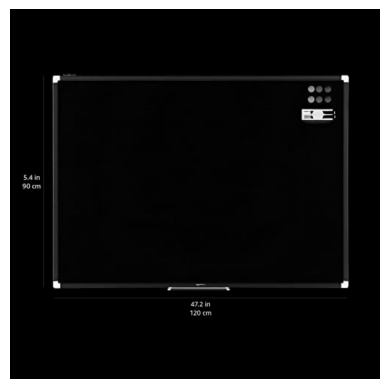

[([[50, 668], [128, 668], [128, 700], [50, 700]], '54in', 0.8370844990687593), ([[46, 702], [128, 702], [128, 734], [46, 734]], '90cmn', 0.056825414620830246), ([[730, 1182], [818, 1182], [818, 1212], [730, 1212]], '4zIn', 0.28197115659713745), ([[726, 1218], [820, 1218], [820, 1248], [726, 1248]], 'IZ0 cM', 0.5299504670364333)]
first: ['54in', '90cmn', '4zIn', 'IZ0cM']
before ['54 in', '90 cmn', '4 zIn', 'IZ0 cM']
before ['54 inch', '90 cmn', '4 zIn', 'IZ0 cM']
54.0
inch
Best Entity Value for width: 54 inch

Entity :  height
Original Image Dimensions: Width=500, Height=251, Area=125500
Scaled Image Dimensions: Width=1500, Height=753


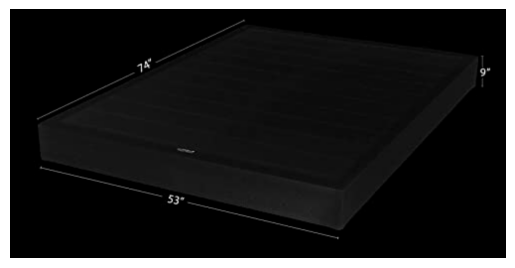

[([[1418, 176], [1442, 176], [1442, 204], [1418, 204]], '9', 0.9997837660393003), ([[369.0, 171.0], [429.25873566236794, 139.69877095500067], [446.0, 171.0], [385.74126433763206, 203.30122904499933]], '74"', 0.9969092050036766), ([[475.0939460213589, 552.1039678918432], [535.7502648736397, 564.6087727081659], [526.9060539786411, 602.8960321081568], [466.2497351263603, 590.3912272918341]], '53"', 0.9998643461418842)]
first: ['9', '74 in', '53 in']
before ['9', '74 in', '53 in']
before ['9', '74 inch', '53 inch']
74.0
inch
53.0
inch
Best Entity Value for height: 53 inch

Entity :  width
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


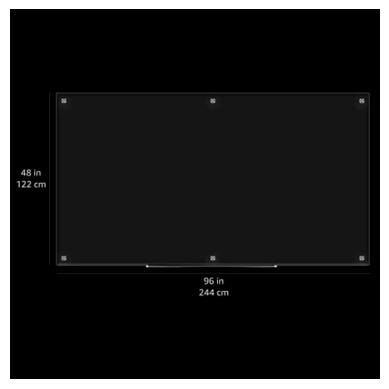

[([[39, 645], [133, 645], [133, 683], [39, 683]], '48 in', 0.9107846680981337), ([[23, 691], [151, 691], [151, 729], [23, 729]], '122 cm', 0.9538614475968341), ([[779, 1081], [873, 1081], [873, 1123], [779, 1123]], '96 in', 0.99956005782808), ([[763, 1131], [893, 1131], [893, 1169], [763, 1169]], '244 cm', 0.9135293114133842)]
first: ['48in', '122cm', '96in', '244cm']
before ['48 in', '122 cm', '96 in', '244 cm']
before ['48 inch', '122 centimetre', '96 inch', '244 centimetre']
48.0
inch
122.0
centimetre
96.0
inch
244.0
centimetre
Best Entity Value for width: 96 inch

Entity :  height
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


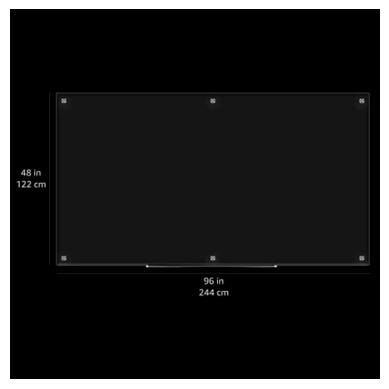

[([[39, 645], [133, 645], [133, 683], [39, 683]], '48 in', 0.9107846680981337), ([[23, 691], [151, 691], [151, 729], [23, 729]], '122 cm', 0.9538614475968341), ([[779, 1081], [873, 1081], [873, 1123], [779, 1123]], '96 in', 0.99956005782808), ([[763, 1131], [893, 1131], [893, 1169], [763, 1169]], '244 cm', 0.9135293114133842)]
first: ['48in', '122cm', '96in', '244cm']
before ['48 in', '122 cm', '96 in', '244 cm']
before ['48 inch', '122 centimetre', '96 inch', '244 centimetre']
48.0
inch
122.0
centimetre
96.0
inch
244.0
centimetre
Best Entity Value for height: 122 centimetre

Entity :  height
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


[([[252, 822], [334, 822], [334, 852], [252, 852]], 'G0em', 0.1656033992767334), ([[250, 860], [340, 860], [340, 890], [250, 890]], '23,6 In', 0.2026174652229879), ([[450, 1296], [530, 1296], [530, 1326], [450, 1326]], '45 Liti', 0.2584485382465628), ([[444, 1330], [534, 1330], [534, 1358], [444, 1358]], '177in', 0.4263349007042091), ([[996, 1328], [1076, 1328], [1076, 1358], [996, 1358]], '41M', 0.7099918368147375), ([[992, 1362], [1080, 1362], [1080, 1392], [992, 1392]], 'J6]in', 0.22824122378188377)]
first: ['G0em', '23,6In', '45Liti', '177in', '41M', 'J6]in']
before ['G0 em', '23', '6 In', '45 Liti', '177 in', '41 M', 'J6]in']
before ['G0 em', '23', '6 In', '45 Liti', '177 inch', '41 metre', 'J6]in']
177.0
inch
41.0
metre
Best Entity Value for height: 177 inch

Entity :  depth
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


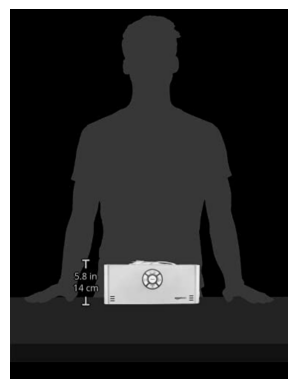

[([[285, 1009], [329, 1009], [329, 1057], [285, 1057]], 'T', 0.9269796432906539), ([[255, 1061], [359, 1061], [359, 1105], [255, 1105]], '5.8 in', 0.6830269443738237), ([[247, 1109], [363, 1109], [363, 1151], [247, 1151]], 'J4cm', 0.45628121495246887)]
first: ['', '5.8in', 'J4cm']
before ['5.8 in', 'J4 cm']
before ['5.8 inch', 'J4 centimetre']
5.8
inch
Best Entity Value for depth: 5.8 inch

Entity :  height
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


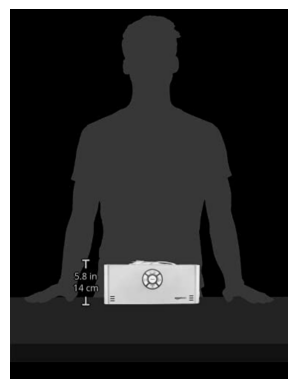

[([[285, 1009], [329, 1009], [329, 1057], [285, 1057]], 'T', 0.9269796432906539), ([[255, 1061], [359, 1061], [359, 1105], [255, 1105]], '5.8 in', 0.6830269443738237), ([[247, 1109], [363, 1109], [363, 1151], [247, 1151]], 'J4cm', 0.45628121495246887)]
first: ['', '5.8in', 'J4cm']
before ['5.8 in', 'J4 cm']
before ['5.8 inch', 'J4 centimetre']
5.8
inch
Best Entity Value for height: 5.8 inch

Entity :  width
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


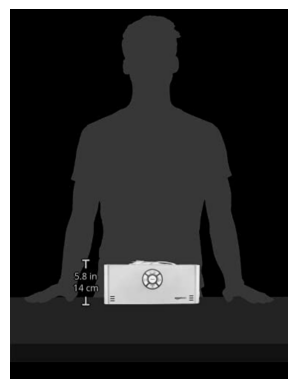

[([[285, 1009], [329, 1009], [329, 1057], [285, 1057]], 'T', 0.9269796432906539), ([[255, 1061], [359, 1061], [359, 1105], [255, 1105]], '5.8 in', 0.6830269443738237), ([[247, 1109], [363, 1109], [363, 1151], [247, 1151]], 'J4cm', 0.45628121495246887)]
first: ['', '5.8in', 'J4cm']
before ['5.8 in', 'J4 cm']
before ['5.8 inch', 'J4 centimetre']
5.8
inch
Best Entity Value for width: 5.8 inch

Entity :  width
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


[([[74, 626], [144, 626], [144, 658], [74, 658]], '35in', 0.44155845046043396), ([[66, 662], [148, 662], [148, 692], [66, 692]], 'Jocm', 0.5648300647735596), ([[788, 1222], [858, 1222], [858, 1250], [788, 1250]], '47in', 0.9146072864532471), ([[774, 1256], [872, 1256], [872, 1286], [774, 1286]], 'Jz0 cm', 0.17586841801075045)]
first: ['35in', '', '47in', 'Jz0cm']
before ['35 in', '47 in', 'Jz0 cm']
before ['35 inch', '47 inch', 'Jz0 centimetre']
35.0
inch
47.0
inch
Best Entity Value for width: 47 inch

Entity :  depth
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


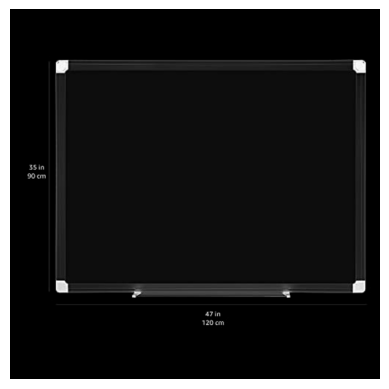

[([[74, 626], [144, 626], [144, 658], [74, 658]], '35in', 0.44155845046043396), ([[66, 662], [148, 662], [148, 692], [66, 692]], 'Jocm', 0.5648300647735596), ([[788, 1222], [858, 1222], [858, 1250], [788, 1250]], '47in', 0.9146072864532471), ([[774, 1256], [872, 1256], [872, 1286], [774, 1286]], 'Jz0 cm', 0.17586841801075045)]
first: ['35in', '', '47in', 'Jz0cm']
before ['35 in', '47 in', 'Jz0 cm']
before ['35 inch', '47 inch', 'Jz0 centimetre']
35.0
inch
47.0
inch
Best Entity Value for depth: 35 inch

Entity :  height
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


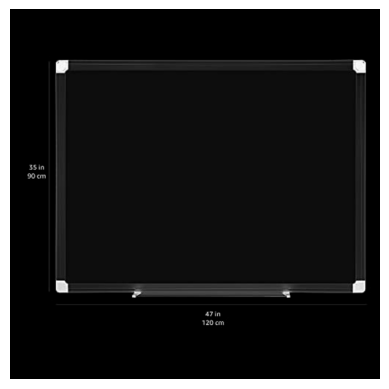

[([[74, 626], [144, 626], [144, 658], [74, 658]], '35in', 0.44155845046043396), ([[66, 662], [148, 662], [148, 692], [66, 692]], 'Jocm', 0.5648300647735596), ([[788, 1222], [858, 1222], [858, 1250], [788, 1250]], '47in', 0.9146072864532471), ([[774, 1256], [872, 1256], [872, 1286], [774, 1286]], 'Jz0 cm', 0.17586841801075045)]
first: ['35in', '', '47in', 'Jz0cm']
before ['35 in', '47 in', 'Jz0 cm']
before ['35 inch', '47 inch', 'Jz0 centimetre']
35.0
inch
47.0
inch
Best Entity Value for height: 35 inch

Entity :  item_weight
Original Image Dimensions: Width=500, Height=81, Area=40500
Scaled Image Dimensions: Width=1500, Height=243


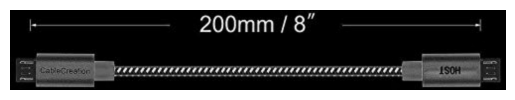

[([[565, 2], [934, 2], [934, 81], [565, 81]], '200mm / 8"', 0.654412884239691), ([[85, 169], [246, 169], [246, 199], [85, 199]], 'LANe Creatol;', 0.1208733108817028), ([[1294, 168], [1370, 168], [1370, 200], [1294, 200]], 'ISOH', 0.48584234714508057)]
first: ['200mm in', '', '']
before ['200 mm in']
before ['200 mm in']
No valid entity values found for item_weight in image 21pFwZ8ghkL.jpg

Entity :  wattage
Original Image Dimensions: Width=500, Height=81, Area=40500
Scaled Image Dimensions: Width=1500, Height=243


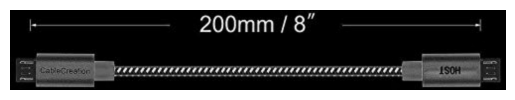

[([[565, 2], [934, 2], [934, 81], [565, 81]], '200mm / 8"', 0.654412884239691), ([[85, 169], [246, 169], [246, 199], [85, 199]], 'LANe Creatol;', 0.1208733108817028), ([[1294, 168], [1370, 168], [1370, 200], [1294, 200]], 'ISOH', 0.48584234714508057)]
first: ['200mm in', '', '']
before ['200 mm in']
before ['200 mm in']
No valid entity values found for wattage in image 21pFwZ8ghkL.jpg

Entity :  depth
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


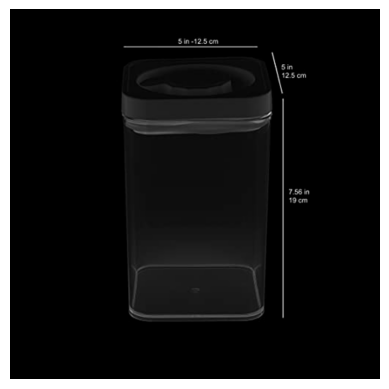

[([[676, 116], [850, 116], [850, 148], [676, 148]], '5in-125cm', 0.1118676662420313), ([[1096, 220], [1152, 220], [1152, 252], [1096, 252]], 'Sin', 0.7369604968844085), ([[1098, 254], [1204, 254], [1204, 286], [1098, 286]], '425cm', 0.16859953878548906), ([[1126, 726], [1220, 726], [1220, 758], [1126, 758]], '7 56 In', 0.5912392866991834), ([[1128, 760], [1212, 760], [1212, 792], [1128, 792]], 'JJcm', 0.12792828679084778)]
first: ['5in-125cm', '', '425cm', '756In', '']
before ['5 in-125 cm', '425 cm', '756 In']
before ['5 in-125 centimetre', '425 centimetre', '756 In']
425.0
centimetre
Best Entity Value for depth: 425 centimetre

Entity :  height
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


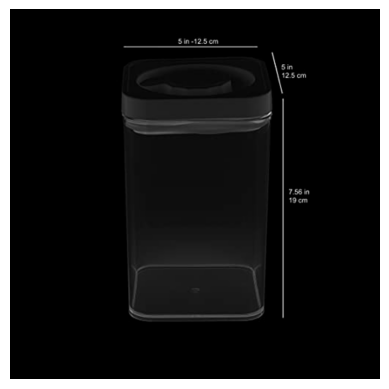

[([[676, 116], [850, 116], [850, 148], [676, 148]], '5in-125cm', 0.1118676662420313), ([[1096, 220], [1152, 220], [1152, 252], [1096, 252]], 'Sin', 0.7369604968844085), ([[1098, 254], [1204, 254], [1204, 286], [1098, 286]], '425cm', 0.16859953878548906), ([[1126, 726], [1220, 726], [1220, 758], [1126, 758]], '7 56 In', 0.5912392866991834), ([[1128, 760], [1212, 760], [1212, 792], [1128, 792]], 'JJcm', 0.12792828679084778)]
first: ['5in-125cm', '', '425cm', '756In', '']
before ['5 in-125 cm', '425 cm', '756 In']
before ['5 in-125 centimetre', '425 centimetre', '756 In']
425.0
centimetre
Best Entity Value for height: 425 centimetre

Entity :  width
Original Image Dimensions: Width=500, Height=232, Area=116000
Scaled Image Dimensions: Width=1500, Height=696


[([[1312, 94], [1416, 94], [1416, 198], [1312, 198]], '[12-', 0.17420192705527382), ([[1399, 133], [1479, 133], [1479, 171], [1399, 171]], 'Zcm', 0.9593062325234069), ([[1044, 441], [1216, 441], [1216, 481], [1044, 481]], '187.96cm', 0.6060770255996559), ([[311, 572], [464, 572], [464, 612], [311, 612]], '96.52cm', 0.8660907543597859)]
first: ['[12', '', '187.96cm', '96.52cm']
before ['[12', '187.96 cm', '96.52 cm']
before ['[12', '187.96 centimetre', '96.52 centimetre']
187.96
centimetre
96.52
centimetre
Best Entity Value for width: 96.52 centimetre

Entity :  item_weight
Original Image Dimensions: Width=120, Height=109, Area=13080
Scaled Image Dimensions: Width=360, Height=327


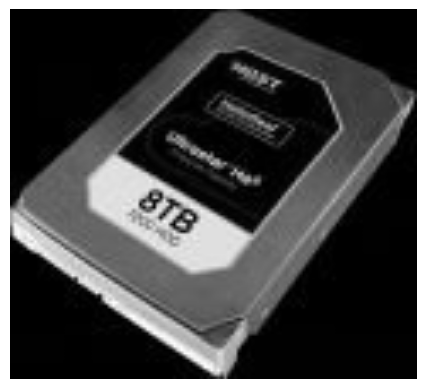

[([[120.33156707956985, 145.05624576946215], [178.9963315832707, 179.82872864643124], [159.66843292043015, 211.94375423053785], [101.00366841672933, 177.17127135356876]], '818', 0.9930835643915131)]
first: ['818']
before ['818']
before ['818']
No valid entity values found for item_weight in image 21qleENrBBL.jpg

Entity :  depth
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


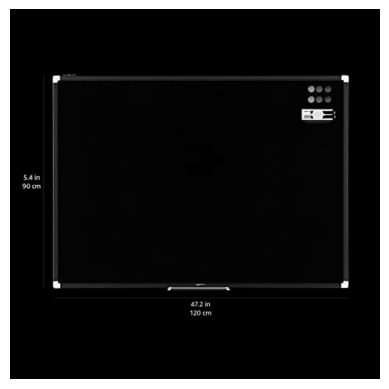

[([[50, 668], [128, 668], [128, 700], [50, 700]], '54in', 0.7947894827585713), ([[46, 702], [128, 702], [128, 734], [46, 734]], '90cm', 0.20611460506916046), ([[730, 1182], [818, 1182], [818, 1212], [730, 1212]], 'LzIn', 0.18017356097698212), ([[726, 1216], [820, 1216], [820, 1248], [726, 1248]], 'IZ0 cM', 0.5178538614198304)]
first: ['54in', '90cm', '', 'IZ0cM']
before ['54 in', '90 cm', 'IZ0 cM']
before ['54 inch', '90 centimetre', 'IZ0 cM']
54.0
inch
90.0
centimetre
Best Entity Value for depth: 54 inch

Entity :  width
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


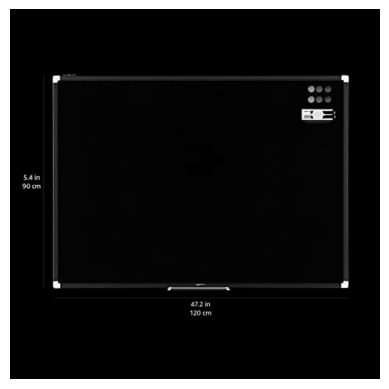

[([[50, 668], [128, 668], [128, 700], [50, 700]], '54in', 0.7947894827585713), ([[46, 702], [128, 702], [128, 734], [46, 734]], '90cm', 0.20611460506916046), ([[730, 1182], [818, 1182], [818, 1212], [730, 1212]], 'LzIn', 0.18017356097698212), ([[726, 1216], [820, 1216], [820, 1248], [726, 1248]], 'IZ0 cM', 0.5178538614198304)]
first: ['54in', '90cm', '', 'IZ0cM']
before ['54 in', '90 cm', 'IZ0 cM']
before ['54 inch', '90 centimetre', 'IZ0 cM']
54.0
inch
90.0
centimetre
Best Entity Value for width: 54 inch

Entity :  wattage
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


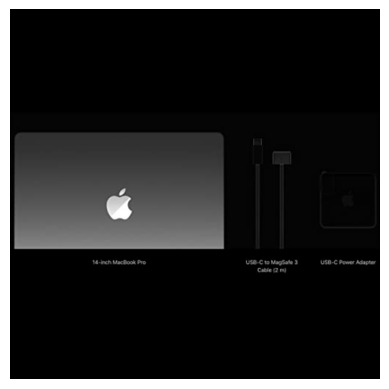

[([[330, 1012], [556, 1012], [556, 1040], [330, 1040]], 'Je-inchucDootetd', 0.0026520703670422745), ([[950, 1012], [1172, 1012], [1172, 1044], [950, 1044]], 'ISu Crotnsto?', 0.0015550226314410337), ([[1254, 1012], [1488, 1012], [1488, 1043], [1254, 1043]], 'USu CPore AJjpicr', 0.008077912385218607), ([[998, 1044], [1126, 1044], [1126, 1074], [998, 1074]], 'Calle /]', 0.05748649786878624)]
first: ['', '', '', '']
before []
before []
No valid entity values found for wattage in image 21tOerzlVML.jpg

Entity :  voltage
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


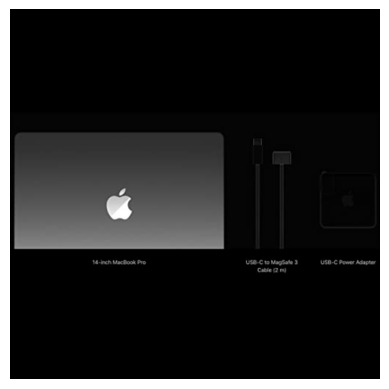

[([[330, 1012], [556, 1012], [556, 1040], [330, 1040]], 'Je-inchucDootetd', 0.0026520703670422745), ([[950, 1012], [1172, 1012], [1172, 1044], [950, 1044]], 'ISu Crotnsto?', 0.0015550226314410337), ([[1254, 1012], [1488, 1012], [1488, 1043], [1254, 1043]], 'USu CPore AJjpicr', 0.008077912385218607), ([[998, 1044], [1126, 1044], [1126, 1074], [998, 1074]], 'Calle /]', 0.05748649786878624)]
first: ['', '', '', '']
before []
before []
No valid entity values found for voltage in image 21tOerzlVML.jpg

Entity :  item_weight
Original Image Dimensions: Width=500, Height=73, Area=36500
Scaled Image Dimensions: Width=1500, Height=219


[([[568, 24], [634, 24], [634, 48], [568, 48]], 'Wog', 0.13677744897641694), ([[203, 31], [935, 31], [935, 99], [203, 99]], '"{bev) Jeq [ %0215 "MBS \'L sbuwjos Sije] UOIIIION', 0.008775941667131172)]
first: ['', '%0215 inMBS']
before ['%0215 inMBS']
before ['%0215 inMBS']
No valid entity values found for item_weight in image 21twwj6e-VL.jpg

Entity :  height
Original Image Dimensions: Width=981, Height=1000, Area=981000


[([[376, 318], [397, 318], [397, 387], [376, 387]], '1', 0.9044015196791442), ([[401, 437], [417, 437], [417, 489], [401, 489]], ';', 0.05193924469588418), ([[457, 533], [511, 533], [511, 549], [457, 549]], '280mm', 0.9657524310470659)]
first: ['1', '', '280mm']
before ['1', '280 mm']
before ['1', '280 millimetre']
280.0
millimetre
Best Entity Value for height: 280 millimetre

Entity :  depth
Original Image Dimensions: Width=981, Height=1000, Area=981000


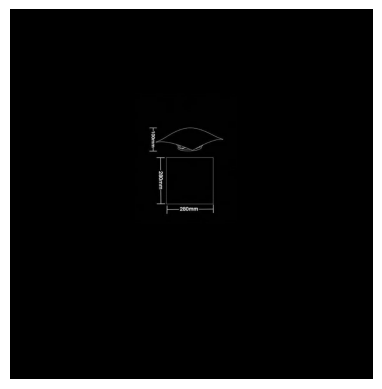

[([[376, 318], [397, 318], [397, 387], [376, 387]], '1', 0.9044015196791442), ([[401, 437], [417, 437], [417, 489], [401, 489]], ';', 0.05193924469588418), ([[457, 533], [511, 533], [511, 549], [457, 549]], '280mm', 0.9657524310470659)]
first: ['1', '', '280mm']
before ['1', '280 mm']
before ['1', '280 millimetre']
280.0
millimetre
Best Entity Value for depth: 280 millimetre

Entity :  width
Original Image Dimensions: Width=981, Height=1000, Area=981000


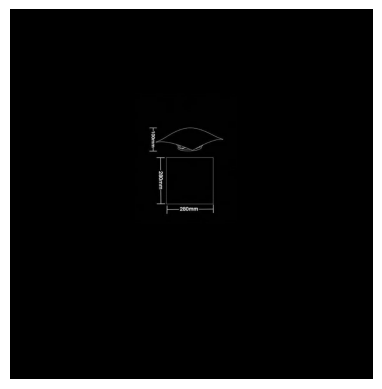

[([[376, 318], [397, 318], [397, 387], [376, 387]], '1', 0.9044015196791442), ([[401, 437], [417, 437], [417, 489], [401, 489]], ';', 0.05193924469588418), ([[457, 533], [511, 533], [511, 549], [457, 549]], '280mm', 0.9657524310470659)]
first: ['1', '', '280mm']
before ['1', '280 mm']
before ['1', '280 millimetre']
280.0
millimetre
Best Entity Value for width: 280 millimetre

Entity :  voltage
Original Image Dimensions: Width=121, Height=500, Area=60500
Scaled Image Dimensions: Width=363, Height=1500


[([[135, 212], [215, 212], [215, 513], [135, 513]], '5', 0.3870397748991685), ([[134, 544], [226, 544], [226, 793], [134, 793]], '3', 0.6057753645792765), ([[137, 833], [221, 833], [221, 1169], [137, 1169]], '0', 0.19489020625593412), ([[140, 1196], [224, 1196], [224, 1268], [140, 1268]], '0J', 0.37933292512981537), ([[140, 1279], [231, 1279], [231, 1412], [140, 1412]], '2', 0.6043228917542685)]
first: ['5', '3', '0', '0J', '2']
before ['5', '3', '0', '0 J', '2']
before ['5', '3', '0', '0 J', '2']
No valid entity values found for voltage in image 21vv80MKQEL.jpg

Entity :  item_weight
Original Image Dimensions: Width=380, Height=240, Area=91200
Scaled Image Dimensions: Width=1140, Height=720


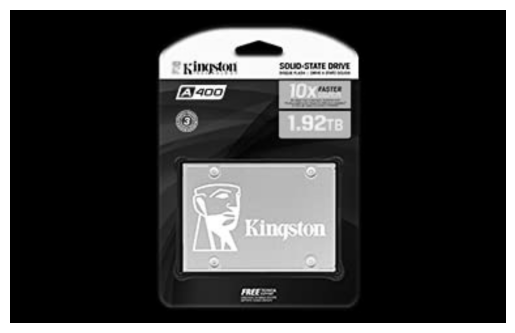

[([[389, 110], [530, 110], [530, 158], [389, 158]], 'FhxFtnt', 0.05932274601584997), ([[614, 118], [786, 118], [786, 142], [614, 142]], 'DU) TIE LAnT', 0.05464119073528546), ([[410, 176], [496, 176], [496, 204], [410, 204]], 'lao0', 0.11243218183517456), ([[633, 165], [711, 165], [711, 209], [633, 209]], 'JOxe', 0.5029090642929077), ([[703, 173], [765, 173], [765, 193], [703, 193]], 'JaaIn', 0.031025142561228274), ([[629, 236], [773, 236], [773, 286], [629, 286]], '9ZTB', 0.12079714983701706), ([[529, 472], [734, 472], [734, 536], [529, 536]], 'Kingston', 0.9894681694749988)]
first: ['', '', 'lao0', '', '', '9ZTB', '']
before ['lao0', '9 ZTB']
before ['lao0', '9 ZTB']
No valid entity values found for item_weight in image 21xX4tzOqKL.jpg

Entity :  height
Original Image Dimensions: Width=500, Height=105, Area=52500
Scaled Image Dimensions: Width=1500, Height=315


[([[568, 62], [744, 62], [744, 90], [568, 90]], '79 151*{Z00 }', 0.09599931295513035), ([[753, 60], [872, 60], [872, 90], [753, 90]], 'JuJgu|', 0.02602504010622325), ([[1276, 96], [1366, 96], [1366, 120], [1276, 120]], 'Tia', 0.02081667967981467), ([[586, 210], [892, 210], [892, 238], [586, 238]], '7141447 192.9 - 365-4 tm|', 0.010421891961690462), ([[1385, 269], [1423, 269], [1423, 287], [1385, 287]], 'c]', 0.05629170438129297)]
first: ['79151{Z00', '', '', '.9--4tm', '']
before ['79151{Z00', '.9--4 tm']
before ['79151{Z00', '.9--4 tm']
No valid entity values found for height in image 21xnCHoPZHL.jpg

Entity :  width
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


[([[605, 907], [711, 907], [711, 951], [605, 951]], '4.2in', 0.94860484991737), ([[603, 955], [715, 955], [715, 999], [603, 999]], '10cm', 0.8819655179977417)]
first: ['4.2in', '10cm']
before ['4.2 in', '10 cm']
before ['4.2 inch', '10 centimetre']
4.2
inch
10.0
centimetre
Best Entity Value for width: 4.2 inch

Entity :  height
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


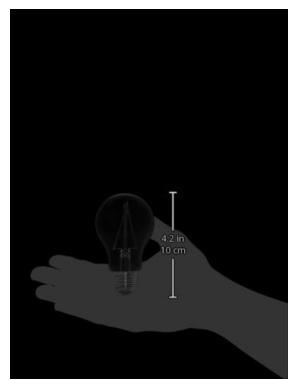

[([[605, 907], [711, 907], [711, 951], [605, 951]], '4.2in', 0.94860484991737), ([[603, 955], [715, 955], [715, 999], [603, 999]], '10cm', 0.8819655179977417)]
first: ['4.2in', '10cm']
before ['4.2 in', '10 cm']
before ['4.2 inch', '10 centimetre']
4.2
inch
10.0
centimetre
Best Entity Value for height: 4.2 inch

Entity :  depth
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


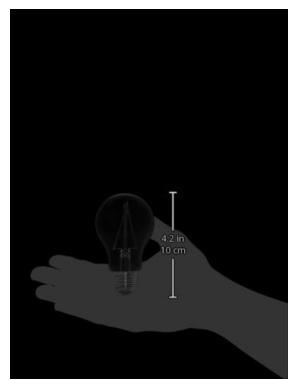

[([[605, 907], [711, 907], [711, 951], [605, 951]], '4.2in', 0.94860484991737), ([[603, 955], [715, 955], [715, 999], [603, 999]], '10cm', 0.8819655179977417)]
first: ['4.2in', '10cm']
before ['4.2 in', '10 cm']
before ['4.2 inch', '10 centimetre']
4.2
inch
10.0
centimetre
Best Entity Value for depth: 10 centimetre

Entity :  width
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


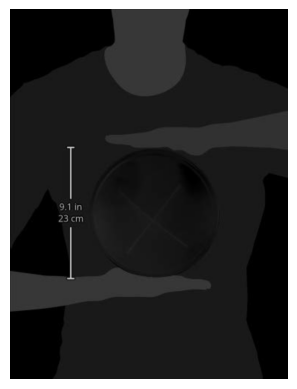

[([[193, 780], [297, 780], [297, 824], [193, 824]], '9.1 in', 0.7878333761333833), ([[189, 827], [303, 827], [303, 869], [189, 869]], '23 cm', 0.8334658756183747)]
first: ['9.1in', '23cm']
before ['9.1 in', '23 cm']
before ['9.1 inch', '23 centimetre']
9.1
inch
23.0
centimetre
Best Entity Value for width: 23 centimetre

Entity :  height
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


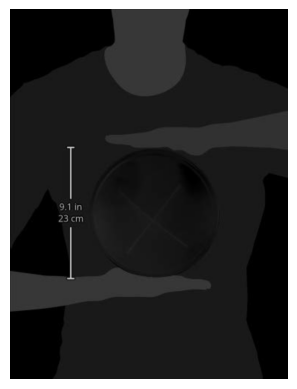

[([[193, 780], [297, 780], [297, 824], [193, 824]], '9.1 in', 0.7878333761333833), ([[189, 827], [303, 827], [303, 869], [189, 869]], '23 cm', 0.8334658756183747)]
first: ['9.1in', '23cm']
before ['9.1 in', '23 cm']
before ['9.1 inch', '23 centimetre']
9.1
inch
23.0
centimetre
Best Entity Value for height: 9.1 inch

Entity :  depth
Original Image Dimensions: Width=375, Height=500, Area=187500
Scaled Image Dimensions: Width=1125, Height=1500


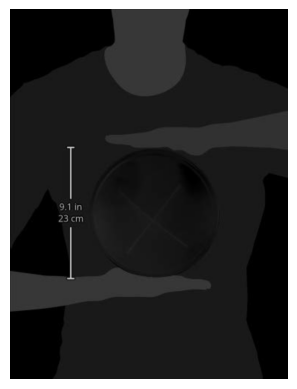

[([[193, 780], [297, 780], [297, 824], [193, 824]], '9.1 in', 0.7878333761333833), ([[189, 827], [303, 827], [303, 869], [189, 869]], '23 cm', 0.8334658756183747)]
first: ['9.1in', '23cm']
before ['9.1 in', '23 cm']
before ['9.1 inch', '23 centimetre']
9.1
inch
23.0
centimetre
Best Entity Value for depth: 23 centimetre

Entity :  wattage
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


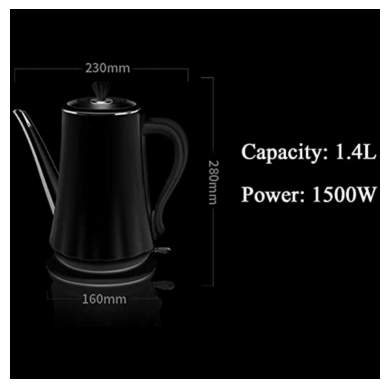

[([[298, 212], [490, 212], [490, 264], [298, 264]], '230mm', 0.9968868588202263), ([[928, 531], [1497, 531], [1497, 640], [928, 640]], 'Capacity: 1.4L', 0.7290700076387456), ([[798, 604], [852, 604], [852, 800], [798, 800]], '', 0.0), ([[925, 709], [1499, 709], [1499, 800], [925, 800]], 'Power: 1500W', 0.4755446462578059), ([[284, 1148], [476, 1148], [476, 1200], [284, 1200]], '160mm', 0.9317021959588729)]
first: ['230mm', '1.4L', '', '1500W', '160mm']
before ['230 mm', '1.4 L', '1500 W', '160 mm']
before ['230 mm', '1.4 L', '1500 watt', '160 mm']
1500.0
watt
Best Entity Value for wattage: 1500 watt

Entity :  voltage
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


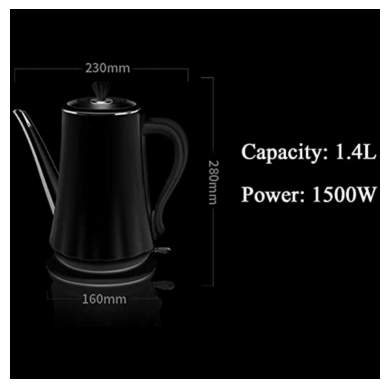

[([[298, 212], [490, 212], [490, 264], [298, 264]], '230mm', 0.9968868588202263), ([[928, 531], [1497, 531], [1497, 640], [928, 640]], 'Capacity: 1.4L', 0.7290700076387456), ([[798, 604], [852, 604], [852, 800], [798, 800]], '', 0.0), ([[925, 709], [1499, 709], [1499, 800], [925, 800]], 'Power: 1500W', 0.4755446462578059), ([[284, 1148], [476, 1148], [476, 1200], [284, 1200]], '160mm', 0.9317021959588729)]
first: ['230mm', '1.4L', '', '1500W', '160mm']
before ['230 mm', '1.4 L', '1500 W', '160 mm']
before ['230 mm', '1.4 L', '1500 W', '160 mm']
No valid entity values found for voltage in image 31+1xiVjZBL.jpg

Entity :  height
Original Image Dimensions: Width=1286, Height=1286, Area=1653796


[([[650, 542], [885, 542], [885, 592], [650, 592]], '4.7 in / 12 cm', 0.9906365595483081), ([[428, 932], [640, 932], [640, 983], [428, 983]], '3.1 in / 8 cm', 0.9726346791031772)]
first: ['4.7incm', '3.1incm']
before ['4.7 incm', '3.1 incm']
before ['4.7 incm', '3.1 incm']
No valid entity values found for height in image 31+21njYcOL.jpg

Entity :  depth
Original Image Dimensions: Width=1286, Height=1286, Area=1653796


[([[650, 542], [885, 542], [885, 592], [650, 592]], '4.7 in / 12 cm', 0.9906365595483081), ([[428, 932], [640, 932], [640, 983], [428, 983]], '3.1 in / 8 cm', 0.9726346791031772)]
first: ['4.7incm', '3.1incm']
before ['4.7 incm', '3.1 incm']
before ['4.7 incm', '3.1 incm']
No valid entity values found for depth in image 31+21njYcOL.jpg

Entity :  item_weight
Original Image Dimensions: Width=500, Height=327, Area=163500
Scaled Image Dimensions: Width=1500, Height=981


[([[645.5913414550679, 229.0119388816601], [853.5993347091021, 359.66573750464073], [818.4086585449321, 413.9880611183399], [611.4006652908979, 283.33426249535927]], '845 mo', 0.12002571293640964), ([[698.3641784200731, 531.0405916765708], [758.8542172175634, 583.8014278475152], [729.6358215799269, 618.9594083234292], [668.1457827824366, 566.1985721524848]], 'ass', 0.4408469111773219), ([[750.5432027610058, 575.0209100949625], [849.6423834544263, 656.1430466182295], [819.4567972389942, 693.9790899050375], [720.3576165455737, 611.8569533817705]], '890+7', 0.4855683037105382), ([[975.0198512391601, 747.601985123916], [1042.544726330997, 716.9138425347481], [1057.98014876084, 749.398014876084], [990.4552736690028, 780.0861574652519]], 'tttt', 0.15647737681865692)]
first: ['845mo', '', '8907', '']
before ['845 mo', '8907']
before ['845 mo', '8907']
No valid entity values found for item_weight in image 31+B4SvByXL.jpg

Entity :  height
Original Image Dimensions: Width=1600, Height=1600, Are

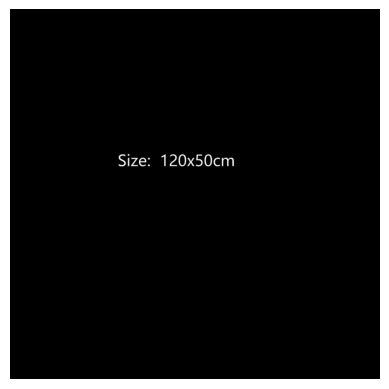

[([[461, 621], [617, 621], [617, 689], [461, 689]], 'Size:', 0.9998156983594109), ([[644, 618], [976, 618], [976, 692], [644, 692]], '120x50cm', 0.8661708694742782)]
first: ['', '120x50cm']
before ['120 x50 cm']
before ['120 x50 centimetre']
No valid entity values found for height in image 31+H+PVsNEL.jpg

Entity :  item_weight
Original Image Dimensions: Width=500, Height=278, Area=139000
Scaled Image Dimensions: Width=1500, Height=834


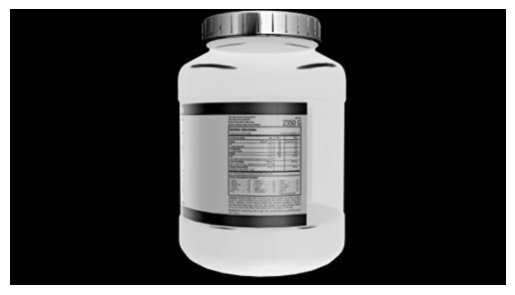

[]
first: []
before []
before []
No valid entity values found for item_weight in image 31+KMtY+QXL.jpg

Entity :  maximum_weight_recommendation
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


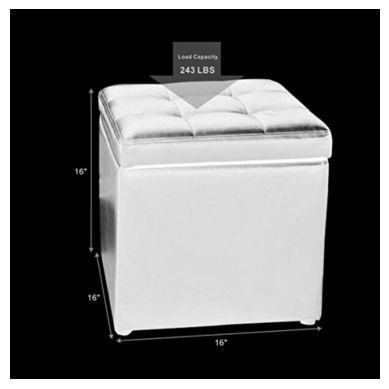

[([[675, 176], [848, 176], [848, 212], [675, 212]], 'Lojd Capacity', 0.6869198099005791), ([[683, 225], [837, 225], [837, 267], [683, 267]], '243 LBS', 0.7696836409254758), ([[259, 641], [319, 641], [319, 677], [259, 677]], '16"', 0.49676573276519775), ([[311, 1151], [371, 1151], [371, 1189], [311, 1189]], '16"', 0.8888290093332101), ([[825, 1333], [887, 1333], [887, 1371], [825, 1371]], '16"', 0.7768447995185852)]
first: ['', '243LBS', '16 in', '16 in', '16 in']
before ['243 LBS', '16 in', '16 in', '16 in']
before ['243 pound', '16 in', '16 in', '16 in']
243.0
pound
Best Entity Value for maximum_weight_recommendation: 243 pound

Entity :  item_weight
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


[([[401, 291], [819, 291], [819, 381], [401, 381]], '11.1Ib / 5_', 0.9116155393510685), ([[810, 348], [836, 348], [836, 372], [810, 372]], '', 0.0), ([[827, 289], [961, 289], [961, 379], [827, 379]], '05', 0.9998377384892659), ([[479, 510], [1021, 510], [1021, 591], [479, 591]], 'Super Lightweight', 0.9707279426513917), ([[985.957099981092, 281.0495498014665], [1111.3217742849881, 316.1972410528991], [1084.0429000189079, 407.9504501985335], [957.6782257150118, 372.8027589471009]], 'kg', 0.8355644327354829)]
first: ['11.1Ib', '', '05', '', '']
before ['11.1 Ib', '05']
before ['11.1 Ib', '05']
No valid entity values found for item_weight in image 31+NHijx4tL.jpg

Entity :  item_weight
Original Image Dimensions: Width=334, Height=500, Area=167000
Scaled Image Dimensions: Width=1002, Height=1500


[([[276, 676], [813, 676], [813, 813], [276, 813]], 'RUPENs', 0.7866705798076022), ([[471, 809], [784, 809], [784, 845], [471, 845]], 'tradltiona: recipes', 0.16339422311191593), ([[474, 841], [754, 841], [754, 874], [474, 874]], 'Jutnentic movots', 0.18539111899277885), ([[310, 954], [692, 954], [692, 1028], [310, 1028]], 'VINDALOO', 0.9993261464245619), ([[347, 1019], [653, 1019], [653, 1064], [347, 1064]], 'CURRY SAUCE', 0.9945950534668749), ([[316, 1082], [663, 1082], [663, 1119], [316, 1119]], 'spicy Cutty Wiln Kosnmir', 0.12122574728827462), ([[685, 1067], [755, 1067], [755, 1111], [685, 1111]], 'Am', 0.6295339433059162), ([[689, 1103], [750, 1103], [750, 1129], [689, 1129]], 'Herr', 0.02672324702143669), ([[344, 1116], [638, 1116], [638, 1148], [344, 1148]], 'chilles und fomorind', 0.2824765231957318), ([[684, 1126], [754, 1126], [754, 1150], [684, 1150]], 'LEMIL', 0.5877336522139203), ([[364, 1172], [638, 1172], [638, 1204], [364, 1204]], 'HLI WT 10 Oz (70sqi', 0.01018780658081

[([[698, 1076], [748, 1076], [748, 1172], [698, 1172]], 'I', 0.2718670085563559), ([[662, 1194], [784, 1194], [784, 1246], [662, 1246]], '39 in', 0.8107386017642715), ([[650, 1258], [796, 1258], [796, 1308], [650, 1308]], '98 cm', 0.9889558813545565)]
first: ['', '39in', '98cm']
before ['39 in', '98 cm']
before ['39 inch', '98 centimetre']
39.0
inch
98.0
centimetre
Best Entity Value for height: 39 inch

Entity :  width
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


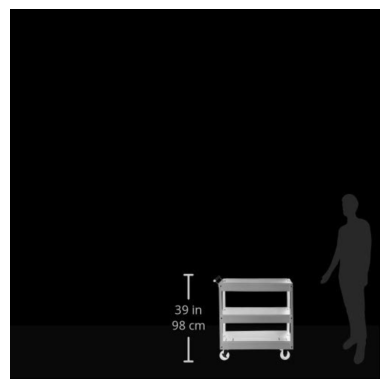

[([[698, 1076], [748, 1076], [748, 1172], [698, 1172]], 'I', 0.2718670085563559), ([[662, 1194], [784, 1194], [784, 1246], [662, 1246]], '39 in', 0.8107386017642715), ([[650, 1258], [796, 1258], [796, 1308], [650, 1308]], '98 cm', 0.9889558813545565)]
first: ['', '39in', '98cm']
before ['39 in', '98 cm']
before ['39 inch', '98 centimetre']
39.0
inch
98.0
centimetre
Best Entity Value for width: 98 centimetre

Entity :  depth
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


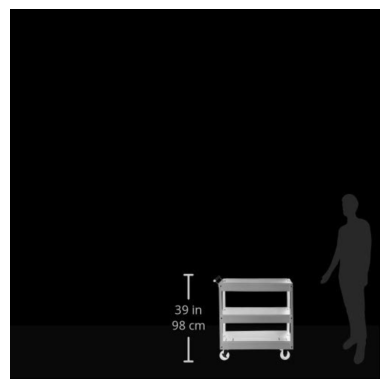

[([[698, 1076], [748, 1076], [748, 1172], [698, 1172]], 'I', 0.2718670085563559), ([[662, 1194], [784, 1194], [784, 1246], [662, 1246]], '39 in', 0.8107386017642715), ([[650, 1258], [796, 1258], [796, 1308], [650, 1308]], '98 cm', 0.9889558813545565)]
first: ['', '39in', '98cm']
before ['39 in', '98 cm']
before ['39 inch', '98 centimetre']
39.0
inch
98.0
centimetre
Best Entity Value for depth: 39 inch

Entity :  wattage
Original Image Dimensions: Width=500, Height=151, Area=75500
Scaled Image Dimensions: Width=1500, Height=453


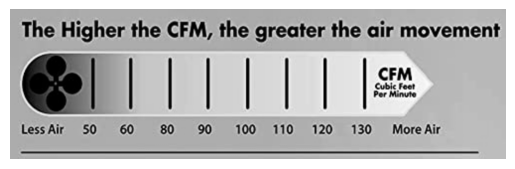

[([[27, 17], [1493, 17], [1493, 110], [27, 110]], 'The Higher the CFM, the greater the air movement', 0.9378854570759468), ([[1106, 168], [1222, 168], [1222, 224], [1106, 224]], 'CFM', 0.999732824131404), ([[1098, 218], [1228, 218], [1228, 250], [1098, 250]], 'Cubic Fct', 0.2405178538134977), ([[1096, 242], [1234, 242], [1234, 272], [1096, 272]], 'Per Minuto', 0.27278030038384565), ([[27, 341], [169, 341], [169, 385], [27, 385]], 'Less Air', 0.7028286802298391), ([[213, 341], [267, 341], [267, 383], [213, 383]], '50', 0.8593670190984367), ([[325, 341], [381, 341], [381, 383], [325, 383]], '60', 0.9996391577544078), ([[447, 341], [503, 341], [503, 383], [447, 383]], '80', 0.9998747418640385), ([[561, 341], [615, 341], [615, 383], [561, 383]], '90', 0.8877541489898791), ([[675, 341], [749, 341], [749, 383], [675, 383]], '100', 0.9989647295957361), ([[787, 341], [863, 341], [863, 383], [787, 383]], '110', 0.9997280753423593), ([[907, 341], [981, 341], [981, 383], [907, 383]], '120', 0.999

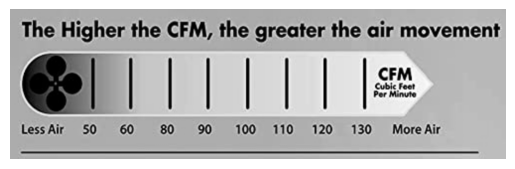

[([[27, 17], [1493, 17], [1493, 110], [27, 110]], 'The Higher the CFM, the greater the air movement', 0.9378854570759468), ([[1106, 168], [1222, 168], [1222, 224], [1106, 224]], 'CFM', 0.999732824131404), ([[1098, 218], [1228, 218], [1228, 250], [1098, 250]], 'Cubic Fct', 0.2405178538134977), ([[1096, 242], [1234, 242], [1234, 272], [1096, 272]], 'Per Minuto', 0.27278030038384565), ([[27, 341], [169, 341], [169, 385], [27, 385]], 'Less Air', 0.7028286802298391), ([[213, 341], [267, 341], [267, 383], [213, 383]], '50', 0.8593670190984367), ([[325, 341], [381, 341], [381, 383], [325, 383]], '60', 0.9996391577544078), ([[447, 341], [503, 341], [503, 383], [447, 383]], '80', 0.9998747418640385), ([[561, 341], [615, 341], [615, 383], [561, 383]], '90', 0.8877541489898791), ([[675, 341], [749, 341], [749, 383], [675, 383]], '100', 0.9989647295957361), ([[787, 341], [863, 341], [863, 383], [787, 383]], '110', 0.9997280753423593), ([[907, 341], [981, 341], [981, 383], [907, 383]], '120', 0.999

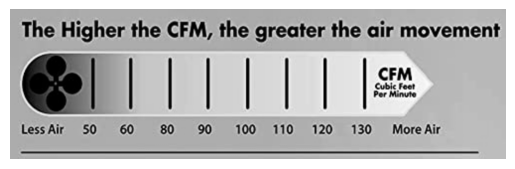

[([[27, 17], [1493, 17], [1493, 110], [27, 110]], 'The Higher the CFM, the greater the air movement', 0.9378854570759468), ([[1106, 168], [1222, 168], [1222, 224], [1106, 224]], 'CFM', 0.999732824131404), ([[1098, 218], [1228, 218], [1228, 250], [1098, 250]], 'Cubic Fct', 0.2405178538134977), ([[1096, 242], [1234, 242], [1234, 272], [1096, 272]], 'Per Minuto', 0.27278030038384565), ([[27, 341], [169, 341], [169, 385], [27, 385]], 'Less Air', 0.7028286802298391), ([[213, 341], [267, 341], [267, 383], [213, 383]], '50', 0.8593670190984367), ([[325, 341], [381, 341], [381, 383], [325, 383]], '60', 0.9996391577544078), ([[447, 341], [503, 341], [503, 383], [447, 383]], '80', 0.9998747418640385), ([[561, 341], [615, 341], [615, 383], [561, 383]], '90', 0.8877541489898791), ([[675, 341], [749, 341], [749, 383], [675, 383]], '100', 0.9989647295957361), ([[787, 341], [863, 341], [863, 383], [787, 383]], '110', 0.9997280753423593), ([[907, 341], [981, 341], [981, 383], [907, 383]], '120', 0.999

[([[482, 278], [558, 278], [558, 306], [482, 306]], '60 cm', 0.9973937029243343), ([[882, 280], [960, 280], [960, 312], [882, 312]], '26 cm', 0.9364391585129638), ([[12, 441], [43, 441], [43, 540], [12, 540]], '9', 0.41618461432477716)]
first: ['60cm', '26cm', '9']
before ['60 cm', '26 cm', '9']
before ['60 centimetre', '26 centimetre', '9']
60.0
centimetre
26.0
centimetre
Best Entity Value for width: 60 centimetre

Entity :  maximum_weight_recommendation
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


[([[216, 75], [368, 75], [368, 104], [216, 104]], 'Indudc;%a', 0.09163086102523844), ([[738, 84], [876, 84], [876, 112], [738, 112]], 'Buikt-in wire', 0.38965686441840136), ([[218, 106], [410, 106], [410, 134], [218, 134]], 'archor hardwarc', 0.23392347711946165), ([[727, 117], [886, 117], [886, 149], [727, 149]], 'Munjgemen:', 0.10946193837946866), ([[216, 134], [369, 134], [369, 164], [216, 164]], 'lor Maxmun', 0.06398228454331517), ([[742, 141], [869, 141], [869, 179], [742, 179]], 'goninet?', 0.18165297680373987), ([[214, 161], [316, 161], [316, 201], [214, 201]], 'staEility', 0.7029572807524095), ([[1191, 481], [1291, 481], [1291, 517], [1191, 517]], '200LB', 0.619576768868437), ([[1183, 515], [1299, 515], [1299, 551], [1183, 551]], '90.7KG', 0.9859728608825314), ([[390, 1218], [520, 1218], [520, 1250], [390, 1250]], 'AdjistaEle', 0.3753115939379318), ([[406, 1250], [502, 1250], [502, 1276], [406, 1276]], 'Kucicrs', 0.030053580558180082)]
first: ['', '', '', '', '', '', '', '200LB

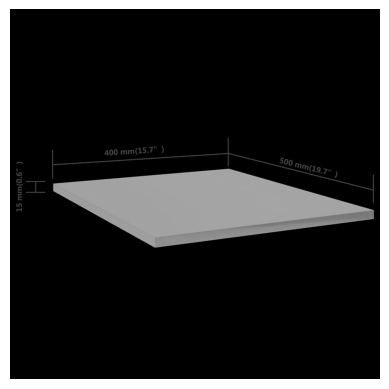

[([[258, 384], [302, 384], [302, 410], [258, 410]], '400', 0.9942334153816409), ([[11, 435], [40, 435], [40, 534], [11, 534]], '1', 0.556362860758103), ([[15, 533], [35, 533], [35, 563], [15, 563]], '5', 0.29278775365299126), ([[300.07944680100655, 383.6953361612079], [409.8488036274807, 374.0596182200549], [411.92055319899345, 400.3046638387921], [301.1511963725193, 409.9403817799451]], 'mm(15.7"', 0.9665352545624158), ([[744.1299778141514, 402.1289267866996], [790.8956791157598, 414.21575357281506], [782.8700221858486, 440.8710732133004], [737.1043208842402, 428.78424642718494]], '500', 0.9985417986710217), ([[786.349208626544, 416.07143881944813], [894.9988849195312, 439.9182122294673], [887.650791373456, 466.92856118055187], [779.0011150804688, 443.0817877705327]], 'mm(19.7"', 0.9945434809456062)]
first: ['400', '1', '5', 'mm(15.7 in', '500', 'mm(19.7 in']
before ['400', '1', '5', 'mm(15.7 in', '500', 'mm(19.7 in']
before ['400', '1', '5', 'mm(15.7 inch', '500', 'mm(19.7 inch']
No 

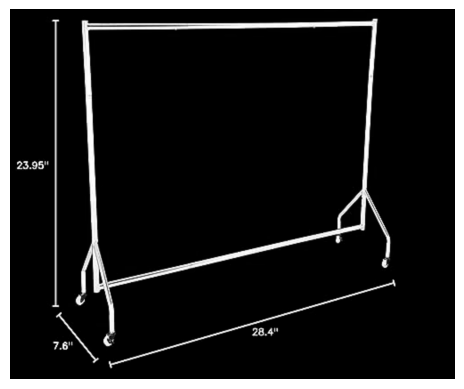

[([[17, 507], [137, 507], [137, 547], [17, 547]], '23.95"', 0.9979741622098394), ([[810, 1068], [911, 1068], [911, 1110], [810, 1110]], '28.4"', 0.9993554563777021), ([[141, 1117], [219, 1117], [219, 1155], [141, 1155]], '7.6"', 0.5986966001880245)]
first: ['23.95 in', '28.4 in', '7.6 in']
before ['23.95 in', '28.4 in', '7.6 in']
before ['23.95 inch', '28.4 inch', '7.6 inch']
23.95
inch
28.4
inch
7.6
inch
Best Entity Value for height: 7.6 inch

Entity :  item_weight
Original Image Dimensions: Width=300, Height=266, Area=79800
Scaled Image Dimensions: Width=900, Height=798


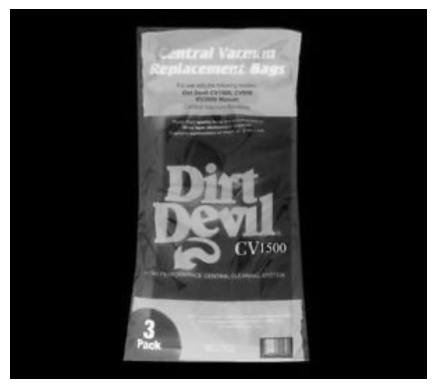

[([[321, 77], [581, 77], [581, 113], [321, 113]], 'C #eln', 0.0033811361950625844), ([[297, 113], [601, 113], [601, 150], [297, 150]], 'a', 0.02454136752527014), ([[322, 318], [555, 318], [555, 434], [322, 434]], 'Dint', 0.5528581625609265), ([[294, 391], [595, 391], [595, 519], [294, 519]], 'Devl', 0.5205350518226624), ([[481, 497], [605, 497], [605, 537], [481, 537]], 'CVIsud', 0.06320422582118107), ([[346, 496], [444, 496], [444, 574], [346, 574]], '6', 0.38389204423339507), ([[283, 667], [319, 667], [319, 715], [283, 715]], '3', 0.9931050591757504), ([[267, 705], [334, 705], [334, 743], [267, 743]], 'Puci', 0.037311796098947525)]
first: ['', '', '', '', '', '6', '3', '']
before ['6', '3']
before ['6', '3']
No valid entity values found for item_weight in image 31+zdbOuiTL.jpg

Entity :  height
Original Image Dimensions: Width=1001, Height=1001, Area=1002001


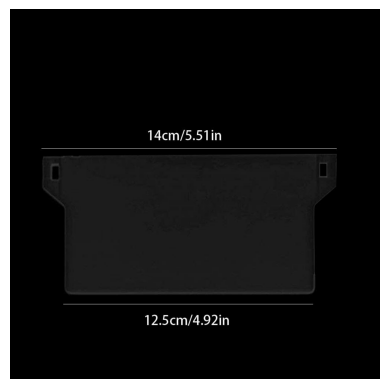

[([[366, 320], [577, 320], [577, 363], [366, 363]], '14cm/5.S1in', 0.7982871314356765), ([[355, 817], [600, 817], [600, 865], [355, 865]], '12.5cm/4.92in', 0.9033080408254093)]
first: ['14cm/5.in', '12.5cm/4.92in']
before ['14 cm', '5.in', '12.5 cm', '4.92 in']
before ['14 centimetre', '5.in', '12.5 centimetre', '4.92 inch']
14.0
centimetre
12.5
centimetre
4.92
inch
Best Entity Value for height: 14 centimetre

Entity :  width
Original Image Dimensions: Width=1001, Height=1001, Area=1002001


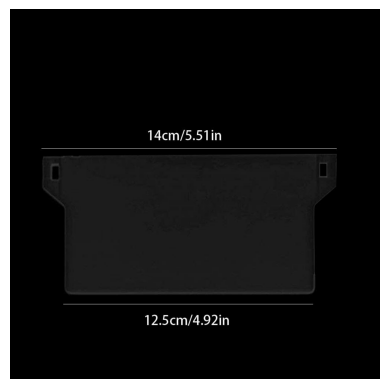

[([[366, 320], [577, 320], [577, 363], [366, 363]], '14cm/5.S1in', 0.7982871314356765), ([[355, 817], [600, 817], [600, 865], [355, 865]], '12.5cm/4.92in', 0.9033080408254093)]
first: ['14cm/5.in', '12.5cm/4.92in']
before ['14 cm', '5.in', '12.5 cm', '4.92 in']
before ['14 centimetre', '5.in', '12.5 centimetre', '4.92 inch']
14.0
centimetre
12.5
centimetre
4.92
inch
Best Entity Value for width: 14 centimetre

Entity :  voltage
Original Image Dimensions: Width=500, Height=247, Area=123500
Scaled Image Dimensions: Width=1500, Height=741


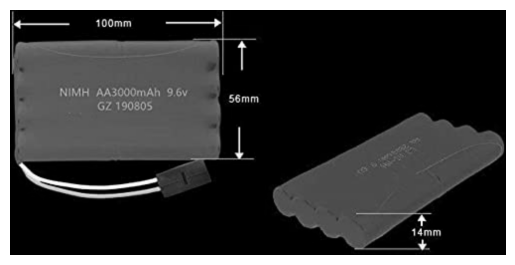

[([[254, 23], [373, 23], [373, 61], [254, 61]], '1oumm', 0.5247919930420919), ([[143, 229], [545, 229], [545, 271], [143, 271]], 'NIMH AA3OdumAh 9,6v', 0.22436816215034575), ([[657, 251], [759, 251], [759, 289], [657, 289]], '56mm', 0.9791437983512878), ([[257, 270], [436, 270], [436, 311], [257, 311]], 'GZ 190805', 0.7480758138740473), ([[1207, 653], [1310, 653], [1310, 693], [1207, 693]], '14mm', 0.9759319424629211)]
first: ['1oumm', 'AA3OdumAh,6v', '56mm', '', '14mm']
before ['1 oumm', 'AA3 OdumAh', '6 v', '56 mm', '14 mm']
before ['1 oumm', 'AA3 OdumAh', '6 volt', '56 mm', '14 mm']
6.0
volt
Best Entity Value for voltage: 6 volt

Entity :  height
Original Image Dimensions: Width=1024, Height=1024, Area=1048576


[([[25, 442], [55, 442], [55, 534], [25, 534]], '1', 0.21898304718351724), ([[28, 534], [52, 534], [52, 574], [28, 574]], 'co', 0.17690098424300224), ([[594, 554], [626, 554], [626, 580], [594, 580]], '80', 0.9999510257132871), ([[622.7701175612585, 549.9931058051327], [727.7933032552244, 536.9057162505306], [731.2298824387415, 563.0068941948673], [625.2066967447756, 577.0942837494694]], 'cm(31.5"', 0.9985842092805229), ([[86.17583661630786, 558.1154281570775], [140.94374646156325, 572.4217640879073], [132.82416338369214, 598.8845718429225], [79.05625353843674, 584.5782359120927]], '23.5', 0.9995216131210327), ([[137.2172729245717, 576.1039098209152], [226.98511157062995, 592.701488842937], [220.7827270754283, 618.8960901790848], [131.01488842937005, 602.298511157063]], 'cm(9.3"', 0.9977113911006522)]
first: ['1', '', '80', 'cm(31.5 in', '23.5', 'cm(9.3 in']
before ['1', '80', 'cm(31.5 in', '23.5', 'cm(9.3 in']
before ['1', '80', 'cm(31.5 inch', '23.5', 'cm(9.3 inch']
No valid entity v

[([[654, 448], [854, 448], [854, 480], [654, 480]], '14.9 in / 38 cm', 0.6209329181983557), ([[398, 858], [600, 858], [600, 890], [398, 890]], '4.33 in / 11 cm', 0.9529857436083424)]
first: ['14.9incm', '4.33incm']
before ['14.9 incm', '4.33 incm']
before ['14.9 incm', '4.33 incm']
No valid entity values found for depth in image 31-8fLBjX8L.jpg

Entity :  height
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


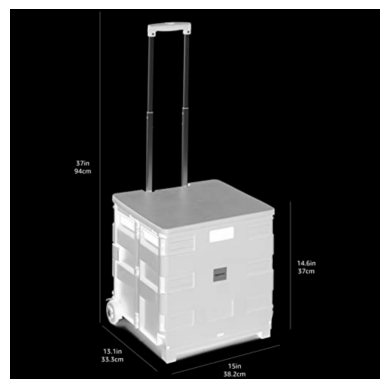

[([[261, 607], [330, 607], [330, 643], [261, 643]], '37in', 0.4672555923461914), ([[256, 642], [334, 642], [334, 674], [256, 674]], '92cmn', 0.11579372777269897), ([[1160, 1014], [1246, 1014], [1246, 1046], [1160, 1046]], 'J46in', 0.1729903803938006), ([[1162, 1048], [1242, 1048], [1242, 1080], [1162, 1080]], '37cmn', 0.4043665116460367), ([[374, 1374], [460, 1374], [460, 1404], [374, 1404]], 'TIin', 0.07154340296983719), ([[366, 1406], [466, 1406], [466, 1436], [366, 1436]], '33 3cm', 0.4738977177150168), ([[880, 1432], [942, 1432], [942, 1464], [880, 1464]], 'I5in', 0.15174590051174164), ([[862, 1466], [958, 1466], [958, 1496], [862, 1496]], '38 Zcm', 0.51389915653099)]
first: ['37in', '92cmn', 'J46in', '37cmn', '', '333cm', '/5in', '38Zcm']
before ['37 in', '92 cmn', 'J46 in', '37 cmn', '333 cm', '5 in', '38 Zcm']
before ['37 inch', '92 cmn', 'J46 inch', '37 cmn', '333 centimetre', '5 inch', '38 Zcm']
37.0
inch
333.0
centimetre
5.0
inch
Best Entity Value for height: 37 inch

Entity 

[([[76, 678], [363, 678], [363, 763], [76, 763]], 'PROVEN', 0.9997789003768427), ([[168, 764], [274, 764], [274, 794], [168, 794]], 'INSQT', 0.19697937940904134), ([[146, 780], [297, 780], [297, 818], [146, 818]], 'Repellenit', 0.29715523603071997), ([[172, 869], [355, 869], [355, 919], [172, 919]], 'MosQuItO', 0.22577019483940394), ([[68, 870], [172, 870], [172, 974], [68, 974]], '12', 0.99999527955623), ([[197, 901], [357, 901], [357, 943], [197, 943]], 'AND Tick', 0.48229942285042415), ([[192, 956], [236, 956], [236, 986], [192, 986]], 'HR', 0.28158750155922224), ([[144, 1022], [327, 1022], [327, 1065], [144, 1065]], 'VOSQUItoEs', 0.4070101560784282), ([[98, 1027], [130, 1027], [130, 1144], [98, 1144]], '1', 0.3937862439145192), ([[142, 1055], [341, 1055], [341, 1124], [142, 1124]], 'BLCICS FLES 4', 0.12041166153334343), ([[145, 1115], [247, 1115], [247, 1151], [145, 1151]], 'Listed', 0.6807867394906779), ([[103, 1164], [350, 1164], [350, 1215], [103, 1215]], 'GENTLE SCENT', 0.91485

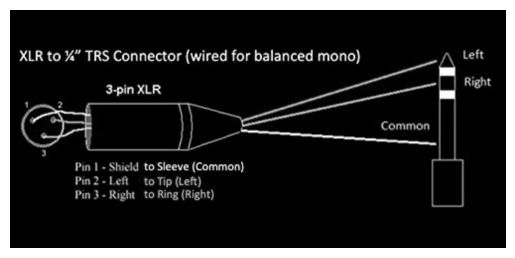

[([[20, 113], [1068, 113], [1068, 168], [20, 168]], 'XLR to %" TRS Connector (wired for balanced mono)', 0.8115154972651826), ([[1365, 117], [1441, 117], [1441, 157], [1365, 157]], 'Left', 0.9738990780872248), ([[1366, 196], [1464, 196], [1464, 246], [1366, 246]], 'Right', 0.6433832072109424), ([[282, 220], [464, 220], [464, 270], [282, 270]], '3-pin XLR', 0.99167666971972), ([[1115, 332], [1277, 332], [1277, 376], [1115, 376]], 'Common', 0.9907837976238173), ([[191, 453], [715, 453], [715, 497], [191, 497]], 'Fin [ - Shicld to Slecve (Common)', 0.33639968948732385), ([[191, 496], [365, 496], [365, 538], [191, 538]], 'Fin %-Lelt', 0.054491235209067665), ([[400, 506], [442, 506], [442, 536], [400, 536]], 'to', 0.5867601697166355), ([[493, 501], [587, 501], [587, 541], [493, 541]], '(Left)', 0.658566150816531), ([[190, 538], [388, 538], [388, 586], [190, 586]], 'Fin } - Right', 0.4318615792338057), ([[399, 537], [623, 537], [623, 582], [399, 582]], 'to Ring (Right)', 0.8176691905486637),

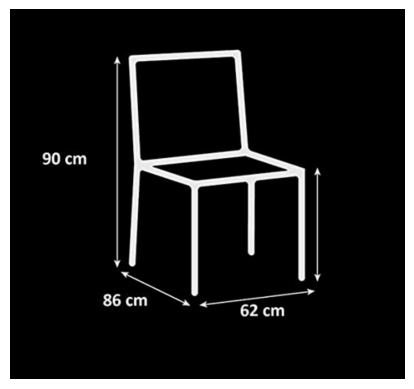

[([[115, 539], [297, 539], [297, 601], [115, 601]], '90 cm', 0.6623616472183668), ([[345, 1077], [527, 1077], [527, 1139], [345, 1139]], '86 cm', 0.9606862892053606), ([[865, 1113], [1048, 1113], [1048, 1178], [865, 1178]], '62 cm', 0.8478159422285544)]
first: ['90cm', '86cm', '62cm']
before ['90 cm', '86 cm', '62 cm']
before ['90 centimetre', '86 centimetre', '62 centimetre']
90.0
centimetre
86.0
centimetre
62.0
centimetre
Best Entity Value for width: 62 centimetre

Entity :  height
Original Image Dimensions: Width=1024, Height=1024, Area=1048576


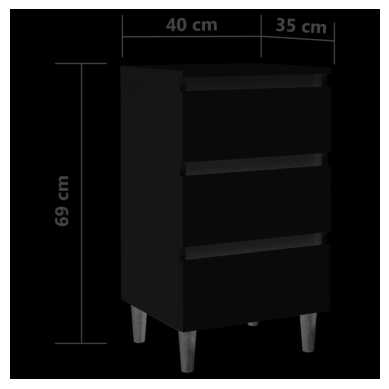

[([[426, 18], [578, 18], [578, 68], [426, 68]], '40 cm', 0.9921812373819877), ([[730, 18], [880, 18], [880, 74], [730, 74]], '35 cm', 0.98738426584752), ([[127, 457], [167, 457], [167, 533], [127, 533]], '8', 0.9881244336021702), ([[118, 540], [170, 540], [170, 608], [118, 608]], '8', 0.9999951124251005)]
first: ['40cm', '35cm', '8', '8']
before ['40 cm', '35 cm', '8', '8']
before ['40 centimetre', '35 centimetre', '8', '8']
40.0
centimetre
35.0
centimetre
Best Entity Value for height: 35 centimetre

Entity :  height
Original Image Dimensions: Width=1080, Height=1080, Area=1166400


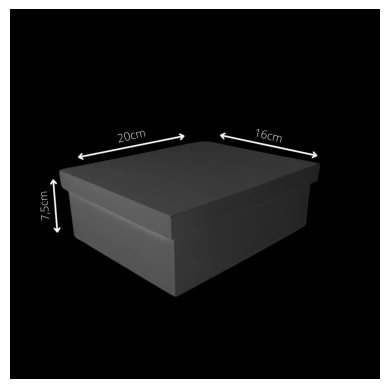

[([[85, 529], [121, 529], [121, 623], [85, 623]], '1', 0.20198645766890877), ([[717.2446104253995, 339.0719742120774], [804.9656686939167, 362.4770546777253], [794.7553895746005, 398.9280257879226], [706.0343313060833, 375.5229453222747]], '16cm', 0.5906775065555606), ([[306.7811992150991, 359.6717988226486], [398.4110176593738, 343.9107516836335], [403.2188007849009, 381.3282011773514], [311.5889823406262, 397.0892483163665]], '20cm', 0.5076410174369812)]
first: ['1', '16cm', '20cm']
before ['1', '16 cm', '20 cm']
before ['1', '16 centimetre', '20 centimetre']
16.0
centimetre
20.0
centimetre
Best Entity Value for height: 16 centimetre

Entity :  width
Original Image Dimensions: Width=1080, Height=1080, Area=1166400


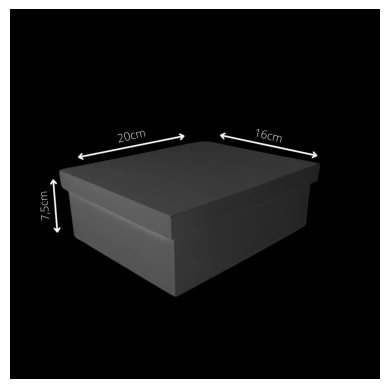

[([[85, 529], [121, 529], [121, 623], [85, 623]], '1', 0.20198645766890877), ([[717.2446104253995, 339.0719742120774], [804.9656686939167, 362.4770546777253], [794.7553895746005, 398.9280257879226], [706.0343313060833, 375.5229453222747]], '16cm', 0.5906775065555606), ([[306.7811992150991, 359.6717988226486], [398.4110176593738, 343.9107516836335], [403.2188007849009, 381.3282011773514], [311.5889823406262, 397.0892483163665]], '20cm', 0.5076410174369812)]
first: ['1', '16cm', '20cm']
before ['1', '16 cm', '20 cm']
before ['1', '16 centimetre', '20 centimetre']
16.0
centimetre
20.0
centimetre
Best Entity Value for width: 20 centimetre

Entity :  height
Original Image Dimensions: Width=1024, Height=1024, Area=1048576


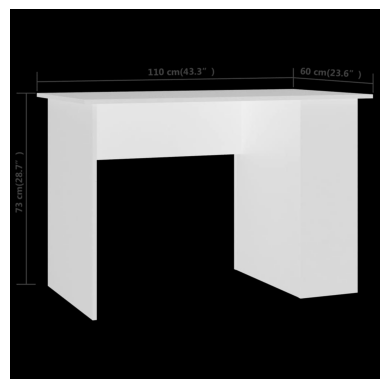

[([[378, 158], [546, 158], [546, 190], [378, 190]], '110 cm(43.3"', 0.8052784457461629), ([[799, 157], [943, 157], [943, 193], [799, 193]], '60 cm(23.6', 0.9970730178118226), ([[9, 415], [41, 415], [41, 530], [9, 530]], '1', 0.5320179821097213), ([[12, 530], [38, 530], [38, 566], [12, 566]], 'm', 0.8483707858460008)]
first: ['110cm(43.3 in', '60cm(23.6', '1', '']
before ['110 cm(43.3 in', '60 cm(23.6', '1']
before ['110 cm(43.3 inch', '60 cm(23.6', '1']
No valid entity values found for height in image 31-UedLQDqL.jpg

Entity :  item_weight
Original Image Dimensions: Width=180, Height=180, Area=32400
Scaled Image Dimensions: Width=540, Height=540


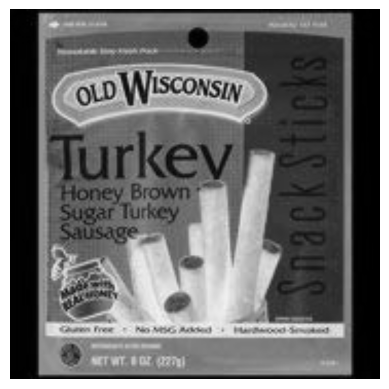

[([[155, 83], [347, 83], [347, 145], [155, 145]], 'WiscoNsin', 0.3641605980910762), ([[57, 173], [335, 173], [335, 261], [57, 261]], 'Turkev', 0.7440746837329406), ([[384, 53], [472, 53], [472, 245], [384, 245]], '9', 0.17242189782980777), ([[66, 249], [271, 249], [271, 289], [66, 289]], 'Honey Brown', 0.8805152903317263), ([[64, 274], [255, 274], [255, 322], [64, 322]], 'Sugar Turkcy ', 0.3744908619780919), ([[66, 306], [195, 306], [195, 348], [66, 348]], 'Sausage', 0.5443473768995795), ([[379, 233], [469, 233], [469, 429], [379, 429]], 'E', 0.26646823060278635), ([[115, 503], [187, 503], [187, 523], [115, 523]], 'rtmtem', 0.013091459669310532), ([[84.00636944292775, 105.41464971873383], [159.80060672175898, 91.75109425398021], [165.99363055707224, 137.5853502812662], [90.199393278241, 151.24890574601977]], 'OLD', 0.997501776959456)]
first: ['', '', '9', '', '', '', '', '', '']
before ['9']
before ['9']
No valid entity values found for item_weight in image 31-W0zT17nL.jpg

Entity :  h

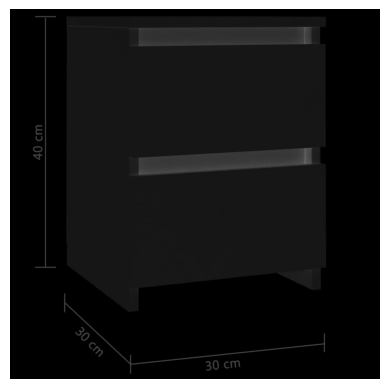

[([[66, 318], [96, 318], [96, 372], [66, 372]], '6', 0.2902333154625616), ([[62, 374], [94, 374], [94, 422], [62, 422]], '?', 0.4658175656648247), ([[174, 874], [226, 874], [226, 926], [174, 926]], 'Jo', 0.2481576828807095), ([[537, 965], [644, 965], [644, 1007], [537, 1007]], '30 cm', 0.9992380837256674), ([[205.9719194937464, 930.552263139369], [229.66843292043015, 909.0562457694622], [269.02808050625356, 954.447736860631], [245.33156707956985, 975.9437542305378]], '3', 0.9952012787890716)]
first: ['6', '', '', '30cm', '3']
before ['6', '30 cm', '3']
before ['6', '30 centimetre', '3']
30.0
centimetre
Best Entity Value for height: 30 centimetre

Entity :  height
Original Image Dimensions: Width=1024, Height=1024, Area=1048576


[([[20, 456], [46, 456], [46, 506], [20, 506]], '6', 0.43907609675079584), ([[14, 510], [46, 510], [46, 534], [14, 534]], 'Co', 0.08467903499155328), ([[87, 575], [133, 575], [133, 619], [87, 619]], '25', 0.9172455421954321), ([[589, 573], [637, 573], [637, 613], [589, 613]], '80', 0.9999693172321554), ([[632.5430712064641, 574.3775281716354], [686.3426064283291, 566.1259148573367], [690.4569287935359, 597.6224718283646], [636.6573935716709, 605.8740851426633]], 'cm', 0.9997215049847255), ([[134.27164295927076, 597.0668719800622], [183.97392028610517, 630.5439763606108], [165.72835704072924, 658.9331280199378], [115.02607971389482, 624.4560236393892]], 'cm', 0.9994129448834549)]
first: ['6', '', '25', '80', '', '']
before ['6', '25', '80']
before ['6', '25', '80']
No valid entity values found for height in image 310-VAupIJL.jpg

Entity :  item_weight
Original Image Dimensions: Width=157, Height=500, Area=78500
Scaled Image Dimensions: Width=471, Height=1500


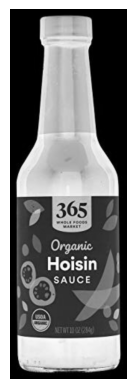

[([[175, 767], [321, 767], [321, 857], [175, 857]], '365', 0.999861478805542), ([[186, 852], [314, 852], [314, 876], [186, 876]], "~ho ' 'Ju0i", 0.012146279099371491), ([[213, 875], [287, 875], [287, 891], [213, 891]], 'HangT', 0.008946735036136829), ([[151, 920], [347, 920], [347, 1010], [151, 1010]], 'Organic', 0.9648877676188274), ([[143, 992], [359, 992], [359, 1070], [143, 1070]], 'Hoisin', 0.9998599342019674), ([[167, 1071], [329, 1071], [329, 1119], [167, 1119]], 'SAUCE', 0.999714562662924), ([[96, 1234], [148, 1234], [148, 1260], [96, 1260]], 'usdl', 0.26356613636016846), ([[175, 1283], [329, 1283], [329, 1321], [175, 1321]], 'KmhQlv', 0.00878257706224356)]
first: ['365', "'Ju0i", '', '', '', '', '', '']
before ['365', "'Ju0 i"]
before ['365', "'Ju0 i"]
No valid entity values found for item_weight in image 31014HApIqL.jpg

Entity :  wattage
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


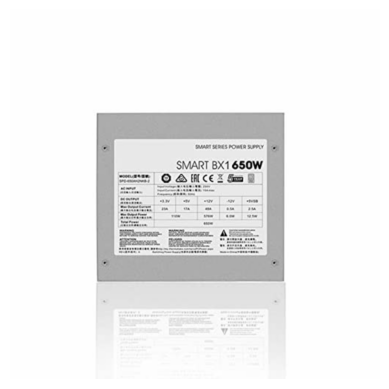

[([[746, 544], [1034, 544], [1034, 572], [746, 572]], 'Sn #mesPomr Srly', 0.006455169352629234), ([[664, 601], [1035, 601], [1035, 661], [664, 661]], 'SMART BX1 650w', 0.8672176911936263), ([[725, 663], [869, 663], [869, 707], [725, 707]], 'EFL C€ 2', 0.3053735512614905)]
first: ['', 'BX1650w', '2']
before ['BX1650 w', '2']
before ['BX1650 watt', '2']
No valid entity values found for wattage in image 3101lgy28BL.jpg

Entity :  item_weight
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


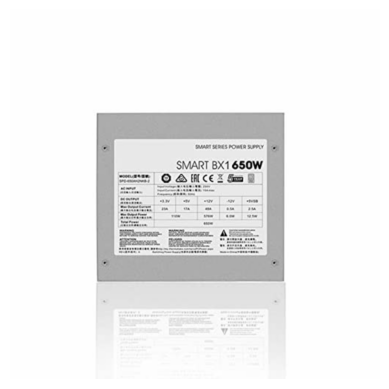

[([[746, 544], [1034, 544], [1034, 572], [746, 572]], 'Sn #mesPomr Srly', 0.006455169352629234), ([[664, 601], [1035, 601], [1035, 661], [664, 661]], 'SMART BX1 650w', 0.8672176911936263), ([[725, 663], [869, 663], [869, 707], [725, 707]], 'EFL C€ 2', 0.3053735512614905)]
first: ['', 'BX1650w', '2']
before ['BX1650 w', '2']
before ['BX1650 w', '2']
No valid entity values found for item_weight in image 3101lgy28BL.jpg

Entity :  item_weight
Original Image Dimensions: Width=331, Height=152, Area=50312
Scaled Image Dimensions: Width=993, Height=456


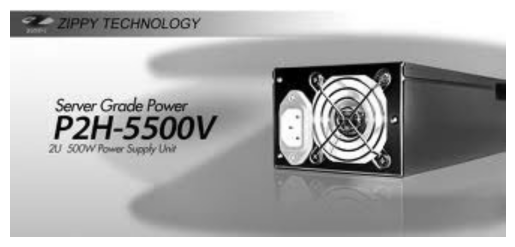

[([[92, 14], [385, 14], [385, 44], [92, 44]], 'Zippy TECHNOLOGY', 0.4287177672614605), ([[85, 172], [363, 172], [363, 211], [85, 211]], 'Server Grade Power', 0.9709328149731692), ([[83, 205], [421, 205], [421, 269], [83, 269]], 'P2H-5S00V', 0.3058408262282891), ([[72, 264], [338, 264], [338, 294], [72, 294]], 'ZU 50O#Roeu SAy lt', 0.01035983789888043)]
first: ['', '', 'P2H-5S00V', '50O#Roeu']
before ['P2 H-5 S00 V', '50 O#Roeu']
before ['P2 H-5 S00 V', '50 O#Roeu']
No valid entity values found for item_weight in image 3105qskWRcL.jpg

Entity :  wattage
Original Image Dimensions: Width=331, Height=152, Area=50312
Scaled Image Dimensions: Width=993, Height=456


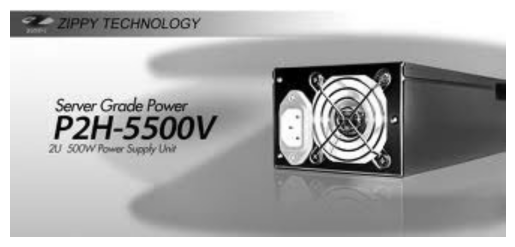

[([[92, 14], [385, 14], [385, 44], [92, 44]], 'Zippy TECHNOLOGY', 0.4287177672614605), ([[85, 172], [363, 172], [363, 211], [85, 211]], 'Server Grade Power', 0.9709328149731692), ([[83, 205], [421, 205], [421, 269], [83, 269]], 'P2H-5S00V', 0.3058408262282891), ([[72, 264], [338, 264], [338, 294], [72, 294]], 'ZU 50O#Roeu SAy lt', 0.01035983789888043)]
first: ['', '', 'P2H-5S00V', '50O#Roeu']
before ['P2 H-5 S00 V', '50 O#Roeu']
before ['P2 H-5 S00 V', '50 O#Roeu']
No valid entity values found for wattage in image 3105qskWRcL.jpg

Entity :  item_weight
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


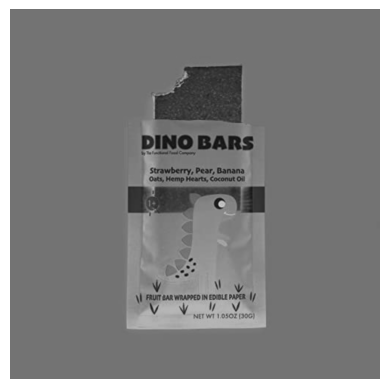

[([[523, 498], [998, 498], [998, 583], [523, 583]], 'DINO BARS', 0.9342832574089206), ([[560, 632], [957, 632], [957, 677], [560, 677]], 'Strawberry; Pear; Banana', 0.7051523819832399), ([[558, 671], [959, 671], [959, 709], [558, 709]], 'Oa6x, Hemp Heart; Coconut Oul', 0.14243412023799729), ([[505, 1147], [1001, 1147], [1001, 1191], [505, 1191]], 'I Frutt Bar Wrapped IN EDiDLE Paper I/', 0.02650850675031078), ([[801, 1187], [839, 1187], [839, 1229], [801, 1229]], '07', 0.08492943480606932), ([[737, 1226], [999, 1226], [999, 1263], [737, 1263]], 'NET WT L.O502 (joGi', 0.20913756101750028)]
first: ['', '', 'Oa6x', '', '07', 'L.O502(joGi']
before ['Oa6 x', '07', 'L.O502(joGi']
before ['Oa6 x', '07', 'L.O502(joGi']
No valid entity values found for item_weight in image 3106Kd8KjnL.jpg

Entity :  item_weight
Original Image Dimensions: Width=143, Height=500, Area=71500
Scaled Image Dimensions: Width=429, Height=1500


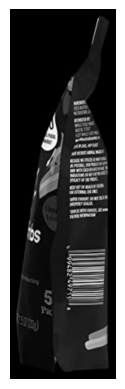

[([[139, 827], [192, 827], [192, 864], [139, 864]], '6au', 0.06662839651962982), ([[65, 869], [133, 869], [133, 955], [65, 955]], 'Vs', 0.17429063128460293), ([[133, 1135], [177, 1135], [177, 1201], [133, 1201]], '5', 0.9999762774920704), ([[120.00019994002, 1193.1009797060979], [184.6757972264493, 1208.228864686951], [173.99980005998, 1251.8990202939021], [109.32420277355071, 1236.771135313049]], 'Pac', 0.727855259537245), ([[27.942690239271858, 1228.0701767945388], [136.6097825515901, 1253.5319624157005], [119.05730976072815, 1318.9298232054612], [10.3902174484099, 1294.4680375842995]], 'KSwPU)', 0.02300217446315495)]
first: ['6au', '', '5', '', '']
before ['6 au', '5']
before ['6 au', '5']
No valid entity values found for item_weight in image 3106iDqsfQL.jpg

Entity :  width
Original Image Dimensions: Width=1001, Height=1001, Area=1002001


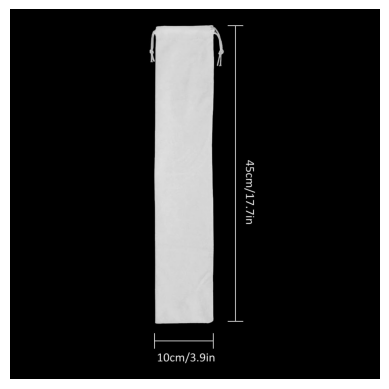

[([[634, 406], [666, 406], [666, 588], [634, 588]], '0', 0.5644235337970258), ([[388, 870], [558, 870], [558, 926], [388, 926]], 'L ', 0.16471452974308431), ([[395, 925], [561, 925], [561, 963], [395, 963]], '10cm/3.9in', 0.9902600301279441)]
first: ['0', '', '10cm/3.9in']
before ['0', '10 cm', '3.9 in']
before ['0', '10 centimetre', '3.9 inch']
10.0
centimetre
3.9
inch
Best Entity Value for width: 10 centimetre

Entity :  depth
Original Image Dimensions: Width=1001, Height=1001, Area=1002001


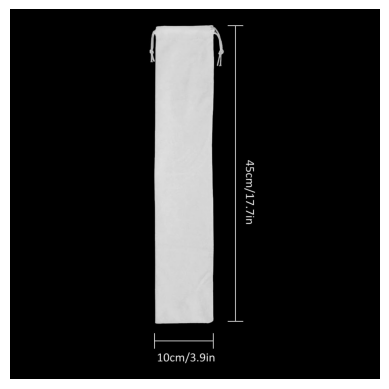

[([[634, 406], [666, 406], [666, 588], [634, 588]], '0', 0.5644235337970258), ([[388, 870], [558, 870], [558, 926], [388, 926]], 'L ', 0.16471452974308431), ([[395, 925], [561, 925], [561, 963], [395, 963]], '10cm/3.9in', 0.9902600301279441)]
first: ['0', '', '10cm/3.9in']
before ['0', '10 cm', '3.9 in']
before ['0', '10 centimetre', '3.9 inch']
10.0
centimetre
3.9
inch
Best Entity Value for depth: 3.9 inch

Entity :  item_weight
Original Image Dimensions: Width=300, Height=288, Area=86400
Scaled Image Dimensions: Width=900, Height=864


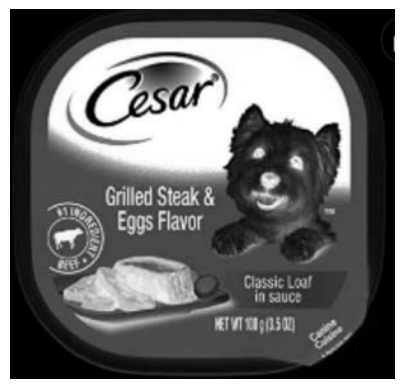

[([[166, 134], [524, 134], [524, 282], [166, 282]], 'Cesar )', 0.558115772370171), ([[213, 403], [487, 403], [487, 469], [213, 469]], 'Grilled Steak &', 0.7554318212916453), ([[240, 460], [464, 460], [464, 536], [240, 536]], 'Eggs Flavor', 0.999208208257183), ([[538, 612], [716, 612], [716, 660], [538, 660]], 'Classic Lcul', 0.48575232997725265), ([[565, 655], [689, 655], [689, 693], [565, 693]], 'In Juce', 0.45605746088621096), ([[468, 710], [674, 710], [674, 762], [468, 762]], 'KeTVI1;01504', 0.07251294607832393)]
first: ['', '', '', '', '', 'KeTV/1;01504']
before ['KeTV', '1;01504']
before ['KeTV', '1;01504']
No valid entity values found for item_weight in image 310BVU1bXvL.jpg

Entity :  depth
Original Image Dimensions: Width=700, Height=1010, Area=707000


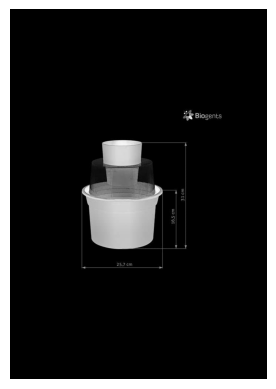

[([[498, 277], [581, 277], [581, 309], [498, 309]], 'Biogents', 0.9999817081984501), ([[289, 691], [337, 691], [337, 705], [289, 705]], '25,7 cm', 0.8535308615103306)]
first: ['', '25,7cm']
before ['25', '7 cm']
before ['25', '7 centimetre']
7.0
centimetre
Best Entity Value for depth: 7 centimetre

Entity :  item_weight
Original Image Dimensions: Width=500, Height=63, Area=31500
Scaled Image Dimensions: Width=1500, Height=189


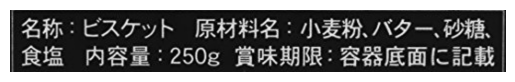

[([[26, 18], [502, 18], [502, 98], [26, 98]], 'Gm : ExTvh', 0.12012890969037779), ([[549, 13], [1453, 13], [1453, 103], [549, 103]], '514z: 1zm./1 _ 1814', 0.02008015325122213), ([[27, 99], [183, 99], [183, 183], [27, 183]], 'p13', 0.05923376774324611), ([[211, 97], [1477, 97], [1477, 187], [211, 187]], '012r: 250g FitIABR : Z#EmI-a#', 0.01550635648642811)]
first: ['', '514zzm./1', 'p13', '012rg']
before ['514 zzm.', '1', 'p13', '012 rg']
before ['514 zzm.', '1', 'p13', '012 rg']
No valid entity values found for item_weight in image 310ICDHEK-L.jpg

Entity :  maximum_weight_recommendation
Original Image Dimensions: Width=500, Height=484, Area=242000
Scaled Image Dimensions: Width=1500, Height=1452


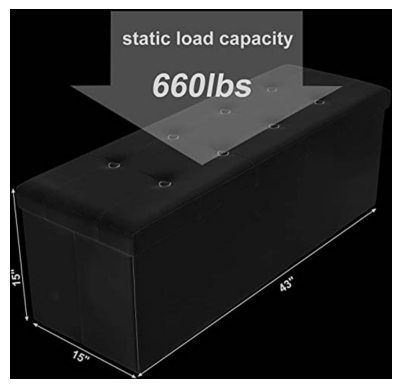

[([[427, 72], [1122, 72], [1122, 168], [427, 168]], 'static load capacity', 0.7652671408359712), ([[549, 236], [961, 236], [961, 362], [549, 362]], '660lbs', 0.8863684291170258), ([[0, 1016], [46, 1016], [46, 1094], [0, 1094]], '#', 0.3983598118123979), ([[1041.0861424129282, 1081.7550563432708], [1108.3076923076924, 1030.4615384615386], [1135.9138575870718, 1074.2449436567292], [1068.6923076923076, 1125.5384615384614]], '43"', 0.6522549042464441), ([[250.27253004752583, 1328.0532043231758], [325.99460043039034, 1364.7676930032376], [305.72746995247417, 1405.9467956768242], [230.00539956960966, 1369.2323069967624]], '15"', 0.998482138852891)]
first: ['', '660lbs', '', '43 in', '15 in']
before ['660 lbs', '43 in', '15 in']
before ['660 pound', '43 in', '15 in']
660.0
pound
Best Entity Value for maximum_weight_recommendation: 660 pound

Entity :  item_weight
Original Image Dimensions: Width=333, Height=500, Area=166500
Scaled Image Dimensions: Width=999, Height=1500


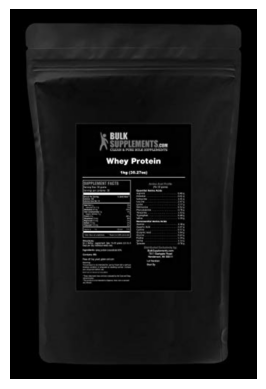

[([[397, 493], [483, 493], [483, 535], [397, 535]], 'BULK', 0.9973773956298828), ([[395, 520], [608, 520], [608, 572], [395, 572]], 'SUPPLEMENTS', 0.7104768251105212), ([[601, 545], [635, 545], [635, 563], [601, 563]], 'Got', 0.0925082745763032), ([[381, 593], [618, 593], [618, 641], [381, 641]], 'Whey Protein', 0.9883948485432832), ([[474, 652], [560, 652], [560, 676], [474, 676]], 'YeTtori', 0.0024452719642695992), ([[389, 692], [444, 692], [444, 718], [389, 718]], 'Fecin', 0.015488174197743886), ([[445.1055728090001, 653.2111456180002], [480.92703581925986, 659.4647122724278], [477.8944271909999, 676.7888543819998], [441.07296418074014, 670.5352877275722]], 'Aen', 0.0028537561545302)]
first: ['', '', '', '', '', '', '']
before []
before []
No valid entity values found for item_weight in image 310Qevq+VSL.jpg

Entity :  item_weight
Original Image Dimensions: Width=468, Height=492, Area=230256
Scaled Image Dimensions: Width=1404, Height=1476


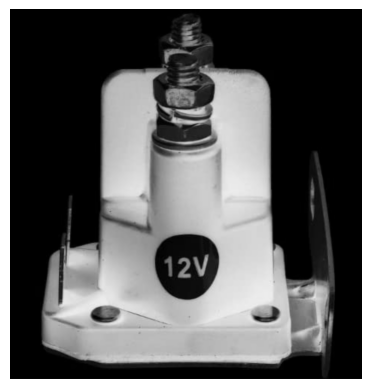

[([[598, 970], [806, 970], [806, 1086], [598, 1086]], '12V', 0.45416470764208783)]
first: ['12V']
before ['12 V']
before ['12 V']
No valid entity values found for item_weight in image 310Th3tbqRL.jpg

Entity :  voltage
Original Image Dimensions: Width=468, Height=492, Area=230256
Scaled Image Dimensions: Width=1404, Height=1476


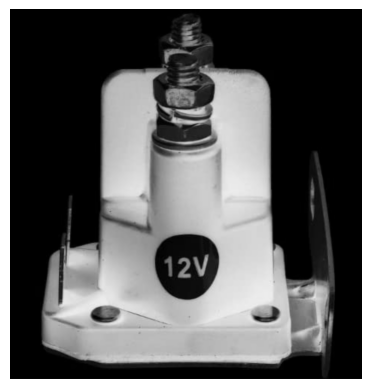

[([[598, 970], [806, 970], [806, 1086], [598, 1086]], '12V', 0.45416470764208783)]
first: ['12V']
before ['12 V']
before ['12 volt']
12.0
volt
Best Entity Value for voltage: 12 volt

Entity :  height
Original Image Dimensions: Width=427, Height=500, Area=213500
Scaled Image Dimensions: Width=1281, Height=1500


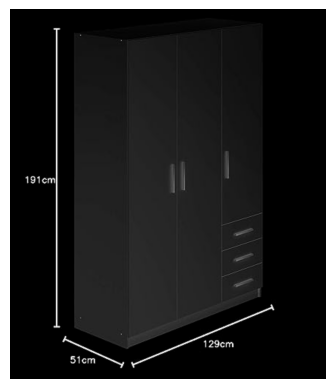

[([[57, 673], [189, 673], [189, 713], [57, 713]], '191cm', 0.6641073379655603), ([[778, 1335], [913, 1335], [913, 1380], [778, 1380]], '129cm', 0.7074711282828884), ([[241, 1402], [351, 1402], [351, 1442], [241, 1442]], 'S1cm', 0.755850076675415)]
first: ['191cm', '129cm', 'S1cm']
before ['191 cm', '129 cm', 'S1 cm']
before ['191 centimetre', '129 centimetre', 'S1 centimetre']
191.0
centimetre
129.0
centimetre
Best Entity Value for height: 191 centimetre

Entity :  width
Original Image Dimensions: Width=1024, Height=1024, Area=1048576


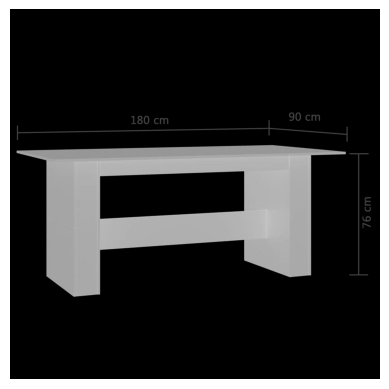

[([[330, 292], [442, 292], [442, 324], [330, 324]], '180 cm', 0.6236471676844868), ([[767, 281], [865, 281], [865, 317], [767, 317]], '90 cm', 0.9933883602827004), ([[976, 518], [1004, 518], [1004, 566], [976, 566]], '5', 0.3117565493489707), ([[972, 568], [1004, 568], [1004, 612], [972, 612]], '(0', 0.8132388513426765)]
first: ['180cm', '90cm', '5', '(0']
before ['180 cm', '90 cm', '5', '(0']
before ['180 centimetre', '90 centimetre', '5', '(0']
180.0
centimetre
90.0
centimetre
Best Entity Value for width: 180 centimetre

Entity :  item_weight
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


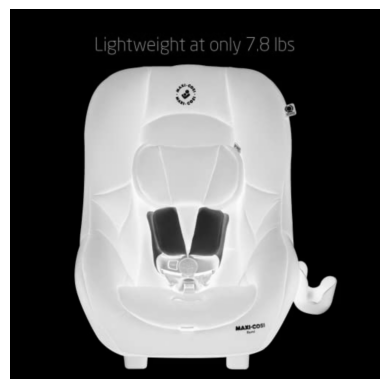

[([[335, 103], [803, 103], [803, 193], [335, 193]], 'Lightweight at', 0.9989022160601849), ([[950, 104], [1164, 104], [1164, 182], [950, 182]], '7,8 Ibs', 0.39915832486439906), ([[809.9308939388299, 89.05731363111714], [958.4217032750431, 115.64865588203163], [940.0691060611701, 201.94268636888287], [790.5782967249569, 175.35134411796838]], 'only', 0.9983925819396973), ([[906.5611569566013, 1278.8295040435817], [1040.791688929739, 1266.7259925196076], [1042.4388430433987, 1298.1704959564183], [908.2083110702611, 1311.2740074803924]], 'MAXI-Cos', 0.07078885168923524)]
first: ['', '7,8Ibs', '', '']
before ['7', '8 Ibs']
before ['7', '8 Ibs']
No valid entity values found for item_weight in image 310X-ftA6SL.jpg

Entity :  width
Original Image Dimensions: Width=1024, Height=1024, Area=1048576


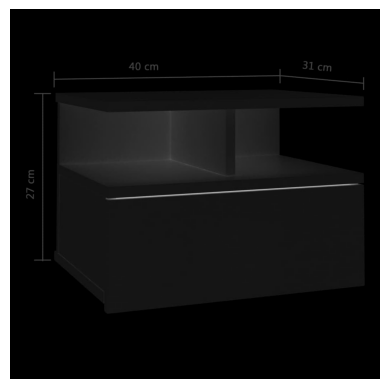

[([[326, 144], [414, 144], [414, 174], [326, 174]], '40 cm', 0.37073296233523645), ([[805, 139], [895, 139], [895, 177], [805, 177]], '31 cm', 0.9882053509502086), ([[46, 442], [70, 442], [70, 486], [46, 486]], '6', 0.6355356712526863), ([[40, 490], [72, 490], [72, 532], [40, 532]], 'N', 0.5719080583908784)]
first: ['40cm', '31cm', '6', '']
before ['40 cm', '31 cm', '6']
before ['40 centimetre', '31 centimetre', '6']
40.0
centimetre
31.0
centimetre
Best Entity Value for width: 40 centimetre

Entity :  width
Original Image Dimensions: Width=1010, Height=1010, Area=1020100


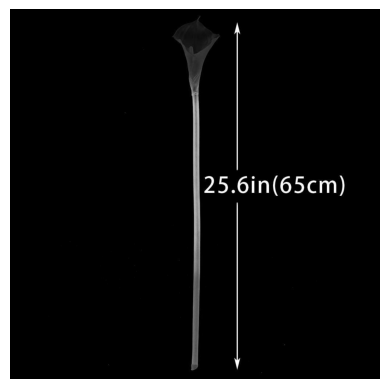

[([[521, 444], [923, 444], [923, 518], [521, 518]], '25.6in(65cm)', 0.9558642532396981)]
first: ['25.6in(65cm']
before ['25.6 in(65 cm']
before ['25.6 in(65 centimetre']
No valid entity values found for width in image 310aYU-JigL.jpg

Entity :  height
Original Image Dimensions: Width=1010, Height=1010, Area=1020100


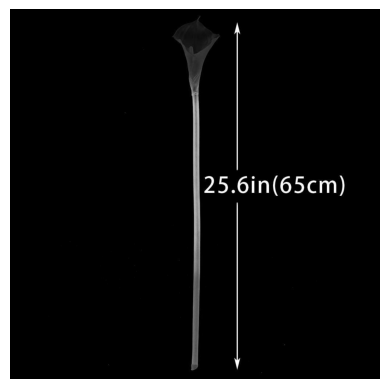

[([[521, 444], [923, 444], [923, 518], [521, 518]], '25.6in(65cm)', 0.9558642532396981)]
first: ['25.6in(65cm']
before ['25.6 in(65 cm']
before ['25.6 in(65 centimetre']
No valid entity values found for height in image 310aYU-JigL.jpg

Entity :  depth
Original Image Dimensions: Width=1010, Height=1010, Area=1020100


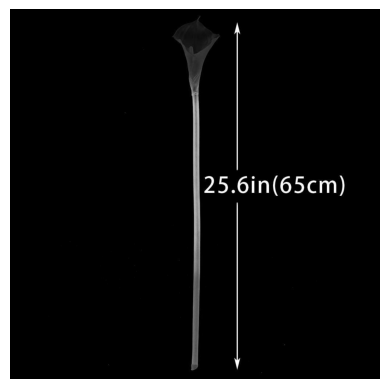

[([[521, 444], [923, 444], [923, 518], [521, 518]], '25.6in(65cm)', 0.9558642532396981)]
first: ['25.6in(65cm']
before ['25.6 in(65 cm']
before ['25.6 in(65 centimetre']
No valid entity values found for depth in image 310aYU-JigL.jpg

Entity :  maximum_weight_recommendation
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


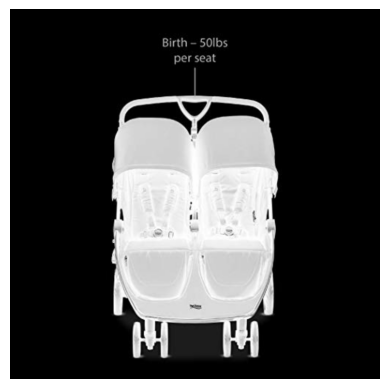

[([[611, 110], [725, 110], [725, 160], [611, 160]], 'Birth', 0.7066238932673574), ([[733, 133], [757, 133], [757, 149], [733, 149]], '3', 0.018225741745627966), ([[761, 106], [890, 106], [890, 162], [761, 162]], '50lbs', 0.4926042208672605), ([[658, 176], [842, 176], [842, 232], [658, 232]], 'per seat', 0.88748136438454), ([[874, 1252], [1024, 1252], [1024, 1410], [874, 1410]], 'WA', 0.09757279306740901)]
first: ['', '3', '50lbs', '', '']
before ['3', '50 lbs']
before ['3', '50 pound']
50.0
pound
Best Entity Value for maximum_weight_recommendation: 50 pound

Entity :  height
Original Image Dimensions: Width=1080, Height=1080, Area=1166400


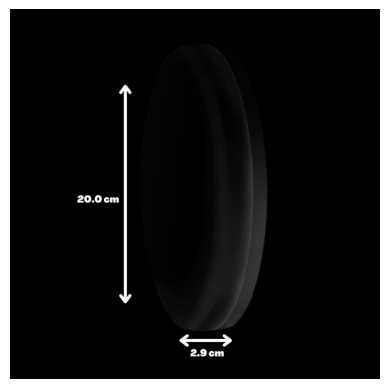

[([[192, 540], [320, 540], [320, 572], [192, 572]], 'zo.Ocm', 0.676013338836192), ([[524, 990], [628, 990], [628, 1020], [524, 1020]], '2.9cm', 0.9079892713623992)]
first: ['', '2.9cm']
before ['2.9 cm']
before ['2.9 centimetre']
2.9
centimetre
Best Entity Value for height: 2.9 centimetre

Entity :  depth
Original Image Dimensions: Width=1080, Height=1080, Area=1166400


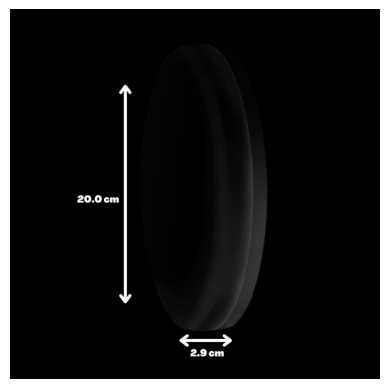

[([[192, 540], [320, 540], [320, 572], [192, 572]], 'zo.Ocm', 0.676013338836192), ([[524, 990], [628, 990], [628, 1020], [524, 1020]], '2.9cm', 0.9079892713623992)]
first: ['', '2.9cm']
before ['2.9 cm']
before ['2.9 centimetre']
2.9
centimetre
Best Entity Value for depth: 2.9 centimetre

Entity :  height
Original Image Dimensions: Width=1001, Height=1001, Area=1002001


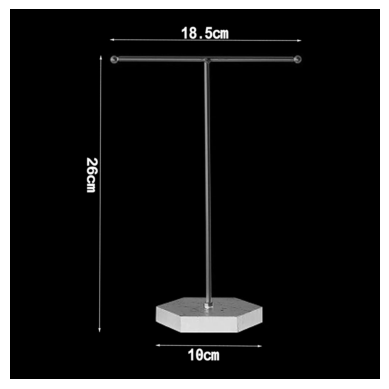

[([[457, 43], [597, 43], [597, 87], [457, 87]], '18_Scm', 0.8187299809145091), ([[203, 397], [241, 397], [241, 503], [203, 503]], '8', 0.7266081235434321), ([[475, 913], [573, 913], [573, 957], [475, 957]], '1Ocm', 0.6462391885416582)]
first: ['18_Scm', '8', '1Ocm']
before ['18_Scm', '8', '1 Ocm']
before ['18_Scm', '8', '1 Ocm']
No valid entity values found for height in image 310kcUKMHOL.jpg

Entity :  height
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


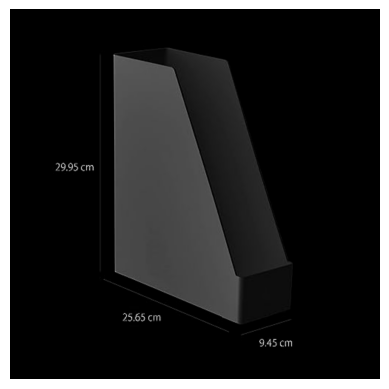

[([[176, 616], [346, 616], [346, 664], [176, 664]], '29.95 cm', 0.40192267510956803), ([[448, 1226], [619, 1226], [619, 1275], [448, 1275]], '25,65 cm', 0.5107645340042813), ([[1003, 1331], [1151, 1331], [1151, 1375], [1003, 1375]], '945cm', 0.2805807742482257)]
first: ['29.95cm', '25,65cm', '945cm']
before ['29.95 cm', '25', '65 cm', '945 cm']
before ['29.95 centimetre', '25', '65 centimetre', '945 centimetre']
29.95
centimetre
65.0
centimetre
945.0
centimetre
Best Entity Value for height: 29.95 centimetre

Entity :  width
Original Image Dimensions: Width=1000, Height=1000, Area=1000000


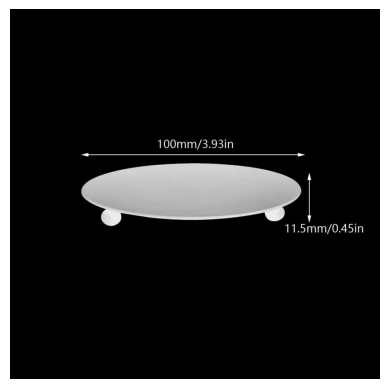

[([[394, 346], [609, 346], [609, 385], [394, 385]], '100mm/3.93in', 0.6878879318820612), ([[739, 575], [961, 575], [961, 613], [739, 613]], '11.5mm/0:5in', 0.45768382132191665)]
first: ['100mm/3.93in', '11.5mm/05in']
before ['100 mm', '3.93 in', '11.5 mm', '05 in']
before ['100 millimetre', '3.93 inch', '11.5 millimetre', '05 inch']
100.0
millimetre
3.93
inch
11.5
millimetre
5.0
inch
Best Entity Value for width: 11.5 millimetre

Entity :  depth
Original Image Dimensions: Width=1000, Height=1000, Area=1000000


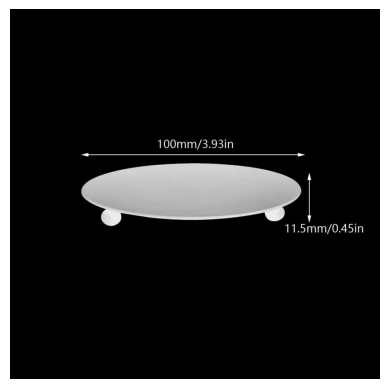

[([[394, 346], [609, 346], [609, 385], [394, 385]], '100mm/3.93in', 0.6878879318820612), ([[739, 575], [961, 575], [961, 613], [739, 613]], '11.5mm/0:5in', 0.45768382132191665)]
first: ['100mm/3.93in', '11.5mm/05in']
before ['100 mm', '3.93 in', '11.5 mm', '05 in']
before ['100 millimetre', '3.93 inch', '11.5 millimetre', '05 inch']
100.0
millimetre
3.93
inch
11.5
millimetre
5.0
inch
Best Entity Value for depth: 05 inch

Entity :  height
Original Image Dimensions: Width=1024, Height=1024, Area=1048576


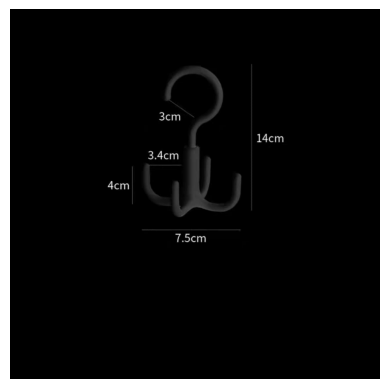

[([[410, 282], [476, 282], [476, 314], [410, 314]], '3cm', 0.9997324800161543), ([[680, 342], [762, 342], [762, 374], [680, 374]], '14cm', 0.9928417205810547), ([[380, 390], [472, 390], [472, 422], [380, 422]], '3.4cm', 0.64412497191393), ([[265, 470], [336, 470], [336, 508], [265, 508]], '4cm', 0.9906606662650146), ([[452, 615], [549, 615], [549, 653], [452, 653]], '7.Scm', 0.7107617665997317)]
first: ['3cm', '14cm', '3.4cm', '4cm', '7.Scm']
before ['3 cm', '14 cm', '3.4 cm', '4 cm', '7.Scm']
before ['3 centimetre', '14 centimetre', '3.4 centimetre', '4 centimetre', '7.Scm']
3.0
centimetre
14.0
centimetre
3.4
centimetre
4.0
centimetre
Best Entity Value for height: 14 centimetre

Entity :  depth
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


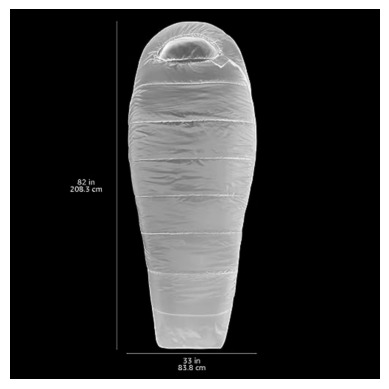

[([[267, 685], [351, 685], [351, 721], [267, 721]], '82 in', 0.8328687678343304), ([[238, 712], [381, 712], [381, 749], [238, 749]], '208.3 crti', 0.2570859588442201), ([[696, 1410], [778, 1410], [778, 1442], [696, 1442]], '33in', 0.9872623085975647), ([[676, 1438], [796, 1438], [796, 1470], [676, 1470]], '83.8 cm', 0.5030472375705985)]
first: ['82in', '208.3crti', '33in', '83.8cm']
before ['82 in', '208.3 crti', '33 in', '83.8 cm']
before ['82 inch', '208.3 crti', '33 inch', '83.8 centimetre']
82.0
inch
33.0
inch
83.8
centimetre
Best Entity Value for depth: 82 inch

Entity :  width
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


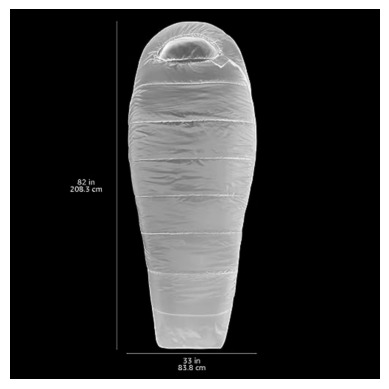

[([[267, 685], [351, 685], [351, 721], [267, 721]], '82 in', 0.8328687678343304), ([[238, 712], [381, 712], [381, 749], [238, 749]], '208.3 crti', 0.2570859588442201), ([[696, 1410], [778, 1410], [778, 1442], [696, 1442]], '33in', 0.9872623085975647), ([[676, 1438], [796, 1438], [796, 1470], [676, 1470]], '83.8 cm', 0.5030472375705985)]
first: ['82in', '208.3crti', '33in', '83.8cm']
before ['82 in', '208.3 crti', '33 in', '83.8 cm']
before ['82 inch', '208.3 crti', '33 inch', '83.8 centimetre']
82.0
inch
33.0
inch
83.8
centimetre
Best Entity Value for width: 83.8 centimetre

Entity :  depth
Original Image Dimensions: Width=1020, Height=1020, Area=1040400


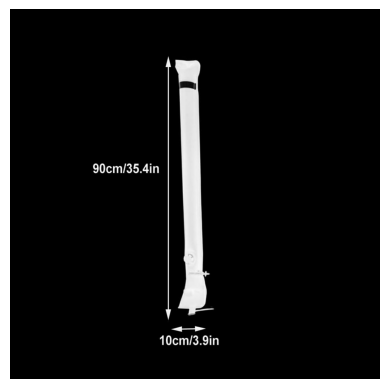

[([[221, 419], [417, 419], [417, 459], [221, 459]], '90cm/35.4in', 0.8997152507993129), ([[409, 895], [583, 895], [583, 933], [409, 933]], '10cm/3.9in', 0.9567483269477439)]
first: ['90cm/35.4in', '10cm/3.9in']
before ['90 cm', '35.4 in', '10 cm', '3.9 in']
before ['90 centimetre', '35.4 inch', '10 centimetre', '3.9 inch']
90.0
centimetre
35.4
inch
10.0
centimetre
3.9
inch
Best Entity Value for depth: 3.9 inch

Entity :  height
Original Image Dimensions: Width=1020, Height=1020, Area=1040400


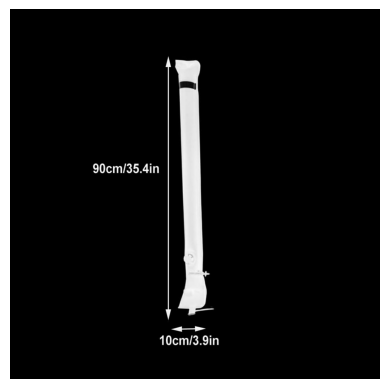

[([[221, 419], [417, 419], [417, 459], [221, 459]], '90cm/35.4in', 0.8997152507993129), ([[409, 895], [583, 895], [583, 933], [409, 933]], '10cm/3.9in', 0.9567483269477439)]
first: ['90cm/35.4in', '10cm/3.9in']
before ['90 cm', '35.4 in', '10 cm', '3.9 in']
before ['90 centimetre', '35.4 inch', '10 centimetre', '3.9 inch']
90.0
centimetre
35.4
inch
10.0
centimetre
3.9
inch
Best Entity Value for height: 90 centimetre

Entity :  width
Original Image Dimensions: Width=1020, Height=1020, Area=1040400


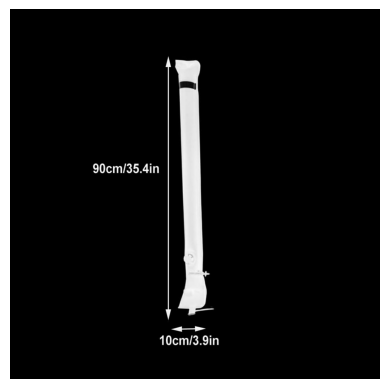

[([[221, 419], [417, 419], [417, 459], [221, 459]], '90cm/35.4in', 0.8997152507993129), ([[409, 895], [583, 895], [583, 933], [409, 933]], '10cm/3.9in', 0.9567483269477439)]
first: ['90cm/35.4in', '10cm/3.9in']
before ['90 cm', '35.4 in', '10 cm', '3.9 in']
before ['90 centimetre', '35.4 inch', '10 centimetre', '3.9 inch']
90.0
centimetre
35.4
inch
10.0
centimetre
3.9
inch
Best Entity Value for width: 10 centimetre

Entity :  item_volume
Original Image Dimensions: Width=161, Height=500, Area=80500
Scaled Image Dimensions: Width=483, Height=1500


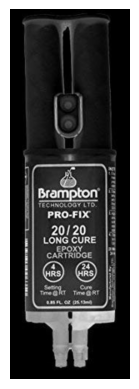

[([[104, 714], [362, 714], [362, 786], [104, 786]], 'Brampton', 0.9465094110271693), ([[110, 780], [348, 780], [348, 810], [110, 810]], 'Technology LTD', 0.11542537560781699), ([[143, 807], [332, 807], [332, 857], [143, 857]], 'PRO-FIX', 0.8955417745429416), ([[156, 864], [315, 864], [315, 928], [156, 928]], '20/20', 0.9972064159562942), ([[126, 912], [354, 912], [354, 960], [126, 960]], 'LONG CURE', 0.9983592347880239), ([[181, 955], [299, 955], [299, 991], [181, 991]], 'EPOXY', 0.29718960119381316), ([[141, 981], [337, 981], [337, 1017], [141, 1017]], 'CARTRIDGE', 0.9313578234153211), ([[284, 1028], [322, 1028], [322, 1056], [284, 1056]], '24', 0.3817394251219329), ([[135, 1055], [211, 1055], [211, 1091], [135, 1091]], 'HRS', 0.9832227970922406), ([[266, 1052], [344, 1052], [344, 1091], [266, 1091]], 'HRS', 0.9782743460939953), ([[276, 1114], [334, 1114], [334, 1140], [276, 1140]], 'Cud', 0.13613198525374573), ([[109, 1106], [235, 1106], [235, 1175], [109, 1175]], 'Tncakr', 0.2006362

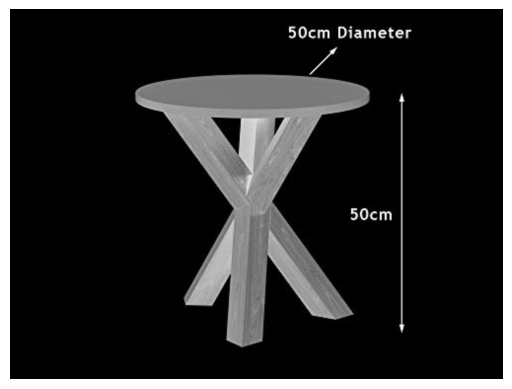

[([[838, 44], [1230, 44], [1230, 98], [838, 98]], '5Ocm Diameter', 0.6942929500699516), ([[1028, 598], [1168, 598], [1168, 648], [1028, 648]], '50cm', 0.49184855818748474), ([[693.2400123098244, 747.0321452559276], [768.2210038137063, 762.4962232856707], [743.7599876901756, 882.9678547440724], [667.7789961862937, 867.5037767143293]], '4', 0.06604262733429866)]
first: ['5Ocm', '50cm', '4']
before ['5 Ocm', '50 cm', '4']
before ['5 Ocm', '50 centimetre', '4']
50.0
centimetre
Best Entity Value for width: 50 centimetre

Entity :  depth
Original Image Dimensions: Width=500, Height=375, Area=187500
Scaled Image Dimensions: Width=1500, Height=1125


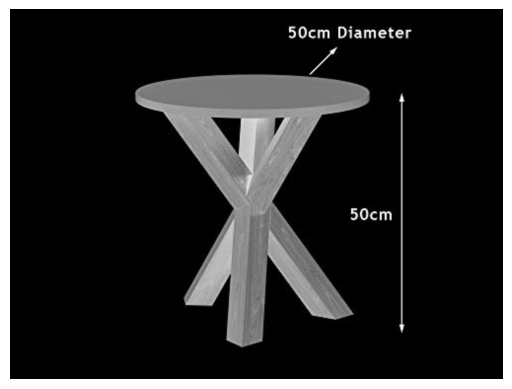

[([[838, 44], [1230, 44], [1230, 98], [838, 98]], '5Ocm Diameter', 0.6942929500699516), ([[1028, 598], [1168, 598], [1168, 648], [1028, 648]], '50cm', 0.49184855818748474), ([[693.2400123098244, 747.0321452559276], [768.2210038137063, 762.4962232856707], [743.7599876901756, 882.9678547440724], [667.7789961862937, 867.5037767143293]], '4', 0.06604262733429866)]
first: ['5Ocm', '50cm', '4']
before ['5 Ocm', '50 cm', '4']
before ['5 Ocm', '50 centimetre', '4']
50.0
centimetre
Best Entity Value for depth: 50 centimetre

Entity :  item_weight
Original Image Dimensions: Width=250, Height=250, Area=62500
Scaled Image Dimensions: Width=750, Height=750


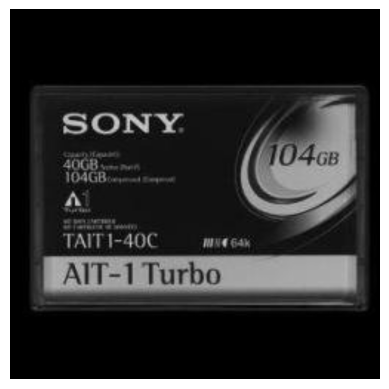

[([[100, 201], [361, 201], [361, 263], [100, 263]], 'SONY', 0.7455242872238159), ([[104, 300], [186, 300], [186, 330], [104, 330]], 'Zoob', 0.1131519228219986), ([[223, 313], [267, 313], [267, 331], [223, 331]], 'a', 0.018457659158928275), ([[513, 262], [678, 262], [678, 330], [513, 330]], '104G8', 0.548307683331705), ([[108, 326], [202, 326], [202, 356], [108, 356]], 'JonGb', 0.06623299816701612), ([[102, 444], [308, 444], [308, 492], [102, 492]], 'TAITI-4UC', 0.36977815535617886), ([[101, 505], [437, 505], [437, 567], [101, 567]], 'AIT-I Turbo', 0.8153596601129055)]
first: ['', '', '', '104G8', '', 'TAITI-4UC', '']
before ['104 G8', 'TAITI-4 UC']
before ['104 G8', 'TAITI-4 UC']
No valid entity values found for item_weight in image 3111QvQTfJL.jpg

Entity :  height
Original Image Dimensions: Width=500, Height=251, Area=125500
Scaled Image Dimensions: Width=1500, Height=753


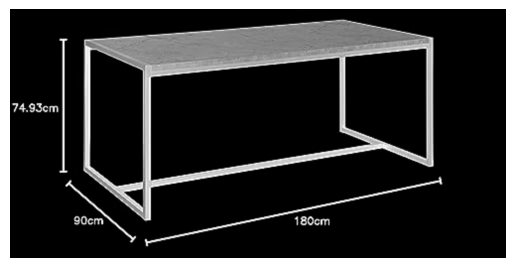

[([[1, 279], [153, 279], [153, 319], [1, 319]], '74.93cm', 0.8785939753843623), ([[186, 620], [286, 620], [286, 658], [186, 658]], 'g0cm', 0.5738146901130676), ([[852, 619], [975, 619], [975, 662], [852, 662]], '180cm', 0.5821265604872196)]
first: ['74.93cm', 'g0cm', '180cm']
before ['74.93 cm', 'g0 cm', '180 cm']
before ['74.93 centimetre', 'g0 centimetre', '180 centimetre']
74.93
centimetre
180.0
centimetre
Best Entity Value for height: 74.93 centimetre

Entity :  depth
Original Image Dimensions: Width=1006, Height=1006, Area=1012036


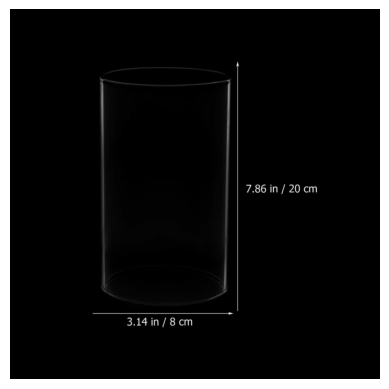

[([[637, 471], [841, 471], [841, 507], [637, 507]], '7.86 in / 20 cm', 0.8155258859820887), ([[313, 835], [501, 835], [501, 871], [313, 871]], '3.14 in / 8 cm', 0.733515260262029)]
first: ['7.86incm', '3.14incm']
before ['7.86 incm', '3.14 incm']
before ['7.86 incm', '3.14 incm']
No valid entity values found for depth in image 3118BjQXgAL.jpg

Entity :  height
Original Image Dimensions: Width=1006, Height=1006, Area=1012036


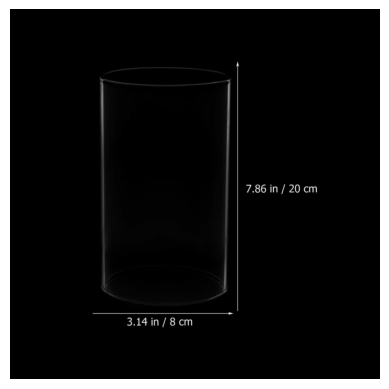

[([[637, 471], [841, 471], [841, 507], [637, 507]], '7.86 in / 20 cm', 0.8155258859820887), ([[313, 835], [501, 835], [501, 871], [313, 871]], '3.14 in / 8 cm', 0.733515260262029)]
first: ['7.86incm', '3.14incm']
before ['7.86 incm', '3.14 incm']
before ['7.86 incm', '3.14 incm']
No valid entity values found for height in image 3118BjQXgAL.jpg

Entity :  width
Original Image Dimensions: Width=1000, Height=1000, Area=1000000


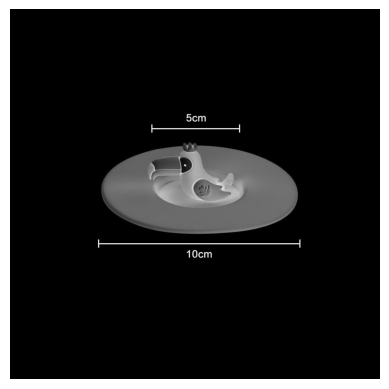

[([[472, 280], [536, 280], [536, 310], [472, 310]], 'Scm', 0.9815087275203725), ([[474, 648], [552, 648], [552, 678], [474, 678]], '10cm', 0.6114641427993774)]
first: ['', '10cm']
before ['10 cm']
before ['10 centimetre']
10.0
centimetre
Best Entity Value for width: 10 centimetre

Entity :  height
Original Image Dimensions: Width=1000, Height=1000, Area=1000000


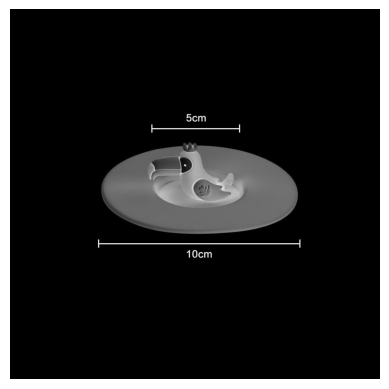

[([[472, 280], [536, 280], [536, 310], [472, 310]], 'Scm', 0.9815087275203725), ([[474, 648], [552, 648], [552, 678], [474, 678]], '10cm', 0.6114641427993774)]
first: ['', '10cm']
before ['10 cm']
before ['10 centimetre']
10.0
centimetre
Best Entity Value for height: 10 centimetre

Entity :  width
Original Image Dimensions: Width=1000, Height=1000, Area=1000000


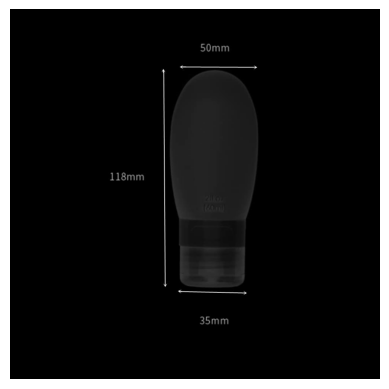

[([[510, 90], [598, 90], [598, 120], [510, 120]], 'S0mm', 0.4998326022398373), ([[264, 438], [368, 438], [368, 470], [264, 470]], '118mm', 0.8075452832403723), ([[521, 498], [580, 498], [580, 524], [521, 524]], 'Wlae', 0.0009526259964331985), ([[516, 524], [584, 524], [584, 550], [516, 550]], 'Keadiaat', 0.0004958061208164926), ([[508, 826], [596, 826], [596, 858], [508, 858]], '35mm', 0.9949064254760742)]
first: ['S0mm', '118mm', '', '', '35mm']
before ['S0 mm', '118 mm', '35 mm']
before ['S0 millimetre', '118 millimetre', '35 millimetre']
118.0
millimetre
35.0
millimetre
Best Entity Value for width: 35 millimetre

Entity :  width
Original Image Dimensions: Width=500, Height=232, Area=116000
Scaled Image Dimensions: Width=1500, Height=696


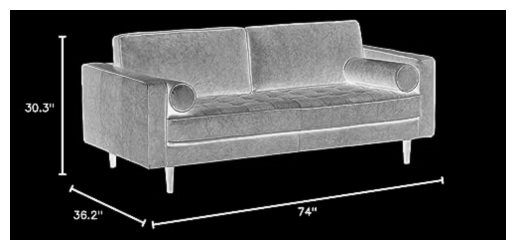

[([[41, 279], [141, 279], [141, 317], [41, 317]], '30.3"', 0.4803359781240607), ([[187, 603], [277, 603], [277, 641], [187, 641]], "36.2'", 0.5564020800698771), ([[864, 590], [936, 590], [936, 630], [864, 630]], '74"', 0.9998944912306124)]
first: ['30.3 in', '36.2', '74 in']
before ['30.3 in', '36.2', '74 in']
before ['30.3 inch', '36.2', '74 inch']
30.3
inch
74.0
inch
Best Entity Value for width: 74 inch

Entity :  height
Original Image Dimensions: Width=500, Height=232, Area=116000
Scaled Image Dimensions: Width=1500, Height=696


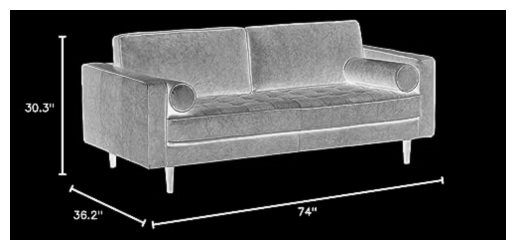

[([[41, 279], [141, 279], [141, 317], [41, 317]], '30.3"', 0.4803359781240607), ([[187, 603], [277, 603], [277, 641], [187, 641]], "36.2'", 0.5564020800698771), ([[864, 590], [936, 590], [936, 630], [864, 630]], '74"', 0.9998944912306124)]
first: ['30.3 in', '36.2', '74 in']
before ['30.3 in', '36.2', '74 in']
before ['30.3 inch', '36.2', '74 inch']
30.3
inch
74.0
inch
Best Entity Value for height: 30.3 inch

Entity :  item_weight
Original Image Dimensions: Width=500, Height=344, Area=172000
Scaled Image Dimensions: Width=1500, Height=1032


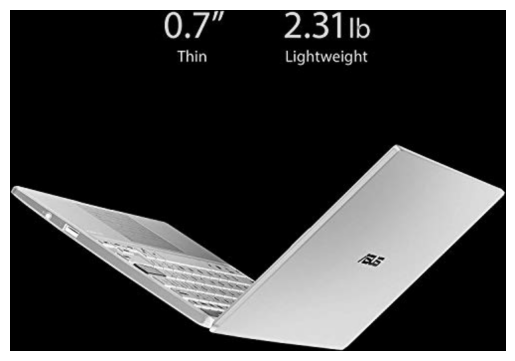

[([[456, 0], [560, 0], [560, 102], [456, 102]], '0.', 0.9865543897470618), ([[818, 0], [1100, 0], [1100, 102], [818, 102]], '2.311b', 0.5262313247133509), ([[498, 116], [602, 116], [602, 166], [498, 166]], 'Thin', 0.9998832941055298), ([[825, 115], [1091, 115], [1091, 177], [825, 177]], 'Lightweight', 0.6993690853638559), ([[1050, 732], [1132, 732], [1132, 780], [1050, 780]], '45', 0.1040411660195723), ([[543.4443650813896, -0.8894444302728317], [659.0607284078893, -7.484962093040057], [660.5556349186104, 90.88944443027283], [544.9392715921107, 98.48496209304005]], '7"', 0.9999743748122707)]
first: ['0', '2.311b', '', '', '45', '7 in']
before ['0', '2.311 b', '45', '7 in']
before ['0', '2.311 b', '45', '7 in']
No valid entity values found for item_weight in image 311KDyOGX-L.jpg

Entity :  height
Original Image Dimensions: Width=1000, Height=1000, Area=1000000


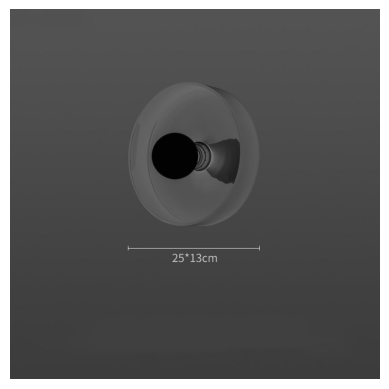

[([[433, 655], [565, 655], [565, 691], [433, 691]], '25*13cm', 0.9999777868803252)]
first: ['2513cm']
before ['2513 cm']
before ['2513 centimetre']
2513.0
centimetre
Best Entity Value for height: 2513 centimetre

Entity :  item_volume
Original Image Dimensions: Width=180, Height=500, Area=90000
Scaled Image Dimensions: Width=540, Height=1500


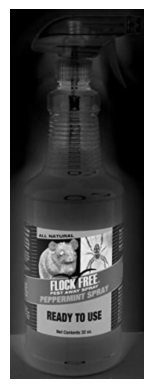

[([[108, 905], [260, 905], [260, 933], [108, 933]], 'ALCAIURAL', 0.08021856220053224), ([[108, 1141], [313, 1141], [313, 1205], [108, 1205]], 'PEPPERMINT', 0.16331082952917822), ([[136, 1213], [313, 1213], [313, 1280], [136, 1280]], 'READY TO', 0.6009697907467403), ([[180, 1294], [333, 1294], [333, 1323], [180, 1323]], 'dtorleh 4u', 0.008862234968343949), ([[260.4871464448379, 1082.4665807565787], [365.3366361744223, 1060.4700646426415], [374.5128535551621, 1121.5334192434213], [268.6633638255777, 1142.5299353573585]], 'FREE', 0.9691863059997559), ([[151.07695210471834, 1094.2693323665142], [271.86657507680906, 1080.1811916952847], [275.9230478952816, 1142.7306676334858], [154.13342492319094, 1156.8188083047153]], 'FlOcK ', 0.18174697644522897), ([[291.21086857389423, 1145.5632605721682], [402.8234417256267, 1104.7779985458203], [416.78913142610577, 1145.4367394278318], [306.1765582743733, 1186.2220014541797]], 'Saar', 0.037691034376621246), ([[301.3413067386629, 1216.199357628518], [3

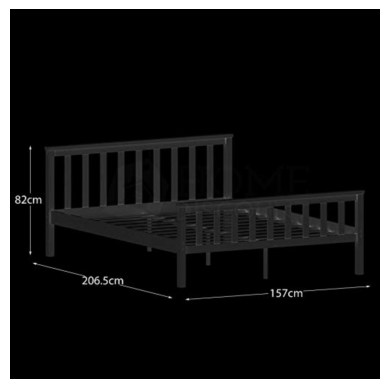

[([[12, 748], [136, 748], [136, 796], [12, 796]], '82cm', 0.9998367428779602), ([[284, 1076], [466, 1076], [466, 1124], [284, 1124]], '206.Scm', 0.5507182191235961), ([[1047, 1129], [1191, 1129], [1191, 1173], [1047, 1173]], '157cm', 0.9968600329632016)]
first: ['82cm', '206.Scm', '157cm']
before ['82 cm', '206.Scm', '157 cm']
before ['82 centimetre', '206.Scm', '157 centimetre']
82.0
centimetre
157.0
centimetre
Best Entity Value for height: 82 centimetre

Entity :  width
Original Image Dimensions: Width=500, Height=256, Area=128000
Scaled Image Dimensions: Width=1500, Height=768


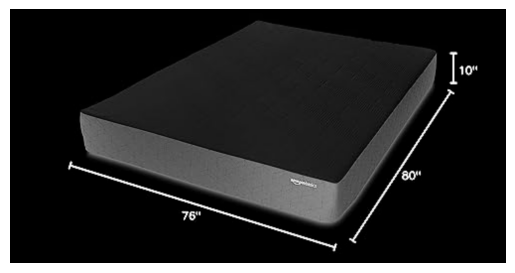

[([[1326, 130], [1358, 130], [1358, 226], [1326, 226]], '1', 0.1431093200558422), ([[1355, 165], [1421, 165], [1421, 205], [1355, 205]], '10"', 0.5455582141876221), ([[1177, 482], [1252, 482], [1252, 524], [1177, 524]], '801', 0.5507678708347005), ([[513, 607], [585, 607], [585, 643], [513, 643]], '76"', 0.9985250085470427)]
first: ['1', '10 in', '801', '76 in']
before ['1', '10 in', '801', '76 in']
before ['1', '10 inch', '801', '76 inch']
10.0
inch
76.0
inch
Best Entity Value for width: 10 inch

Entity :  item_weight
Original Image Dimensions: Width=158, Height=500, Area=79000
Scaled Image Dimensions: Width=474, Height=1500


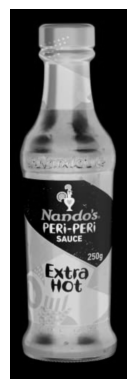

[([[118, 802], [365, 802], [365, 870], [118, 870]], 'Nandos', 0.9995452324150252), ([[122, 854], [357, 854], [357, 920], [122, 920]], 'PERi-PEQi', 0.6383056794480134), ([[181, 911], [299, 911], [299, 951], [181, 951]], 'SAUCE', 0.6857694397872315), ([[307, 981], [383, 981], [383, 1025], [307, 1025]], '250g', 0.5492346286773682), ([[152, 1084], [304, 1084], [304, 1156], [152, 1156]], 'Hot', 0.7358739197899751), ([[139.92344805679357, 1017.0646188713868], [332.7552559321683, 1042.9154152542455], [318.0765519432064, 1117.9353811286132], [126.2447440678317, 1092.0845847457545]], 'Extra', 0.9634708671595517), ([[82.03780454494682, 1131.0515822680054], [257.74284562262835, 1162.8639638535624], [239.96219545505318, 1241.9484177319946], [64.25715437737163, 1210.1360361464376]], 'U ;', 0.014468093499224444)]
first: ['', '', '', '250g', '', '', '']
before ['250 g']
before ['250 gram']
250.0
gram
Best Entity Value for item_weight: 250 gram

Entity :  voltage
Original Image Dimensions: Width=500, 

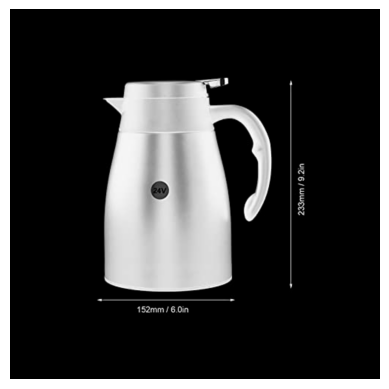

[([[1161, 621], [1199, 621], [1199, 703], [1161, 703]], '8', 0.496729190721684), ([[1165, 701], [1193, 701], [1193, 719], [1165, 719]], 'S', 0.04864597711619312), ([[576, 720], [640, 720], [640, 752], [576, 752]], 'PAV', 0.12064905236621087), ([[1161, 721], [1199, 721], [1199, 843], [1161, 843]], '1', 0.3899897239737271), ([[509, 1199], [731, 1199], [731, 1237], [509, 1237]], '152mm / 6.Oin', 0.60429576689169)]
first: ['8', '', '', '1', '152mm.Oin']
before ['8', '1', '152 mm.Oin']
before ['8', '1', '152 mm.Oin']
No valid entity values found for voltage in image 311dT7UohfS.jpg

Entity :  wattage
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


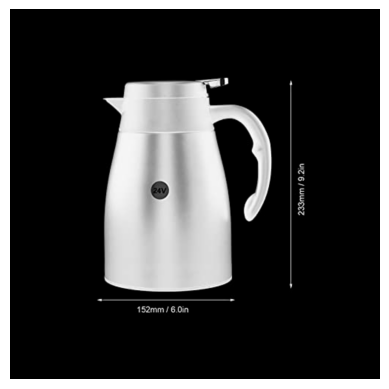

[([[1161, 621], [1199, 621], [1199, 703], [1161, 703]], '8', 0.496729190721684), ([[1165, 701], [1193, 701], [1193, 719], [1165, 719]], 'S', 0.04864597711619312), ([[576, 720], [640, 720], [640, 752], [576, 752]], 'PAV', 0.12064905236621087), ([[1161, 721], [1199, 721], [1199, 843], [1161, 843]], '1', 0.3899897239737271), ([[509, 1199], [731, 1199], [731, 1237], [509, 1237]], '152mm / 6.Oin', 0.60429576689169)]
first: ['8', '', '', '1', '152mm.Oin']
before ['8', '1', '152 mm.Oin']
before ['8', '1', '152 mm.Oin']
No valid entity values found for wattage in image 311dT7UohfS.jpg

Entity :  item_weight
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


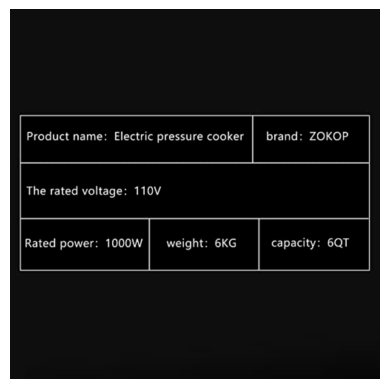

[([[62, 488], [400, 488], [400, 540], [62, 540]], 'Product name:', 0.99936000867688), ([[415, 487], [959, 487], [959, 551], [415, 551]], 'Electric pressure cooker', 0.9998989743935337), ([[1032, 488], [1378, 488], [1378, 540], [1032, 540]], 'brand: ZOKOP', 0.8112280760802688), ([[57, 702], [486, 702], [486, 777], [57, 777]], 'The rated voltage:', 0.8935444297298523), ([[496, 712], [620, 712], [620, 760], [496, 760]], 'T10V', 0.37063902616500854), ([[52, 920], [365, 920], [365, 985], [52, 985]], 'Rated power:', 0.9028558860177154), ([[382, 924], [544, 924], [544, 972], [382, 972]], '100ow', 0.3167722977930648), ([[627, 918], [812, 918], [812, 986], [627, 986]], 'weight:', 0.9707494330946088), ([[824, 922], [924, 922], [924, 972], [824, 972]], '6KG', 0.8856981992721558), ([[1051, 919], [1267, 919], [1267, 981], [1051, 981]], 'capacity:', 0.9972338861698926), ([[1280, 922], [1384, 922], [1384, 974], [1280, 974]], '6Q1', 0.49193724773789643)]
first: ['', '', '', '', 'T10V', '', '100ow', ''

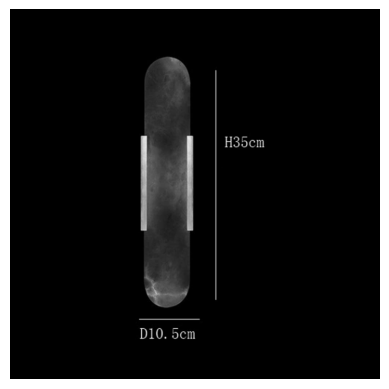

[([[574, 337], [695, 337], [695, 382], [574, 382]], 'H3scm', 0.6289645341676354), ([[346, 854], [509, 854], [509, 903], [346, 903]], 'D1O. Scm', 0.5178603095712034)]
first: ['H3scm', 'D1O']
before ['H3 scm', 'D1 O']
before ['H3 scm', 'D1 O']
No valid entity values found for width in image 311lBTY41pL.jpg

Entity :  depth
Original Image Dimensions: Width=1000, Height=1000, Area=1000000


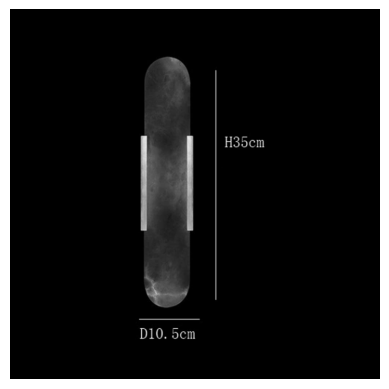

[([[574, 337], [695, 337], [695, 382], [574, 382]], 'H3scm', 0.6289645341676354), ([[346, 854], [509, 854], [509, 903], [346, 903]], 'D1O. Scm', 0.5178603095712034)]
first: ['H3scm', 'D1O']
before ['H3 scm', 'D1 O']
before ['H3 scm', 'D1 O']
No valid entity values found for depth in image 311lBTY41pL.jpg

Entity :  item_weight
Original Image Dimensions: Width=206, Height=250, Area=51500
Scaled Image Dimensions: Width=618, Height=750


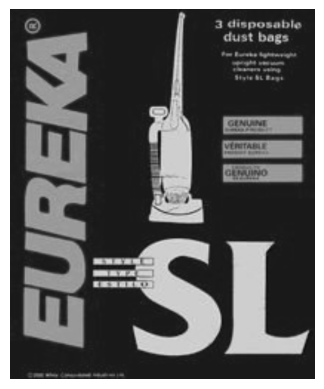

[([[410, 15], [596, 15], [596, 46], [410, 46]], '3 ieporublc', 0.03090060007828973), ([[428, 44], [496, 44], [496, 70], [428, 70]], 'dust', 0.39855867624282837), ([[1, 29], [178, 29], [178, 697], [1, 697]], '1', 0.3328088021505806), ([[185, 435], [618, 435], [618, 717], [185, 717]], 'SL', 0.6511287320014723), ([[499.1758366163079, 39.11542815707753], [572.9032737112665, 49.244353417615585], [566.8241633836922, 79.88457184292247], [494.0967262887336, 69.75564658238441]], 'bogs', 0.09552370756864548)]
first: ['3ieporublc', '', '1', '', '']
before ['3 ieporublc', '1']
before ['3 ieporublc', '1']
No valid entity values found for item_weight in image 311nVBb35CL.jpg

Entity :  height
Original Image Dimensions: Width=500, Height=279, Area=139500
Scaled Image Dimensions: Width=1500, Height=837


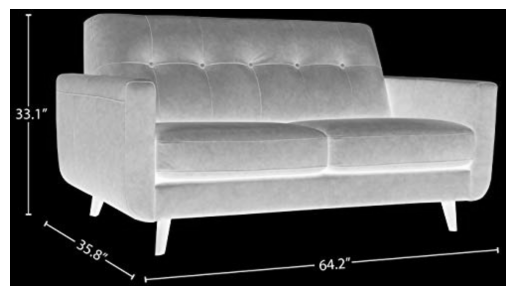

[([[11, 295], [119, 295], [119, 339], [11, 339]], '33.1"', 0.9961687710989927), ([[928, 744], [1036, 744], [1036, 796], [928, 796]], '64.2"', 0.99958618203198), ([[207.2989525145956, 678.0410963740627], [295.9719204748711, 730.4202018956436], [269.7010474854044, 774.9589036259373], [181.0280795251289, 721.5797981043564]], "35.8'", 0.7849915668340516)]
first: ['33.1 in', '64.2 in', '35.8']
before ['33.1 in', '64.2 in', '35.8']
before ['33.1 inch', '64.2 inch', '35.8']
33.1
inch
64.2
inch
Best Entity Value for height: 33.1 inch

Entity :  item_weight
Original Image Dimensions: Width=500, Height=500, Area=250000
Scaled Image Dimensions: Width=1500, Height=1500


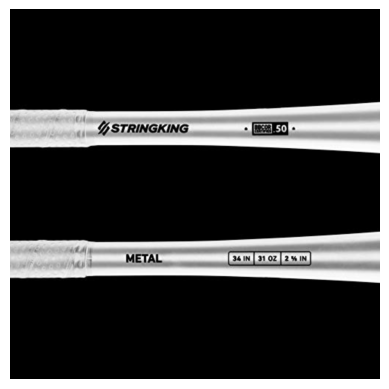

[([[347, 449], [733, 449], [733, 517], [347, 517]], 'ISTRINGKING', 0.517275365127683), ([[1071, 463], [1127, 463], [1127, 505], [1071, 505]], '50', 0.9992631840314304), ([[462, 986], [622, 986], [622, 1036], [462, 1036]], 'METAL', 0.9984540236958532), ([[897, 993], [979, 993], [979, 1029], [897, 1029]], '34 IN', 0.4733654025866425), ([[1000, 996], [1088, 996], [1088, 1028], [1000, 1028]], '31 02', 0.39013034885413106), ([[1107, 993], [1209, 993], [1209, 1029], [1107, 1029]], '2 % IN', 0.5310896104793409)]
first: ['', '50', '', '34IN', '3102', '2']
before ['50', '34 IN', '3102', '2']
before ['50', '34 IN', '3102', '2']
No valid entity values found for item_weight in image 311uqJG-v3L.jpg

Entity :  width
Original Image Dimensions: Width=1263, Height=1263, Area=1595169


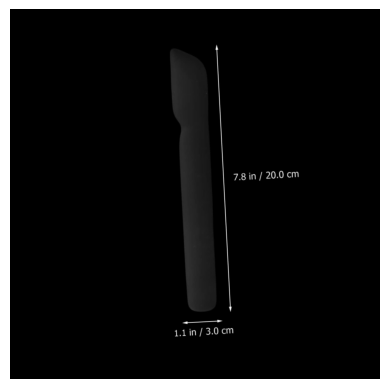

[([[759, 549], [991, 549], [991, 591], [759, 591]], '7.8 in / 20.0 cm', 0.8966842407802882), ([[557, 1081], [770, 1081], [770, 1121], [557, 1121]], '1.1 in / 3.0 cm', 0.9592459025087697)]
first: ['7.8in.0cm', '1.1in.0cm']
before ['7.8 in.0 cm', '1.1 in.0 cm']
before ['7.8 in.0 centimetre', '1.1 in.0 centimetre']
No valid entity values found for width in image 3121-R7e6gL.jpg

Entity :  height
Original Image Dimensions: Width=1263, Height=1263, Area=1595169


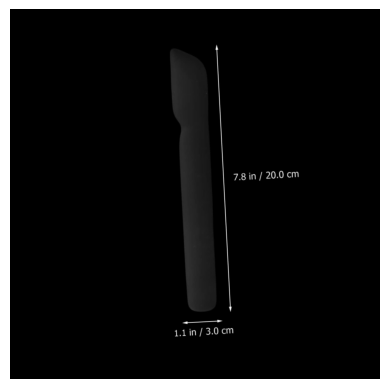

[([[759, 549], [991, 549], [991, 591], [759, 591]], '7.8 in / 20.0 cm', 0.8966842407802882), ([[557, 1081], [770, 1081], [770, 1121], [557, 1121]], '1.1 in / 3.0 cm', 0.9592459025087697)]
first: ['7.8in.0cm', '1.1in.0cm']
before ['7.8 in.0 cm', '1.1 in.0 cm']
before ['7.8 in.0 centimetre', '1.1 in.0 centimetre']
No valid entity values found for height in image 3121-R7e6gL.jpg

Entity :  width
Original Image Dimensions: Width=1024, Height=1024, Area=1048576


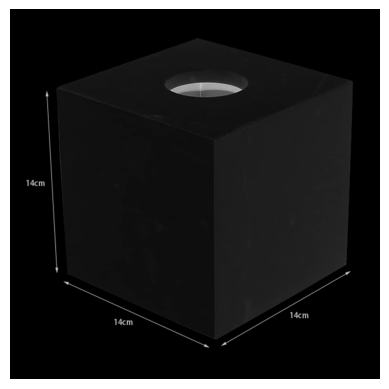

[([[40, 468], [100, 468], [100, 494], [40, 494]], '14cm', 0.964626669883728), ([[770, 834], [830, 834], [830, 860], [770, 860]], '14cm', 0.959957480430603), ([[284, 854], [344, 854], [344, 878], [284, 878]], '14cm', 0.9858276844024658)]
first: ['14cm', '14cm', '14cm']
before ['14 cm', '14 cm', '14 cm']
before ['14 centimetre', '14 centimetre', '14 centimetre']
14.0
centimetre
Best Entity Value for width: 14 centimetre

Entity :  item_weight
Original Image Dimensions: Width=158, Height=250, Area=39500
Scaled Image Dimensions: Width=474, Height=750


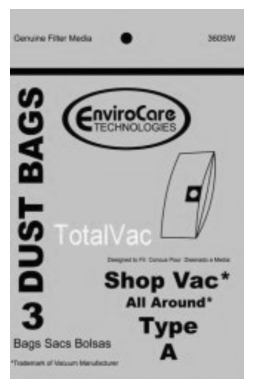

[([[2, 46], [170, 46], [170, 70], [2, 70]], 'cuurrvau', 0.03425461456064213), ([[397, 49], [459, 49], [459, 69], [397, 69]], 'Etust', 0.004859509501842674), ([[133, 184], [342, 184], [342, 238], [133, 238]], 'EnviroCare', 0.3086430505006241), ([[165, 224], [341, 224], [341, 254], [165, 254]], 'TECHROlOC es', 0.11921576168865602), ([[4, 146], [76, 146], [76, 360], [4, 360]], '9', 0.29095214713638384), ([[9, 375], [75, 375], [75, 581], [9, 581]], '3', 0.6598678397299551), ([[80, 426], [297, 426], [297, 491], [80, 491]], 'Totallvac', 0.44309015058456996), ([[247, 501], [317, 501], [317, 517], [247, 517]], 'EAT EFu', 0.015616707596464581), ([[180, 520], [453, 520], [453, 583], [180, 583]], 'Shop Vac*', 0.9511241884245337), ([[232, 579], [413, 579], [413, 611], [232, 611]], 'AlI Around"', 0.5497509300215208), ([[18, 586], [74, 586], [74, 656], [18, 656]], '3', 0.9999996423721633), ([[252, 615], [388, 615], [388, 680], [252, 680]], 'Type', 0.9990261197090149), ([[1, 661], [209, 661], [209, 7

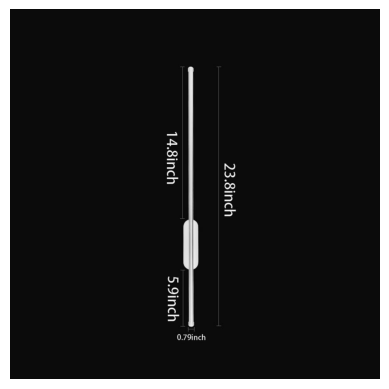

[([[419, 325], [459, 325], [459, 479], [419, 479]], '[', 0.16087201353869673), ([[568, 407], [616, 407], [616, 568], [568, 568]], '1', 0.08240077016847014), ([[419, 714], [461, 714], [461, 850], [419, 850]], '7', 0.15031220773189435), ([[446, 874], [532, 874], [532, 900], [446, 900]], '0.Z9inch', 0.6796756218870484)]
first: ['', '1', '7', '0.Z9inch']
before ['1', '7', '0.Z9 inch']
before ['1', '7', '0.Z9 inch']


ValueError: could not convert string to float: '0.Z9'

In [14]:
predictions = []    

for index, row in df.iterrows():
    image_url = row['image_link']
    group_id = row['group_id']
    entity_name = row['entity_name']

    print(f"Entity :  {entity_name}")
    
    # Extract the image name from the URL
    image_name = os.path.basename(image_url)
    image_save_path = os.path.join(image_folder, image_name)
    
    # Check if the image exists in the folder
    if os.path.exists(image_save_path):
        # Perform inference to extract text
        extracted_texts = inference(image_save_path, entity_name)

        # Skip if no valid entity values are found
        if not extracted_texts:
            print(f'No valid entity values found for {entity_name} in image {image_name}\n')
            predictions.append({'index': index, 'prediction': ''})
            continue

        # Check if the extracted text contains a range
        range_pattern = re.compile(r'\d+\s*-\s*\d+')
        contains_range = any(range_pattern.search(text) for text in extracted_texts)

        if contains_range:
            # print(f"Entity: {entity_name}")
            # print(f'Extracted text contains a range: {extracted_texts[0]}')
            print(f'Best Entity Value for {entity_name}: {extracted_texts[0]}\n')
            predictions.append({'index': index, 'prediction': extracted_texts[0]})
        else:
            # print(f"Entity: {entity_name}")
            best_entity_value = get_dimension(loaded_model, group_id, entity_name, extracted_texts)
            print(f'Best Entity Value for {entity_name}: {best_entity_value}\n')
            predictions.append({'index': index, 'prediction': best_entity_value})
    else:
        print(f'Image {image_name} not found in folder {image_folder}')
        predictions.append({'index': index, 'prediction': ''})

# Create a new DataFrame from the list
predictions_df = pd.DataFrame(predictions)

# Save the new DataFrame to a CSV file
predictions_df.to_csv('dataset1/predictions.csv', index=False)